# CMIP5 1981-2010: Grid Cell Clustering using Monthly Precip

Determine regionalization using clustering. Clusters are based on monthly statistics which have already been calculated and are imported here for processing.

Principal Component Analysis (PCA) is used to decompose a multivariate dataset (multiple variables or parameters) into a set of successive orthogonal components that explain a maximum amount of variance. In scikit-learn, PCA is implemented as a transformer object that learns components in its fit method, and can be used on new data to project it on these components.

PCA centers but does not scale the input data for each feature before applying the SVD. The optional parameter parameter **whiten=True** makes it possible to project the data onto the singular space while scaling each component to unit variance. This is often useful if the models down-stream make strong assumptions on the isotropy of the signal: this is for example the case for Support Vector Machines with the RBF kernel and the K-Means clustering algorithm. We use K-Means clustering so the **whiten=True** option should be employed.

[PCA scikit-learn](https://scikit-learn.org/stable/modules/decomposition.html#pca)

Clustering is identification of groups within a data set based on proximity. If 2 or 3 Principal Components are identified via PCA then these components are ideal candidates for clustering analysis. In general though, any parameters can be used for cluster identification.

The approach here to identify regions within our domain where PRISM grid cells provide similar precipitation statistics is as follows.

1. Use 2 data sets
    1. Sample mean and variance
    2. 3-Component PCA from five statistics (mean, median, variance, skewness, kurtosis)
        - this is where PCA comes in
2. Apply K-Means clustering to both data sets
    - Use 3, 4, and 5 for number of clusters
3. Test the clusters on L-moment ratio plots
4. Plot the clusters in map view and subjectively pick what seems to work best for each month.
    - Selected clustering approach will be cleaned for regional coherence elsewhere

K-means clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares (see below). This algorithm requires the number of clusters to be specified. It scales well to large number of samples and has been used across a large range of application areas in many different fields.

Inertia, or within-cluster sum-of-squares criterion, provides a measure of how internally coherent cluster are. It suffers from various drawbacks:

- Inertia makes the assumption that clusters are convex and isotropic, which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes.
- Inertia is not a normalized metric: we just know that lower values are better and zero is optimal. But in very high-dimensional spaces, Euclidean distances tend to become inflated (this is an instance of the so-called “curse of dimensionality”). Running a dimensionality reduction algorithm such as Principal component analysis (PCA) prior to k-means clustering can alleviate this problem and speed up the computations.

[K-means scikit-learn](https://scikit-learn.org/stable/modules/clustering.html#clustering)

## Imports and Parameters

In [1]:
# this tells Jupyter to embed matplotlib plots in the notebook
%matplotlib notebook

In [2]:
from IPython.display import display, HTML
import os
import numpy as np
import pandas as pd
import datetime as dt
import geopandas as gpd
from copy import deepcopy
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import shapely as sp
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from shapely.geometry import Point
from shapely.geometry import Polygon
import matplotlib.tri as tri
import matplotlib.path as MPath
import geoplot as gplt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from math import floor, ceil

In [3]:
OUT_DIR = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Recharge\Da' \
          r'ta\JNotes\Processed\CMIP5\Clustering_1981-2010'

In [4]:
IN_DIR = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Recharge\Da' \
         r'ta\JNotes\Processed\CMIP5\CMIP5_1981_WetDays'

In [5]:
BCCA_START = 169   # starting index for the BCA grid

Load the watershed shapefile for reference

In [6]:
WS_SHP = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Recharge\GI' \
         r'S\Shapefiles\UTM14N\Hydrology\Watersheds\Dolan_Creek_Watershed.shp'

In [7]:
DCWS = gpd.read_file( WS_SHP )
UTMCRS = DCWS.crs
UTMCRS

{'init': 'epsg:32614'}

Read in our basic statistics DataFrames which were saved to pickle files in the previous notebook

In [8]:
OutFName = os.path.normpath( os.path.join( IN_DIR, "Grid_Jan_Stats.pickle" ) )
gpdJanDF = pd.read_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( IN_DIR, "Grid_Feb_Stats.pickle" ) )
gpdFebDF = pd.read_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( IN_DIR, "Grid_Mar_Stats.pickle" ) )
gpdMarDF = pd.read_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( IN_DIR, "Grid_Apr_Stats.pickle" ) )
gpdAprDF = pd.read_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( IN_DIR, "Grid_May_Stats.pickle" ) )
gpdMayDF = pd.read_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( IN_DIR, "Grid_Jun_Stats.pickle" ) )
gpdJunDF = pd.read_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( IN_DIR, "Grid_Jul_Stats.pickle" ) )
gpdJulDF = pd.read_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( IN_DIR, "Grid_Aug_Stats.pickle" ) )
gpdAugDF = pd.read_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( IN_DIR, "Grid_Sep_Stats.pickle" ) )
gpdSepDF = pd.read_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( IN_DIR, "Grid_Oct_Stats.pickle" ) )
gpdOctDF = pd.read_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( IN_DIR, "Grid_Nov_Stats.pickle" ) )
gpdNovDF = pd.read_pickle( OutFName )
OutFName = os.path.normpath( os.path.join( IN_DIR, "Grid_Dec_Stats.pickle" ) )
gpdDecDF = pd.read_pickle( OutFName )

## Example Analysis for January

Start out working with the January DataFrame. This DataFrame contains a number of descriptive, statistical quantities.

In [11]:
display( HTML( gpdJanDF.head().to_html() ) )

Two collections are identified to look at as clustering possibilities

In [12]:
BSCols = [ "Mean", "Var" ]
LOBSArray = gpdJanDF.loc[:(BCCA_START-1), BSCols]
BCBSArray = gpdJanDF.loc[BCCA_START:, BSCols]
BCBSArray.shape

(42, 2)

In [13]:
LMCols = [ "L-CV", "L-Skewness" ]
LOLMArray = gpdJanDF.loc[:(BCCA_START-1), LMCols]
BCLMArray = gpdJanDF.loc[BCCA_START:, LMCols]
LOLMArray.shape

(168, 2)

<IPython.core.display.Javascript object>


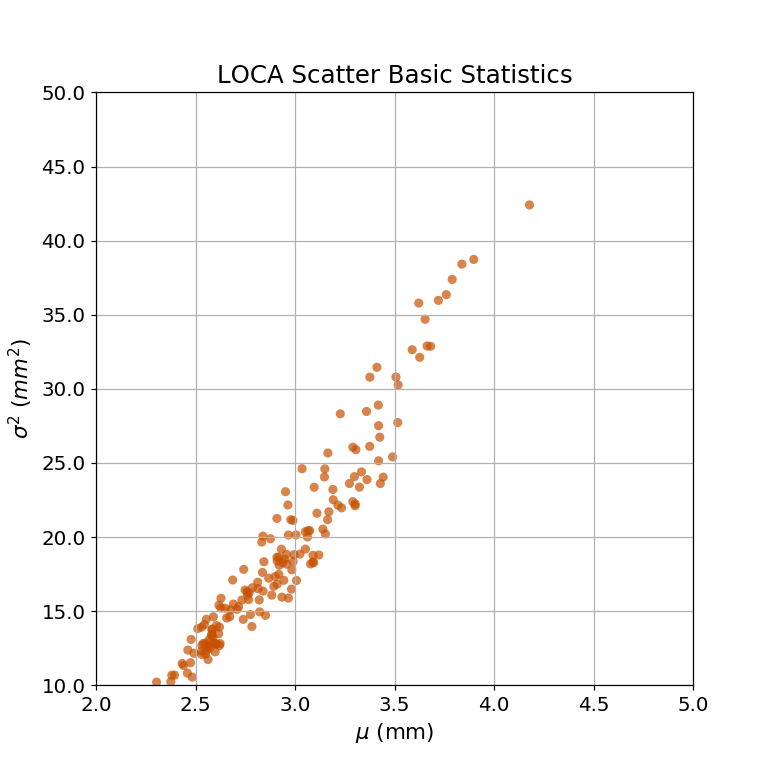

In [14]:
MaxX = round( LOBSArray[BSCols[0]].max() + 0.5, 0 )
MaxY = round( LOBSArray[BSCols[1]].max() + 5.0, -1 )
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( LOBSArray[BSCols[0]], LOBSArray[BSCols[1]], label="$\mu$ and $\sigma^{2}$",
                       alpha= 0.7, edgecolors='none', c="xkcd:dark orange" )
ax11.set_xlim( (2.0, MaxX) )
ax11.set_ylim( (10.0, MaxY) )
ax11.set_title("LOCA Scatter Basic Statistics", fontsize=16 )
ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
#ax11.legend()
ax11.grid(True)

<IPython.core.display.Javascript object>


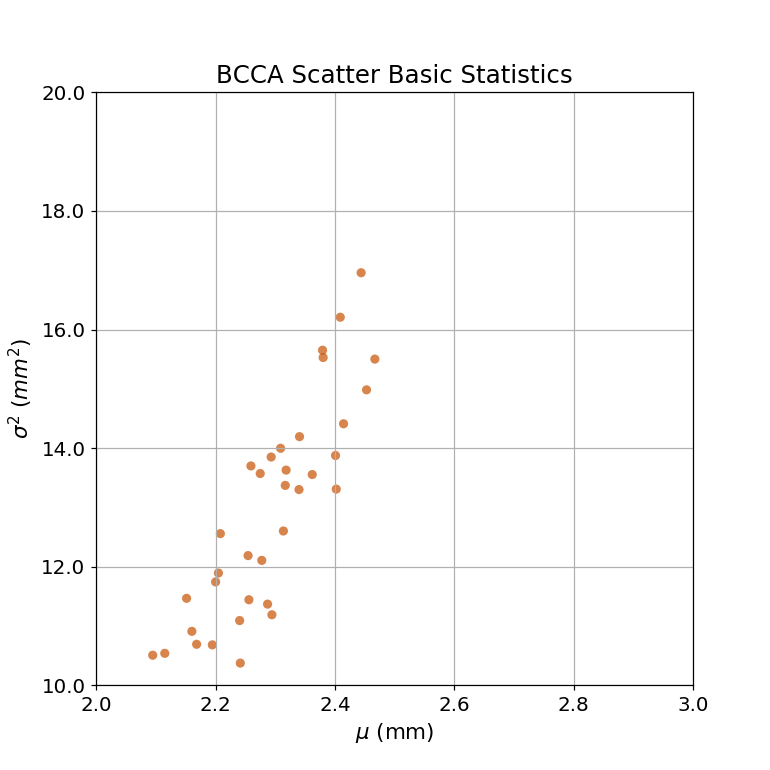

In [15]:
MaxX = round( BCBSArray[BSCols[0]].max() + 0.5, 0 )
MaxY = round( BCBSArray[BSCols[1]].max() + 5.0, -1 )
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( BCBSArray[BSCols[0]], BCBSArray[BSCols[1]], label="$\mu$ and $\sigma^{2}$",
                       alpha= 0.7, edgecolors='none', c="xkcd:dark orange" )
ax11.set_xlim( (2.0, MaxX) )
ax11.set_ylim( (10.0, MaxY) )
ax11.set_title("BCCA Scatter Basic Statistics", fontsize=16 )
ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
#ax11.legend()
ax11.grid(True)

<IPython.core.display.Javascript object>


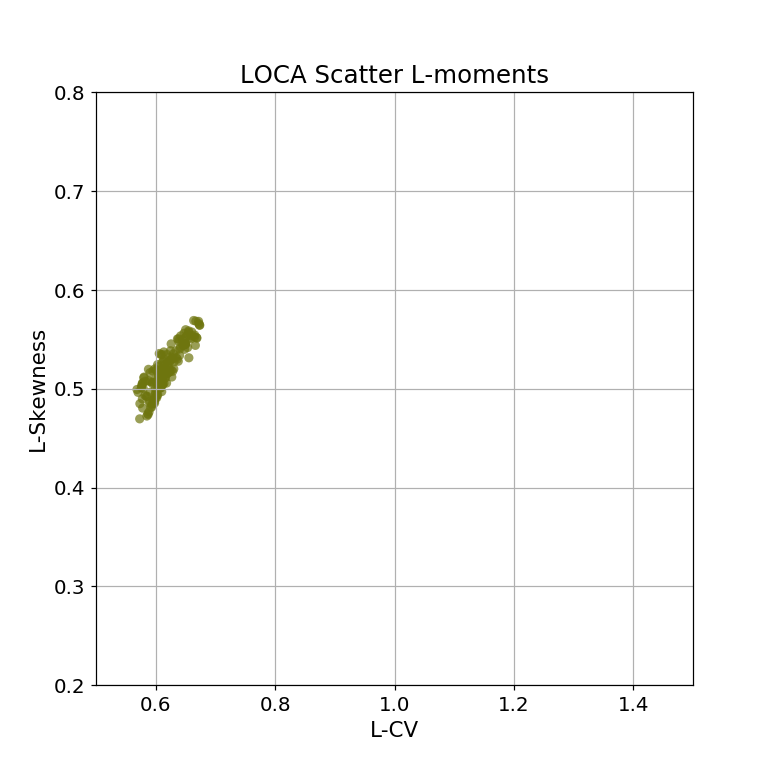

In [16]:
MaxX = round( LOLMArray[LMCols[0]].max(), 1 )
MaxY = round( LOLMArray[LMCols[1]].max(), 1 )
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( LOLMArray[LMCols[0]], LOLMArray[LMCols[1]], label="L_1 and L_2",
                       alpha= 0.7, edgecolors='none', c="xkcd:olive" )
ax11.set_xlim( (0.5, 1.5) )
ax11.set_ylim( (0.2, 0.8) )
ax11.set_title("LOCA Scatter L-moments", fontsize=16 )
ax11.set_xlabel(r'L-CV', fontsize=14 )
ax11.set_ylabel(r'L-Skewness', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
#ax11.legend()
ax11.grid(True)

<IPython.core.display.Javascript object>


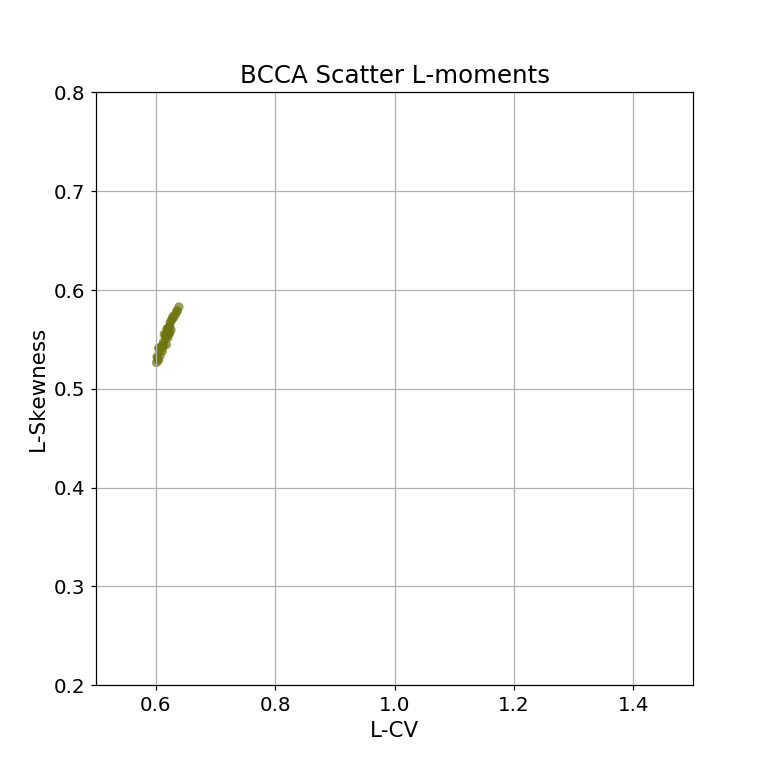

In [17]:
MaxX = round( BCLMArray[LMCols[0]].max(), 1 )
MaxY = round( BCLMArray[LMCols[1]].max(), 1 )
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( BCLMArray[LMCols[0]], BCLMArray[LMCols[1]], label="L_1 and L_2",
                       alpha= 0.7, edgecolors='none', c="xkcd:olive" )
ax11.set_xlim( (0.5, 1.5) )
ax11.set_ylim( (0.2, 0.8) )
ax11.set_title("BCCA Scatter L-moments", fontsize=16 )
ax11.set_xlabel(r'L-CV', fontsize=14 )
ax11.set_ylabel(r'L-Skewness', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
#ax11.legend()
ax11.grid(True)

Two collections are identified for PCA analysis and dimensionality reduction. The reduced dimensionality variables will then be used in clustering analysis.

In [18]:
BaseStatsCols = [ "Mean", "Median", "Var", "Skewness", "Kurtosis" ]
LOBaseStatsArray = gpdJanDF.loc[:(BCCA_START-1), BaseStatsCols]
BCBaseStatsArray = gpdJanDF.loc[BCCA_START:, BaseStatsCols]
LOBaseStatsArray.shape

(168, 5)

In [19]:
LMomStatsCols = [ 'L-CV', 'L-Skewness', 'L-Kurtosis' ]
LOLMomStatsArray = gpdJanDF.loc[:(BCCA_START-1), LMomStatsCols]
BCLMomStatsArray = gpdJanDF.loc[BCCA_START:, LMomStatsCols]
BCLMomStatsArray.shape

(42, 3)

### PCA

Principal component analysis is used to reduce our two DataFrames with statistical quantities to a collection of transformed variables with reduced dimensionality. This means that we are combining our original N variables to make a representation with N-1 parameters or less.

- *BaseStatsArray* has classic, descriptive statistics moments
    - Examine using 2 and 3 variables
- *LMomStatsArray* has L-moment ratios
    - Examine using 2 variables
    - Does not need to be whitened because are using L-moment ratios which are already scaled

In [20]:
LOpca2 = PCA(n_components=2, whiten=True, svd_solver='full' )
LOpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
LOpcaLM2 = PCA(n_components=2, whiten=False, svd_solver='full' )
BCpca2 = PCA(n_components=2, whiten=True, svd_solver='full' )
BCpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
BCpcaLM2 = PCA(n_components=2, whiten=False, svd_solver='full' )

#### Statistical Moments - 2 Components

In [21]:
LOresPCA2 = LOpca2.fit( LOBaseStatsArray )

In [22]:
BCresPCA2 = BCpca2.fit( BCBaseStatsArray )

In [23]:
print( "LOCA Percentage explained variance: %s  and Total explained variance: %f " % 
       (LOresPCA2.explained_variance_ratio_, sum(LOresPCA2.explained_variance_ratio_) ) )

LOCA Percentage explained variance: [0.87073047 0.12871356]  and Total explained variance: 0.999444 


In [24]:
print( "%s" % LOresPCA2.singular_values_ )

[90.00113514 34.60335955]


In [25]:
print( "%s" % LOresPCA2.components_ )

[[ 0.05064914  0.00175283  0.95354334 -0.01574165 -0.29654493]
 [ 0.01148508  0.0052913   0.29668705  0.07206639  0.9521677 ]]


In [26]:
print( "BCCA Percentage explained variance: %s  and Total explained variance: %f " % 
       (BCresPCA2.explained_variance_ratio_, sum(BCresPCA2.explained_variance_ratio_) ) )

BCCA Percentage explained variance: [0.9446447  0.05515617]  and Total explained variance: 0.999801 


In [27]:
print( "%s" % BCresPCA2.singular_values_ )

[31.42658238  7.59381403]


In [28]:
print( "%s" % BCresPCA2.components_ )

[[ 1.43123007e-02  1.44988559e-03  3.65928427e-01  6.90383693e-02
   9.27967211e-01]
 [-6.77919304e-02 -2.30564016e-02 -9.27536973e-01  4.43964192e-04
   3.66807338e-01]]


In [29]:
LOtrans2BaseStat = LOresPCA2.transform( LOBaseStatsArray )
BCtrans2BaseStat = BCresPCA2.transform( BCBaseStatsArray )
LOtrans2BaseStat.shape

(168, 2)

<IPython.core.display.Javascript object>


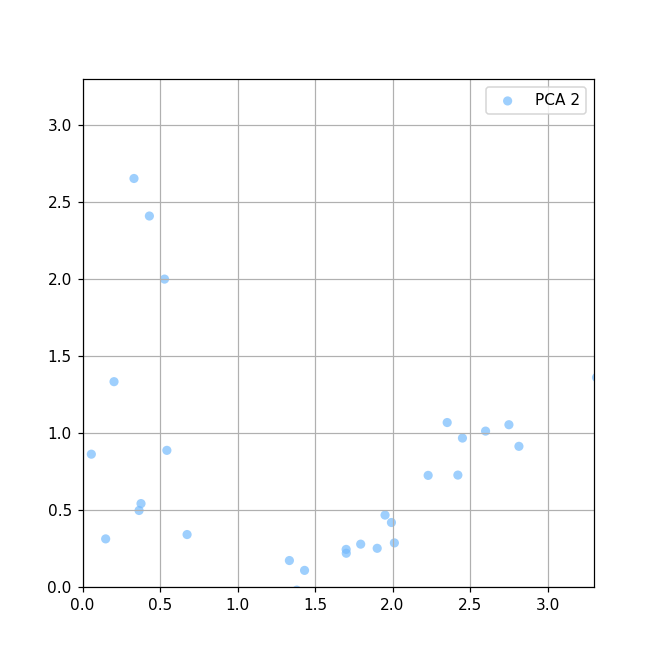

In [30]:
MaxV = round( max( LOtrans2BaseStat[:, 0].max(), LOtrans2BaseStat[:, 1].max() ), 1 )
Fig1 = plt.figure()
Fig1.set_size_inches(6.0, 6.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( LOtrans2BaseStat[:, 0], LOtrans2BaseStat[:, 1], label="PCA 2",
                       alpha= 0.7, edgecolors='none', c="xkcd:sky blue" )
ax11.set_xlim( (0.0, MaxV) )
ax11.set_ylim( (0.0, MaxV) )
ax11.legend()
ax11.grid(True)

<IPython.core.display.Javascript object>


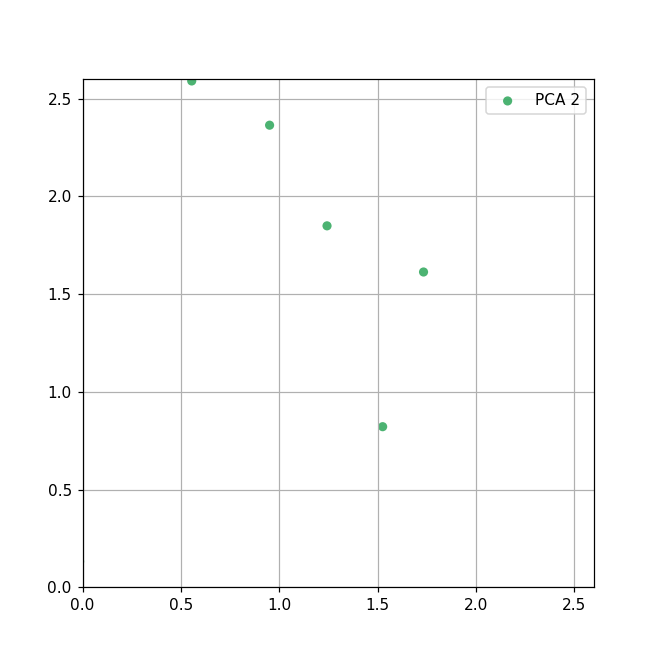

In [31]:
MaxV = round( max( BCtrans2BaseStat[:, 0].max(), BCtrans2BaseStat[:, 1].max() ), 1 )
Fig1 = plt.figure()
Fig1.set_size_inches(6.0, 6.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( BCtrans2BaseStat[:, 0], BCtrans2BaseStat[:, 1], label="PCA 2",
                       alpha= 0.7, edgecolors='none', c="xkcd:kelley green" )
ax11.set_xlim( (0.0, MaxV) )
ax11.set_ylim( (0.0, MaxV) )
ax11.legend()
ax11.grid(True)

#### Statistical Moments - 3 Components

In [32]:
LOresPCA3 = LOpca3.fit( LOBaseStatsArray )
BCresPCA3 = BCpca3.fit( BCBaseStatsArray )

In [33]:
print( "LOCA Percentage explained variance: %s  and Total explained variance: %f " % 
       (LOresPCA3.explained_variance_ratio_, sum(LOresPCA3.explained_variance_ratio_) ) )

LOCA Percentage explained variance: [8.70730471e-01 1.28713559e-01 5.21396160e-04]  and Total explained variance: 0.999965 


In [34]:
print( "%s" % LOresPCA3.singular_values_ )

[90.00113514 34.60335955  2.20236872]


In [35]:
print( "%s" % LOresPCA3.components_ )

[[ 0.05064914  0.00175283  0.95354334 -0.01574165 -0.29654493]
 [ 0.01148508  0.0052913   0.29668705  0.07206639  0.9521677 ]
 [ 0.58997435  0.7792841  -0.0317849  -0.20840769  0.01423072]]


In [36]:
print( "BCCA Percentage explained variance: %s  and Total explained variance: %f " % 
       (BCresPCA3.explained_variance_ratio_, sum(BCresPCA3.explained_variance_ratio_) ) )

BCCA Percentage explained variance: [9.44644698e-01 5.51561694e-02 1.82372565e-04]  and Total explained variance: 0.999983 


In [37]:
print( "%s" % BCresPCA3.singular_values_ )

[31.42658238  7.59381403  0.43665925]


In [38]:
print( "%s" % BCresPCA3.components_ )

[[ 1.43123007e-02  1.44988559e-03  3.65928427e-01  6.90383693e-02
   9.27967211e-01]
 [-6.77919304e-02 -2.30564016e-02 -9.27536973e-01  4.43964192e-04
   3.66807338e-01]
 [ 5.16726100e-01  3.72312636e-01 -2.43647123e-02 -7.68371055e-01
   5.82213195e-02]]


In [39]:
LOtrans3BaseStat = LOresPCA3.transform( LOBaseStatsArray )
BCtrans3BaseStat = BCresPCA3.transform( BCBaseStatsArray )
BCtrans3BaseStat.shape

(42, 3)

<IPython.core.display.Javascript object>


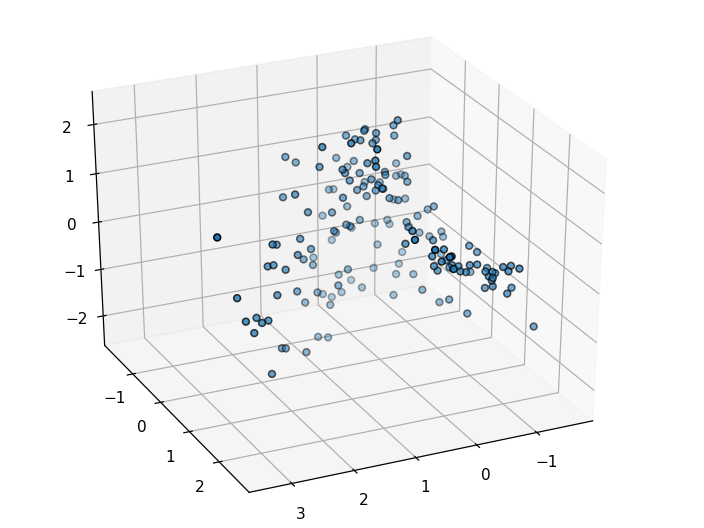

In [40]:
Fig1 = plt.figure()
ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
ax11.scatter( LOtrans3BaseStat[:, 0], LOtrans3BaseStat[:, 1], LOtrans3BaseStat[:, 2],
              edgecolor='k' )

<IPython.core.display.Javascript object>


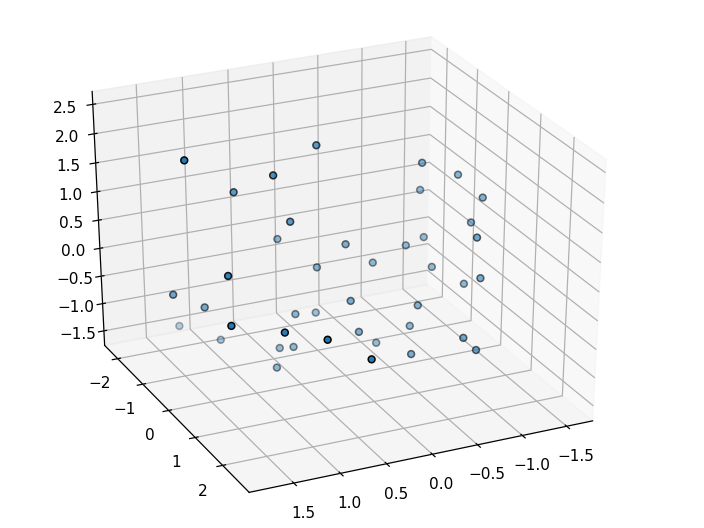

In [41]:
Fig1 = plt.figure()
ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
ax11.scatter( BCtrans3BaseStat[:, 0], BCtrans3BaseStat[:, 1], BCtrans3BaseStat[:, 2],
              edgecolor='k' )

#### L-moments 2 Components

In [42]:
LOresLMPCA2 = LOpcaLM2.fit( LOLMomStatsArray )
BCresLMPCA2 = BCpcaLM2.fit( BCLMomStatsArray )

In [43]:
print( "Percentage explained variance: %s  and Total explained variance: %f " % 
       (LOresLMPCA2.explained_variance_ratio_, sum(LOresLMPCA2.explained_variance_ratio_) ) )

Percentage explained variance: [0.99527309 0.00470669]  and Total explained variance: 0.999980 


In [44]:
print( "%s" % LOresLMPCA2.singular_values_ )

[3.11348678 0.21410842]


In [45]:
print( "%s" % LOresLMPCA2.components_ )

[[-0.10316021 -0.07086331 -0.99213727]
 [-0.36411334 -0.92553367  0.10396584]]


In [46]:
print( "Percentage explained variance: %s  and Total explained variance: %f " % 
       (BCresLMPCA2.explained_variance_ratio_, sum(BCresLMPCA2.explained_variance_ratio_) ) )

Percentage explained variance: [0.98133104 0.01866163]  and Total explained variance: 0.999993 


In [47]:
print( "%s" % BCresLMPCA2.singular_values_ )

[0.38476897 0.05305997]


In [48]:
print( "%s" % BCresLMPCA2.components_ )

[[ 0.15425056  0.21080589  0.96528112]
 [-0.32854274 -0.91043583  0.251329  ]]


In [49]:
LOtrans2LMStat = LOresLMPCA2.transform( LOLMomStatsArray )
LOtrans2LMStat.shape

(168, 2)

In [50]:
BCtrans2LMStat = BCresLMPCA2.transform( BCLMomStatsArray )
BCtrans2LMStat.shape

(42, 2)

<IPython.core.display.Javascript object>


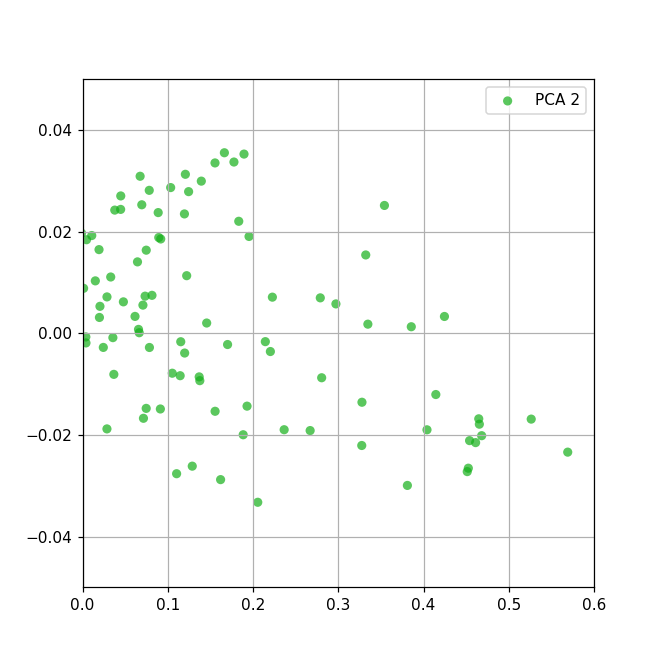

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  if __name__ == '__main__':


In [51]:
MaxX = round( LOtrans2LMStat[:, 0].max(), 1 )
MaxY = round( LOtrans2LMStat[:, 1].max(), 1 )
Fig1 = plt.figure()
Fig1.set_size_inches(6.0, 6.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( LOtrans2LMStat[:, 0], LOtrans2LMStat[:, 1], label="PCA 2",
                       alpha= 0.7, edgecolors='none', c="xkcd:green" )
ax11.set_xlim( (0.0, MaxX) )
ax11.set_ylim( (0.0, MaxY) )
ax11.legend()
ax11.grid(True)

<IPython.core.display.Javascript object>


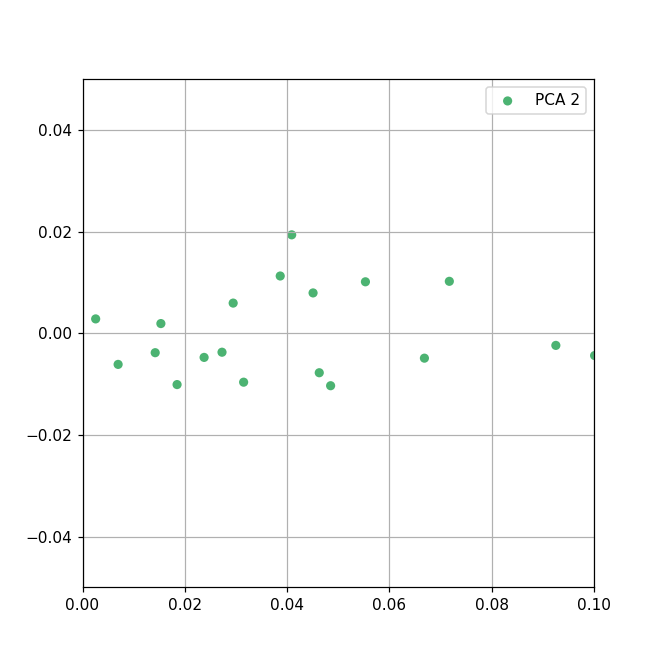

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  if __name__ == '__main__':


In [52]:
MaxX = round( BCtrans2LMStat[:, 0].max(), 1 )
MaxY = round( BCtrans2LMStat[:, 1].max(), 1 )
Fig1 = plt.figure()
Fig1.set_size_inches(6.0, 6.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( BCtrans2LMStat[:, 0], BCtrans2LMStat[:, 1], label="PCA 2",
                       alpha= 0.7, edgecolors='none', c="xkcd:kelley green" )
ax11.set_xlim( (0.0, MaxX) )
ax11.set_ylim( (0.0, MaxY) )
ax11.legend()
ax11.grid(True)

From visual analysis of the preceeding analysis, 3 component PCA from 5 statistics provides the most cluster-friendly looking spread. As with the PRISM data, use the basic or standard statistics. Use the following:

- **BSArray** 2 Component for first two moments, mean and variance
- **trans3BaseStat** for PCA, 3 Components from 5 statistics

Use scatter plots of L-moment ratios to check the clustering

### K-Means Clustering

#### 2 Component, Statistical Moments

Create a tracking copy DataFrame

In [53]:
PolyList = gpdJanDF['geometry'].tolist()

In [54]:
LOBSTrackDF = LOBSArray.copy()
BCBSTrackDF = BCBSArray.copy()

In [55]:
LOBSTrackDF[LMCols[0]] = np.array( gpdJanDF.loc[:(BCCA_START-1),LMCols[0]], dtype=np.float32 )
BCBSTrackDF[LMCols[0]] = np.array( gpdJanDF.loc[BCCA_START:,LMCols[0]], dtype=np.float32 )
LOBSTrackDF[LMCols[1]] = np.array( gpdJanDF.loc[:(BCCA_START-1),LMCols[1]], dtype=np.float32 )
BCBSTrackDF[LMCols[1]] = np.array( gpdJanDF.loc[BCCA_START:,LMCols[1]], dtype=np.float32 )

In [56]:
gpdLOBSTrackDS = gpd.GeoDataFrame( LOBSTrackDF, geometry=PolyList[:(BCCA_START-1)] )
gpdBCBSTrackDS = gpd.GeoDataFrame( BCBSTrackDF, geometry=PolyList[(BCCA_START-1):] )
gpdLOBSTrackDS.crs = UTMCRS
gpdBCBSTrackDS.crs = UTMCRS

Set up our estimators

In [57]:
CNamesList = [ 'K-Means_3', 'K-Means_4', 'K-Means_5' ]

In [58]:
clustEst = [(CNamesList[0], KMeans(n_clusters=3)),
            (CNamesList[1], KMeans(n_clusters=4)),
            (CNamesList[2], KMeans(n_clusters=5)),
           ]

In [59]:
cEst = clustEst[1][1]
LOcBS = cEst.fit( LOBSArray )

In [60]:
LOcBS.cluster_centers_

array([[ 2.92085233, 17.95764379],
       [ 3.67669089, 34.59842765],
       [ 3.24333563, 24.09056794],
       [ 2.57659922, 13.15674021]])

In [61]:
LOcBS.inertia_

602.8595163355806

In [62]:
LOInertiaArray = np.zeros( len(clustEst), dtype=np.float32 )
BCInertiaArray = np.zeros( len(clustEst), dtype=np.float32 )

In [63]:
iCnt = 0
for name, cEst in clustEst:
    BCcEst = deepcopy( cEst )
    LOcBS = cEst.fit( LOBSArray )
    BCcBS = BCcEst.fit( BCBSArray )
    LOInertiaArray[iCnt] = LOcBS.inertia_
    BCInertiaArray[iCnt] = BCcBS.inertia_
    gpdLOBSTrackDS[name] = LOcBS.fit_predict( LOBSArray )
    gpdBCBSTrackDS[name] = BCcBS.fit_predict( BCBSArray )
    iCnt += 1
# end for

In [64]:
display( HTML( gpdLOBSTrackDS.head().to_html() ) )

In [65]:
display( HTML( gpdBCBSTrackDS.head().to_html() ) )

<IPython.core.display.Javascript object>


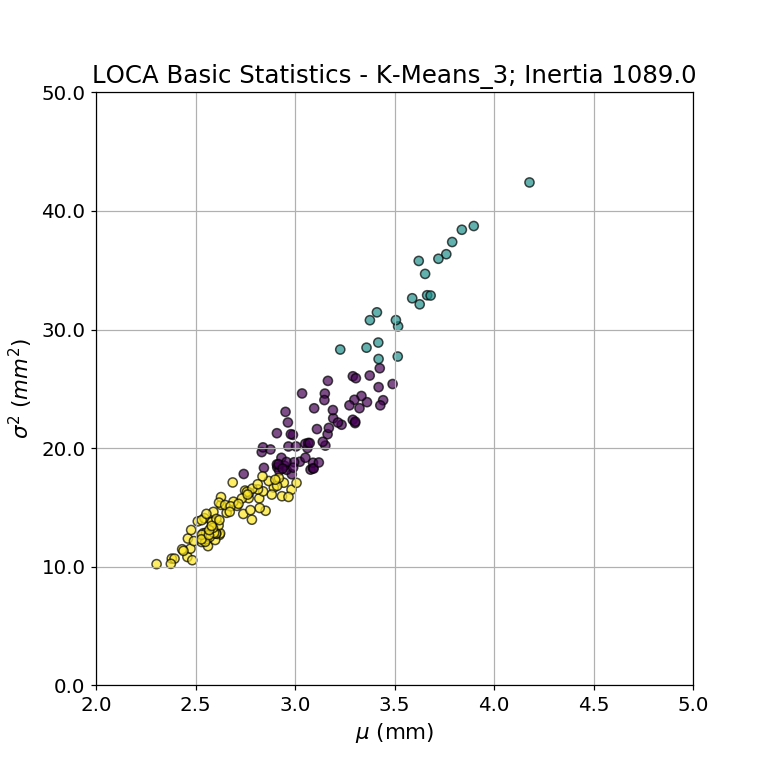

In [66]:
LOMaxX = round( gpdLOBSTrackDS[BSCols[0]].max() + 0.5, 0 )
LOMaxY = round( gpdLOBSTrackDS[BSCols[1]].max() + 10.0, -1 )
LOMinX = round( gpdLOBSTrackDS[BSCols[0]].min() - 0.5, 0 )
LOMinY = round( gpdLOBSTrackDS[BSCols[1]].min() - 10.0, -1 )
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( gpdLOBSTrackDS[BSCols[0]], gpdLOBSTrackDS[BSCols[1]], 
                      label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                      c=gpdLOBSTrackDS[CNamesList[0]] )
ax11.set_xlim( (LOMinX, LOMaxX) )
ax11.set_ylim( (LOMinY, LOMaxY) )
ax11.set_title("LOCA Basic Statistics - %s; Inertia %6.1f" % 
               (CNamesList[0], LOInertiaArray[0]), fontsize=16 )
ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
#ax11.legend()
ax11.grid(True)

<IPython.core.display.Javascript object>


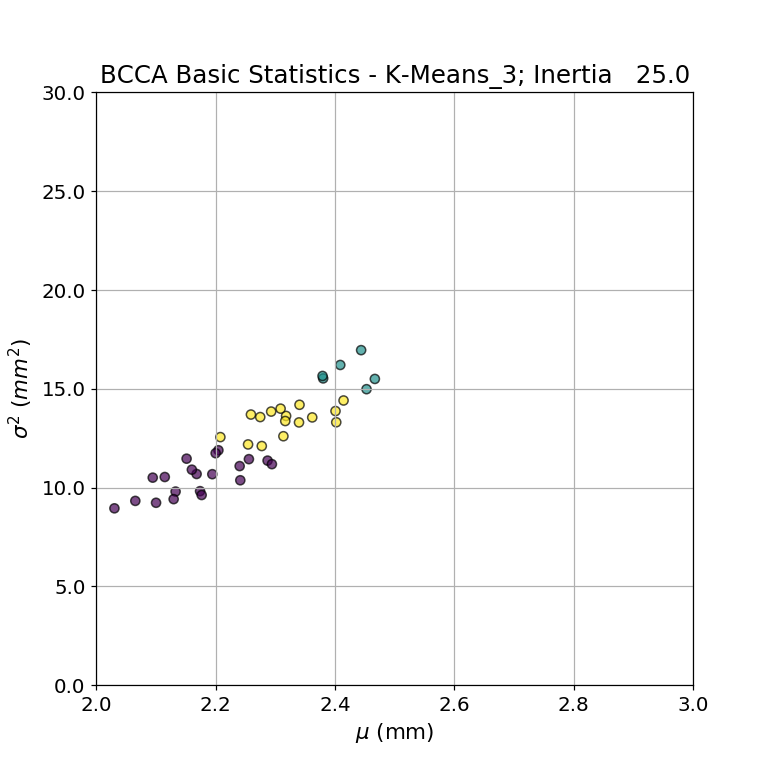

In [67]:
BCMaxX = round( gpdBCBSTrackDS[BSCols[0]].max() + 0.5, 0 )
BCMaxY = round( gpdBCBSTrackDS[BSCols[1]].max() + 10.0, -1 )
BCMinX = round( gpdBCBSTrackDS[BSCols[0]].min() - 0.5, 0 )
BCMinY = round( gpdBCBSTrackDS[BSCols[1]].min() - 10.0, -1 )
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( gpdBCBSTrackDS[BSCols[0]], gpdBCBSTrackDS[BSCols[1]], 
                      label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                      c=gpdBCBSTrackDS[CNamesList[0]] )
ax11.set_xlim( (BCMinX, BCMaxX) )
ax11.set_ylim( (BCMinY, BCMaxY) )
ax11.set_title("BCCA Basic Statistics - %s; Inertia %6.1f" % 
               (CNamesList[0], BCInertiaArray[0]), fontsize=16 )
ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
#ax11.legend()
ax11.grid(True)

<IPython.core.display.Javascript object>


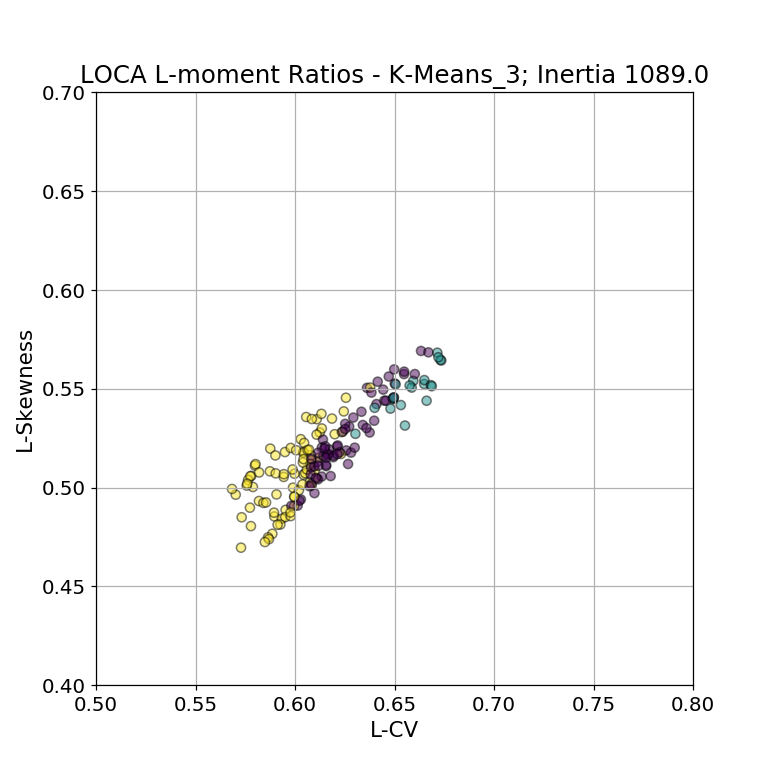

In [68]:
LOMaxLMX = round( gpdLOBSTrackDS[LMCols[0]].max() + 0.1, 1 )
LOMaxLMY = round( gpdLOBSTrackDS[LMCols[1]].max() + 0.1, 1 )
LOMinLMX = round( gpdLOBSTrackDS[LMCols[0]].min() - 0.1, 1 )
LOMinLMY = round( gpdLOBSTrackDS[LMCols[1]].min() - 0.1, 1 )
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( gpdLOBSTrackDS[LMCols[0]], gpdLOBSTrackDS[LMCols[1]], 
                      label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                      c=gpdLOBSTrackDS[CNamesList[0]] )
ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
               (CNamesList[0], LOInertiaArray[0]), fontsize=16 )
ax11.set_xlabel(r'L-CV', fontsize=14 )
ax11.set_ylabel(r'L-Skewness', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
#ax11.legend()
ax11.grid(True)

<IPython.core.display.Javascript object>


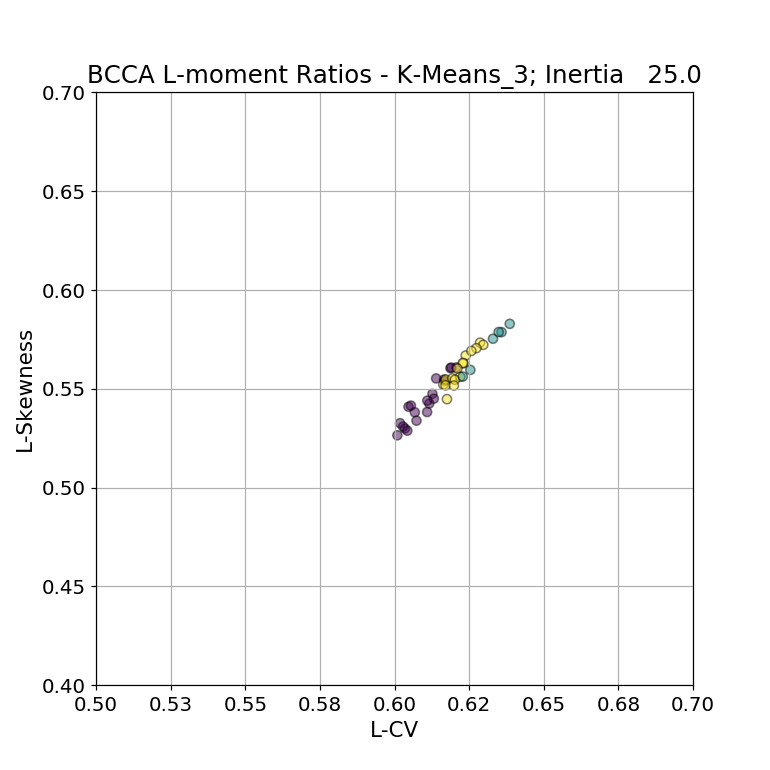

In [69]:
BCMaxLMX = round( gpdBCBSTrackDS[LMCols[0]].max() + 0.1, 1 )
BCMaxLMY = round( gpdBCBSTrackDS[LMCols[1]].max() + 0.1, 1 )
BCMinLMX = round( gpdBCBSTrackDS[LMCols[0]].min() - 0.1, 1 )
BCMinLMY = round( gpdBCBSTrackDS[LMCols[1]].min() - 0.1, 1 )
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( gpdBCBSTrackDS[LMCols[0]], gpdBCBSTrackDS[LMCols[1]], 
                      label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                      c=gpdBCBSTrackDS[CNamesList[0]] )
ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
               (CNamesList[0], BCInertiaArray[0]), fontsize=16 )
ax11.set_xlabel(r'L-CV', fontsize=14 )
ax11.set_ylabel(r'L-Skewness', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
#ax11.legend()
ax11.grid(True)

<IPython.core.display.Javascript object>


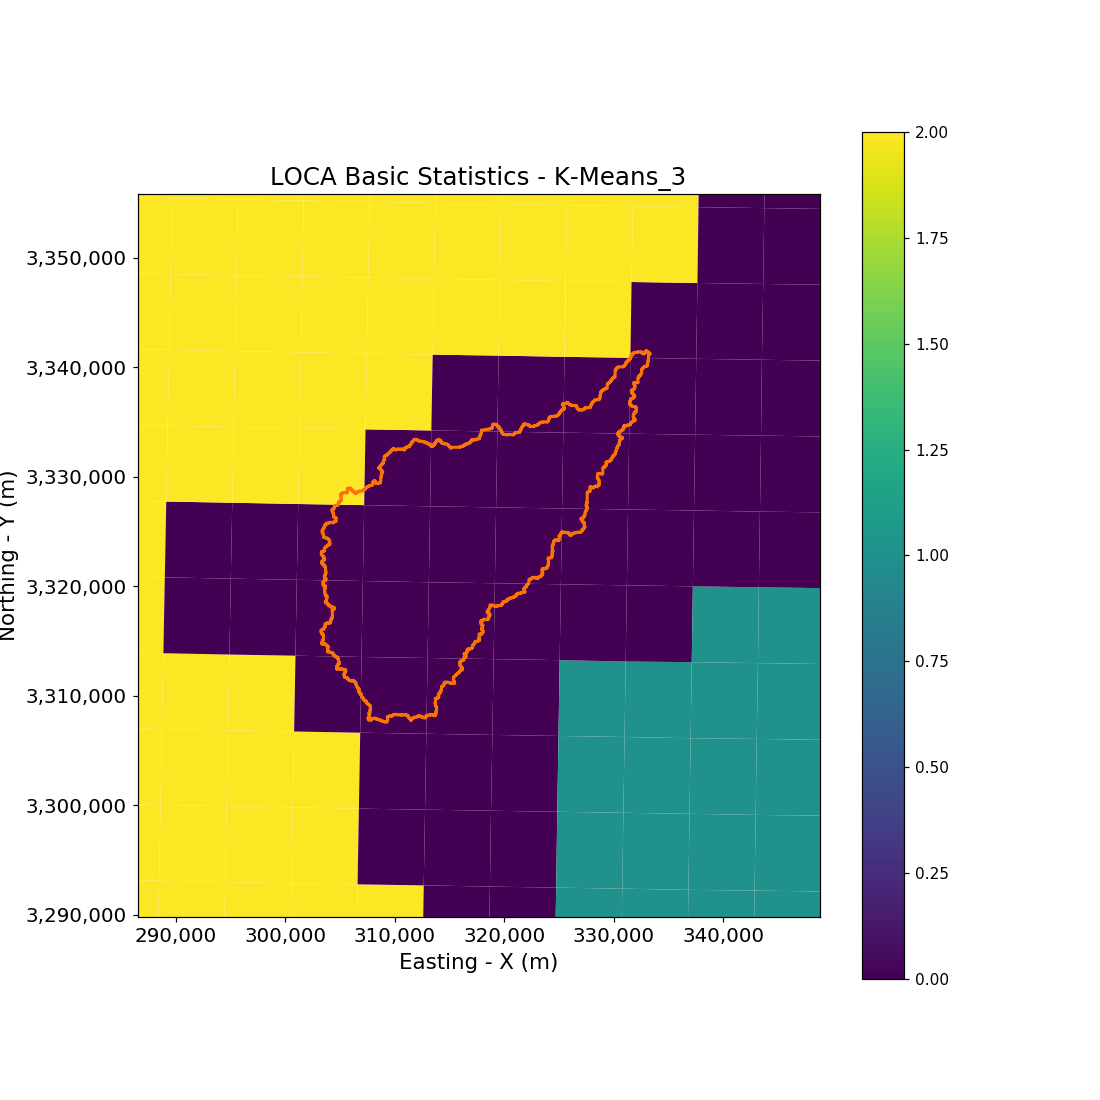

In [70]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 10.0)
ax11 = Fig1.add_subplot(111)
gpdLOBSTrackDS.plot(column=CNamesList[0], ax=ax11, legend=True )
DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, label="Watershed" )
ax11.set_xlim( ( 286500, 348800 ) )
ax11.set_ylim( ( 3289800, 3355800 ) )
ax11.set_title("LOCA Basic Statistics - %s" % CNamesList[0], fontsize=16 )
ax11.set_xlabel('Easting - X (m)', fontsize=14 )
ax11.set_ylabel('Northing - Y (m)', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )

<IPython.core.display.Javascript object>


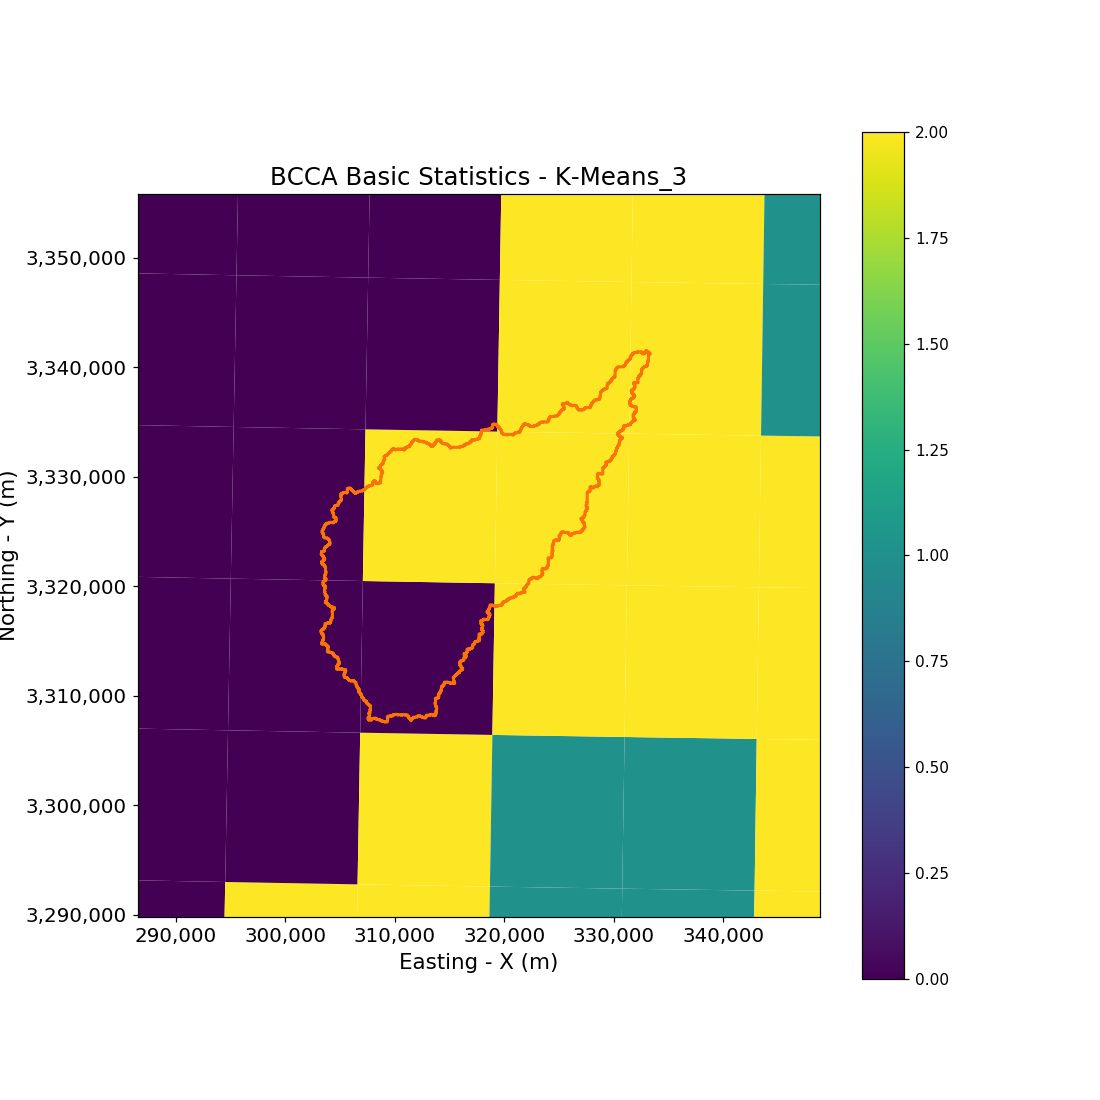

In [71]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 10.0)
ax11 = Fig1.add_subplot(111)
gpdBCBSTrackDS.plot(column=CNamesList[0], ax=ax11, legend=True )
DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, label="Watershed" )
ax11.set_xlim( ( 286500, 348800 ) )
ax11.set_ylim( ( 3289800, 3355800 ) )
ax11.set_title("BCCA Basic Statistics - %s" % CNamesList[0], fontsize=16 )
ax11.set_xlabel('Easting - X (m)', fontsize=14 )
ax11.set_ylabel('Northing - Y (m)', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )

<IPython.core.display.Javascript object>


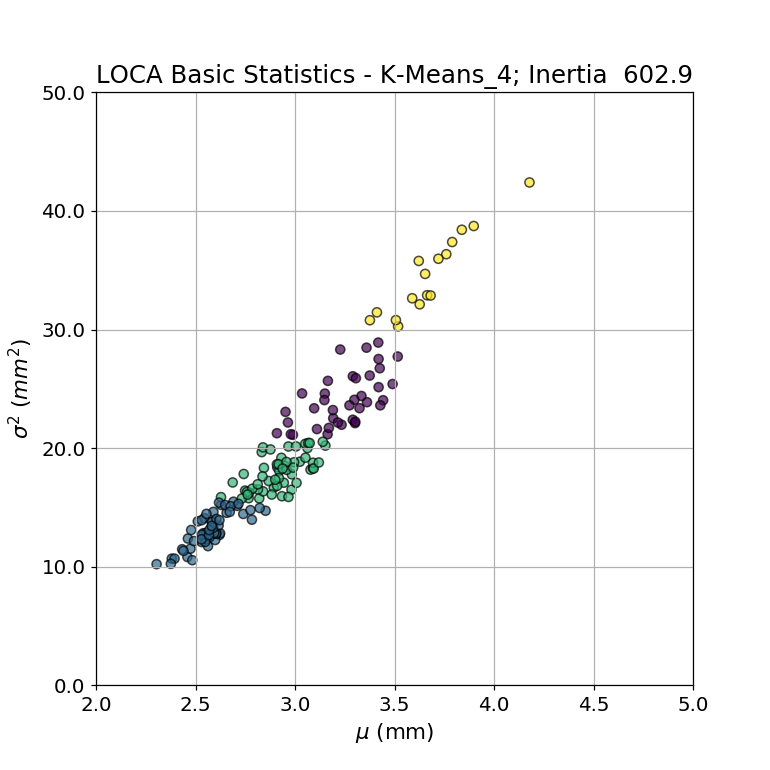

In [72]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( gpdLOBSTrackDS[BSCols[0]], gpdLOBSTrackDS[BSCols[1]], 
                      label="$\mu$ and $\sigma^{2}$", alpha= 0.7, 
                      edgecolors='k', c=gpdLOBSTrackDS[CNamesList[1]] )
ax11.set_xlim( (LOMinX, LOMaxX) )
ax11.set_ylim( (LOMinY, LOMaxY) )
ax11.set_title( "LOCA Basic Statistics - %s; Inertia %6.1f" % 
                (CNamesList[1], LOInertiaArray[1]), fontsize=16 )
ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
#ax11.legend()
ax11.grid(True)

<IPython.core.display.Javascript object>


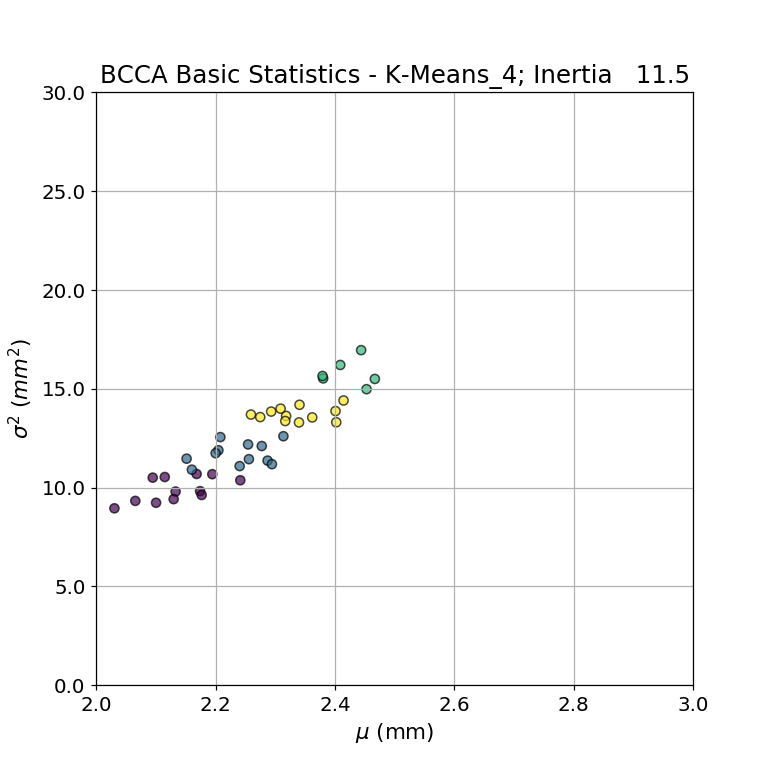

In [73]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( gpdBCBSTrackDS[BSCols[0]], gpdBCBSTrackDS[BSCols[1]], 
                      label="$\mu$ and $\sigma^{2}$", alpha= 0.7, 
                      edgecolors='k', c=gpdBCBSTrackDS[CNamesList[1]] )
ax11.set_xlim( (BCMinX, BCMaxX) )
ax11.set_ylim( (BCMinY, BCMaxY) )
ax11.set_title( "BCCA Basic Statistics - %s; Inertia %6.1f" % 
                (CNamesList[1], BCInertiaArray[1]), fontsize=16 )
ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
#ax11.legend()
ax11.grid(True)

<IPython.core.display.Javascript object>


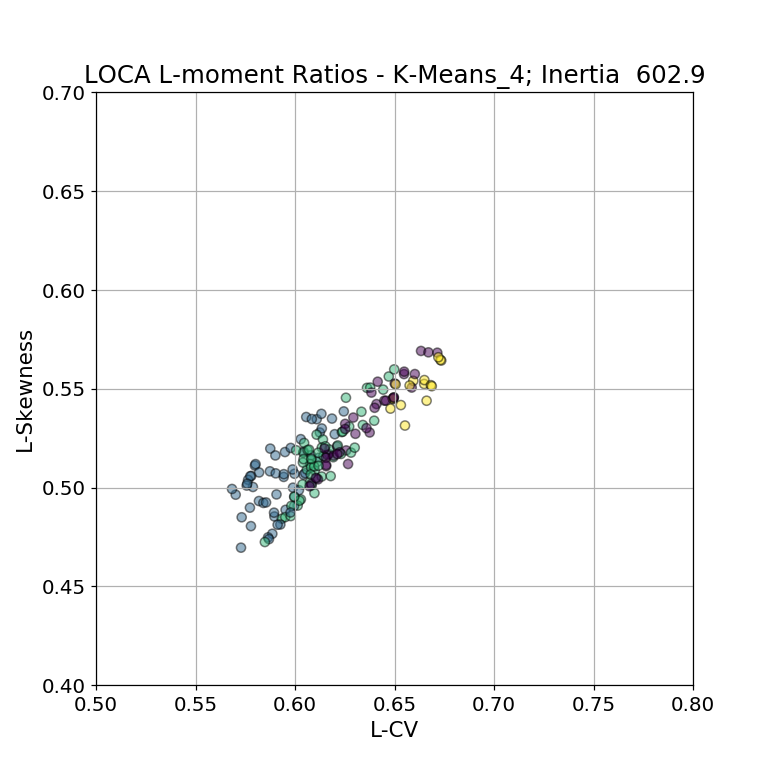

In [74]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( gpdLOBSTrackDS[LMCols[0]], gpdLOBSTrackDS[LMCols[1]], 
                      label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                      c=gpdLOBSTrackDS[CNamesList[1]] )
ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
               (CNamesList[1], LOInertiaArray[1]), fontsize=16 )
ax11.set_xlabel(r'L-CV', fontsize=14 )
ax11.set_ylabel(r'L-Skewness', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
#ax11.legend()
ax11.grid(True)

<IPython.core.display.Javascript object>


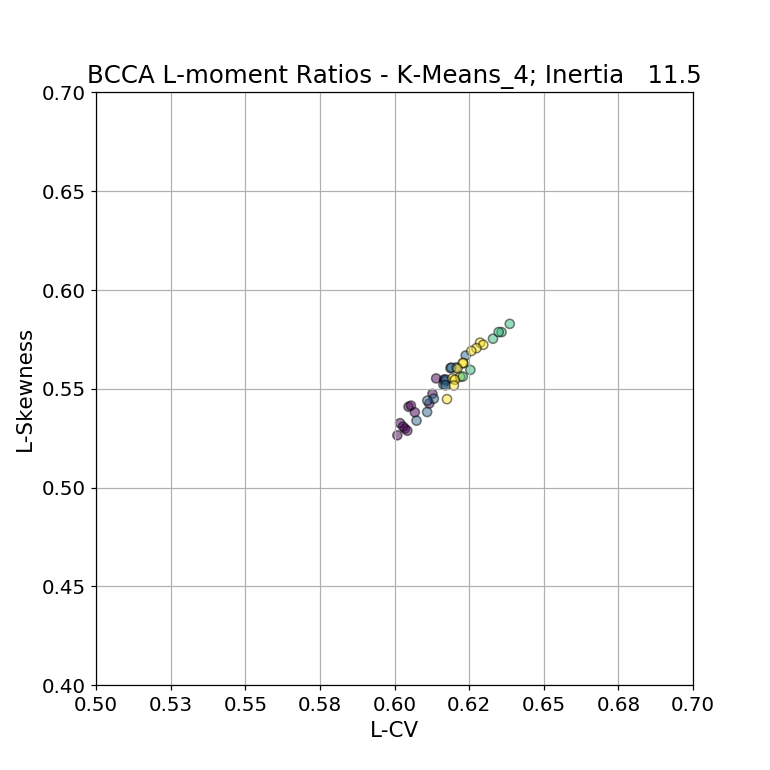

In [75]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( gpdBCBSTrackDS[LMCols[0]], gpdBCBSTrackDS[LMCols[1]], 
                      label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                      c=gpdBCBSTrackDS[CNamesList[1]] )
ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
               (CNamesList[1], BCInertiaArray[1]), fontsize=16 )
ax11.set_xlabel(r'L-CV', fontsize=14 )
ax11.set_ylabel(r'L-Skewness', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
#ax11.legend()
ax11.grid(True)

<IPython.core.display.Javascript object>


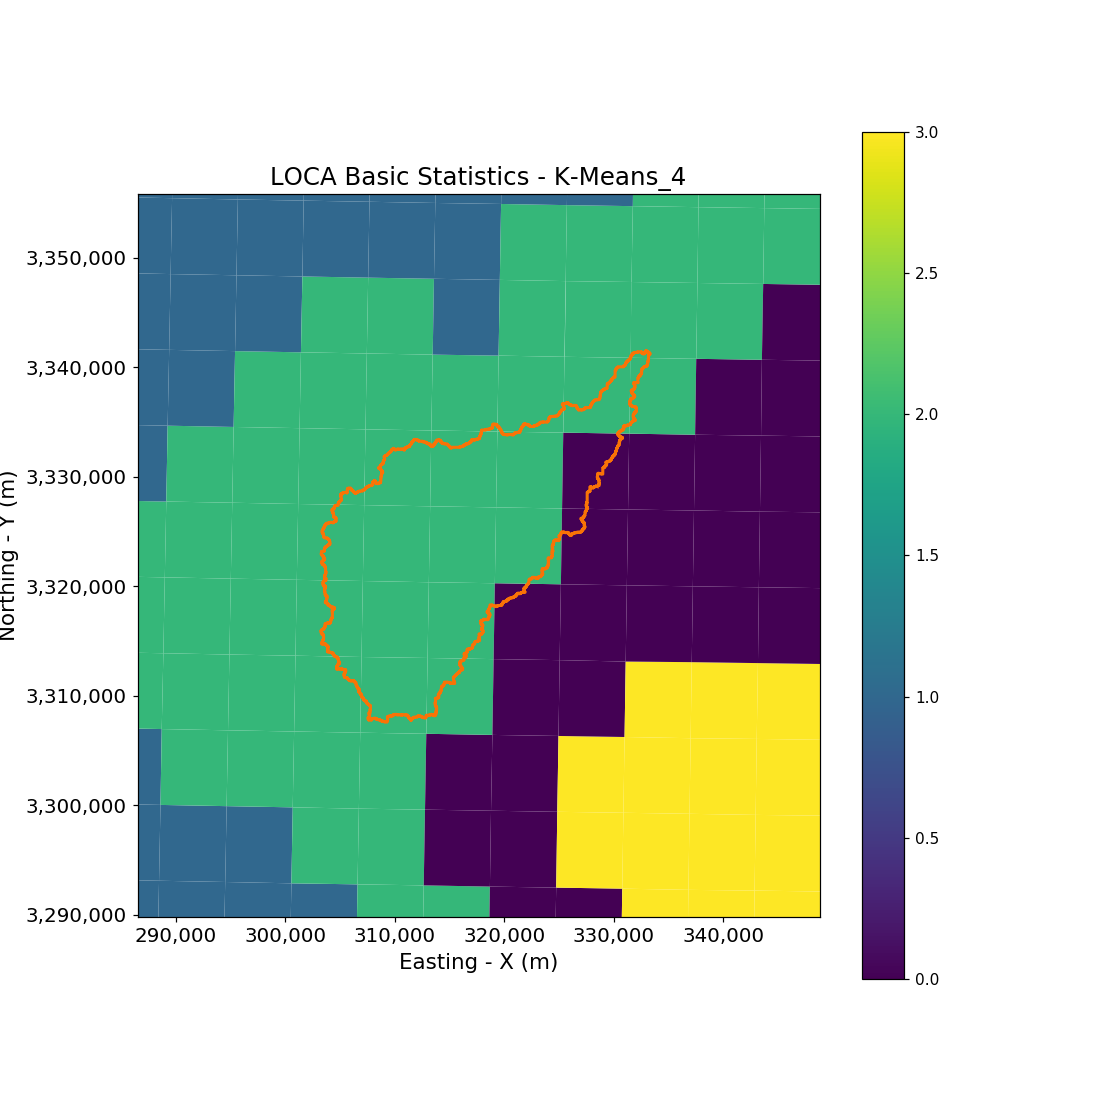

In [76]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 10.0)
ax11 = Fig1.add_subplot(111)
gpdLOBSTrackDS.plot(column=CNamesList[1], ax=ax11, legend=True )
DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, label="Watershed" )
ax11.set_xlim( ( 286500, 348800 ) )
ax11.set_ylim( ( 3289800, 3355800 ) )
ax11.set_title("LOCA Basic Statistics - %s" % CNamesList[1], fontsize=16 )
ax11.set_xlabel('Easting - X (m)', fontsize=14 )
ax11.set_ylabel('Northing - Y (m)', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )

<IPython.core.display.Javascript object>


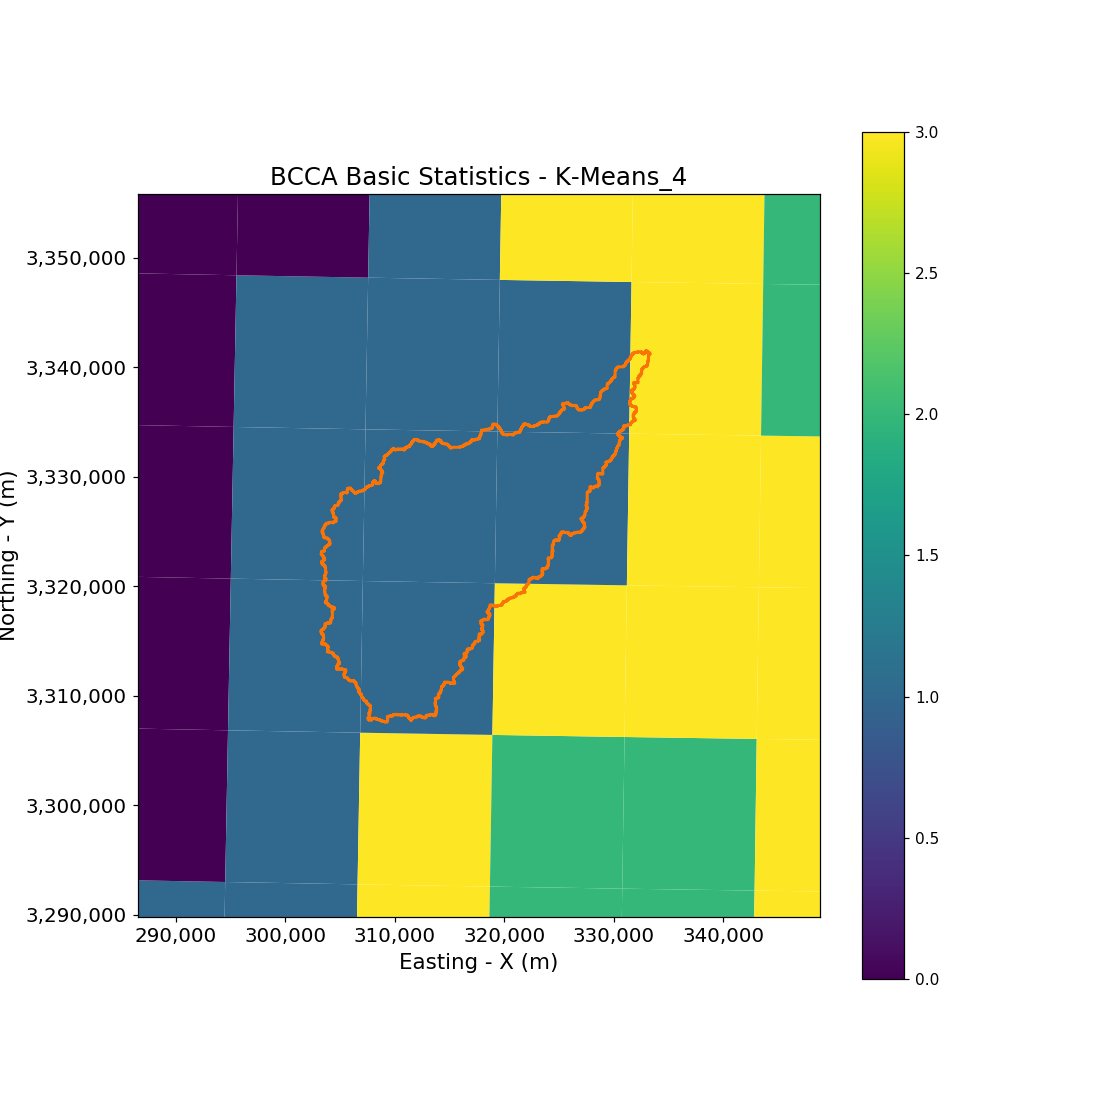

In [77]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 10.0)
ax11 = Fig1.add_subplot(111)
gpdBCBSTrackDS.plot(column=CNamesList[1], ax=ax11, legend=True )
DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, label="Watershed" )
ax11.set_xlim( ( 286500, 348800 ) )
ax11.set_ylim( ( 3289800, 3355800 ) )
ax11.set_title("BCCA Basic Statistics - %s" % CNamesList[1], fontsize=16 )
ax11.set_xlabel('Easting - X (m)', fontsize=14 )
ax11.set_ylabel('Northing - Y (m)', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )

<IPython.core.display.Javascript object>


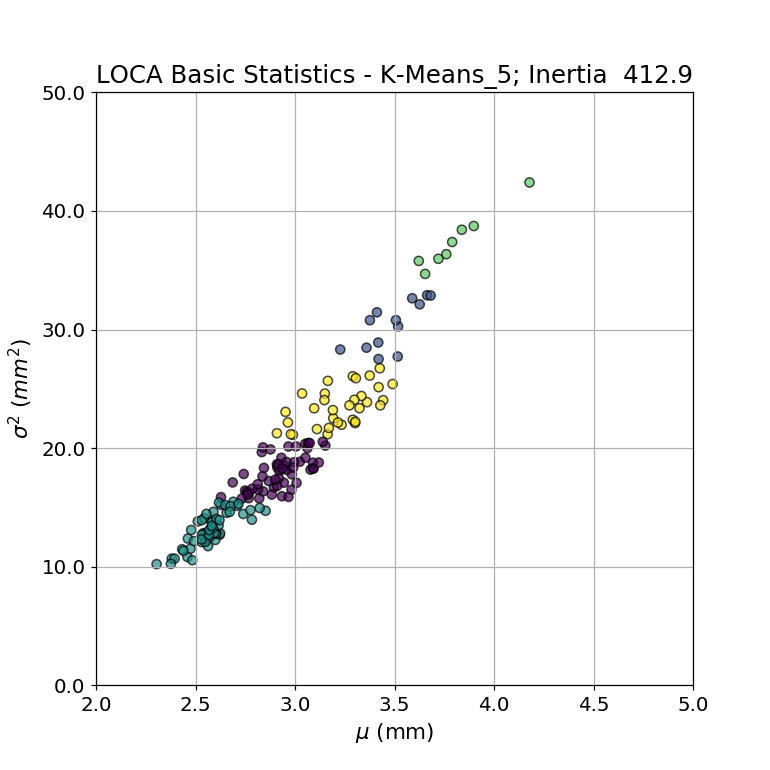

In [78]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( gpdLOBSTrackDS[BSCols[0]], gpdLOBSTrackDS[BSCols[1]], 
                      label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                      c=gpdLOBSTrackDS[CNamesList[2]] )
ax11.set_xlim( (LOMinX, LOMaxX) )
ax11.set_ylim( (LOMinY, LOMaxY) )
ax11.set_title( "LOCA Basic Statistics - %s; Inertia %6.1f" % 
               (CNamesList[2], LOInertiaArray[2]), fontsize=16 )
ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
#ax11.legend()
ax11.grid(True)

<IPython.core.display.Javascript object>


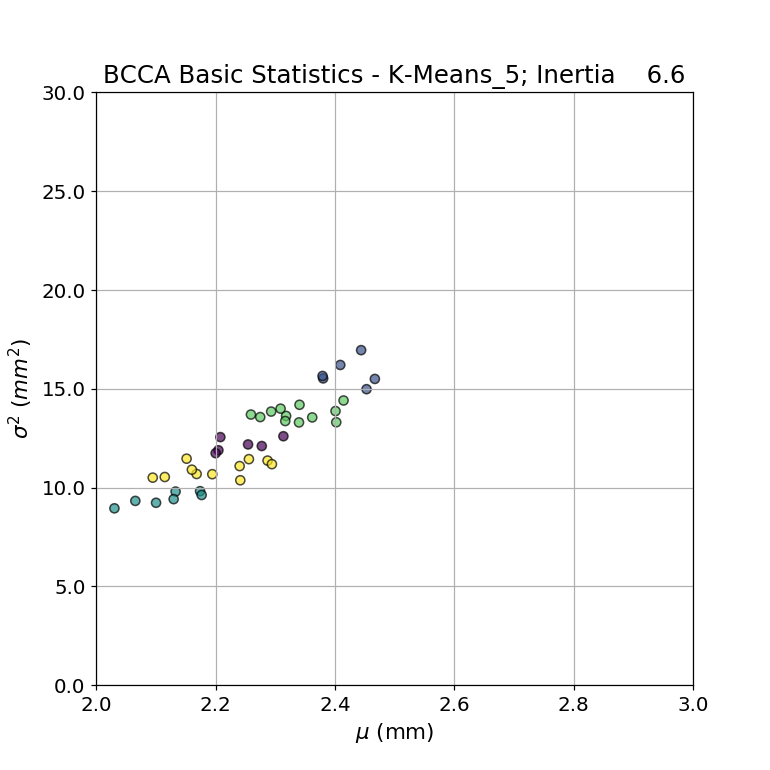

In [79]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( gpdBCBSTrackDS[BSCols[0]], gpdBCBSTrackDS[BSCols[1]], 
                      label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                      c=gpdBCBSTrackDS[CNamesList[2]] )
ax11.set_xlim( (BCMinX, BCMaxX) )
ax11.set_ylim( (BCMinY, BCMaxY) )
ax11.set_title( "BCCA Basic Statistics - %s; Inertia %6.1f" % 
               (CNamesList[2], BCInertiaArray[2]), fontsize=16 )
ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
#ax11.legend()
ax11.grid(True)

<IPython.core.display.Javascript object>


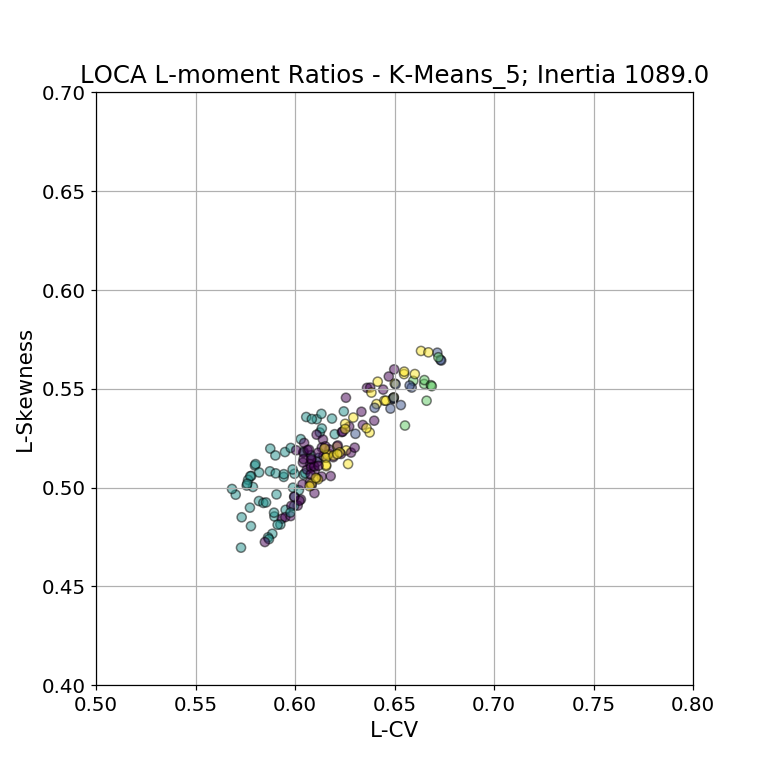

In [80]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( gpdLOBSTrackDS[LMCols[0]], gpdLOBSTrackDS[LMCols[1]], 
                      label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                      c=gpdLOBSTrackDS[CNamesList[2]] )
ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
               (CNamesList[2], LOInertiaArray[0]), fontsize=16 )
ax11.set_xlabel(r'L-CV', fontsize=14 )
ax11.set_ylabel(r'L-Skewness', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
#ax11.legend()
ax11.grid(True)

<IPython.core.display.Javascript object>


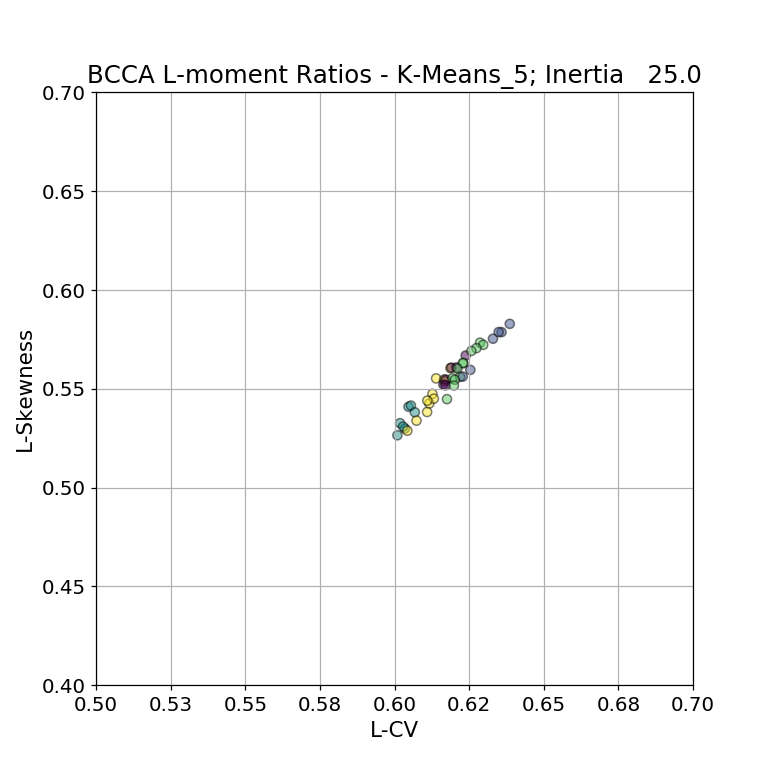

In [81]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( gpdBCBSTrackDS[LMCols[0]], gpdBCBSTrackDS[LMCols[1]], 
                      label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                      c=gpdBCBSTrackDS[CNamesList[2]] )
ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
               (CNamesList[2], BCInertiaArray[0]), fontsize=16 )
ax11.set_xlabel(r'L-CV', fontsize=14 )
ax11.set_ylabel(r'L-Skewness', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
#ax11.legend()
ax11.grid(True)

<IPython.core.display.Javascript object>


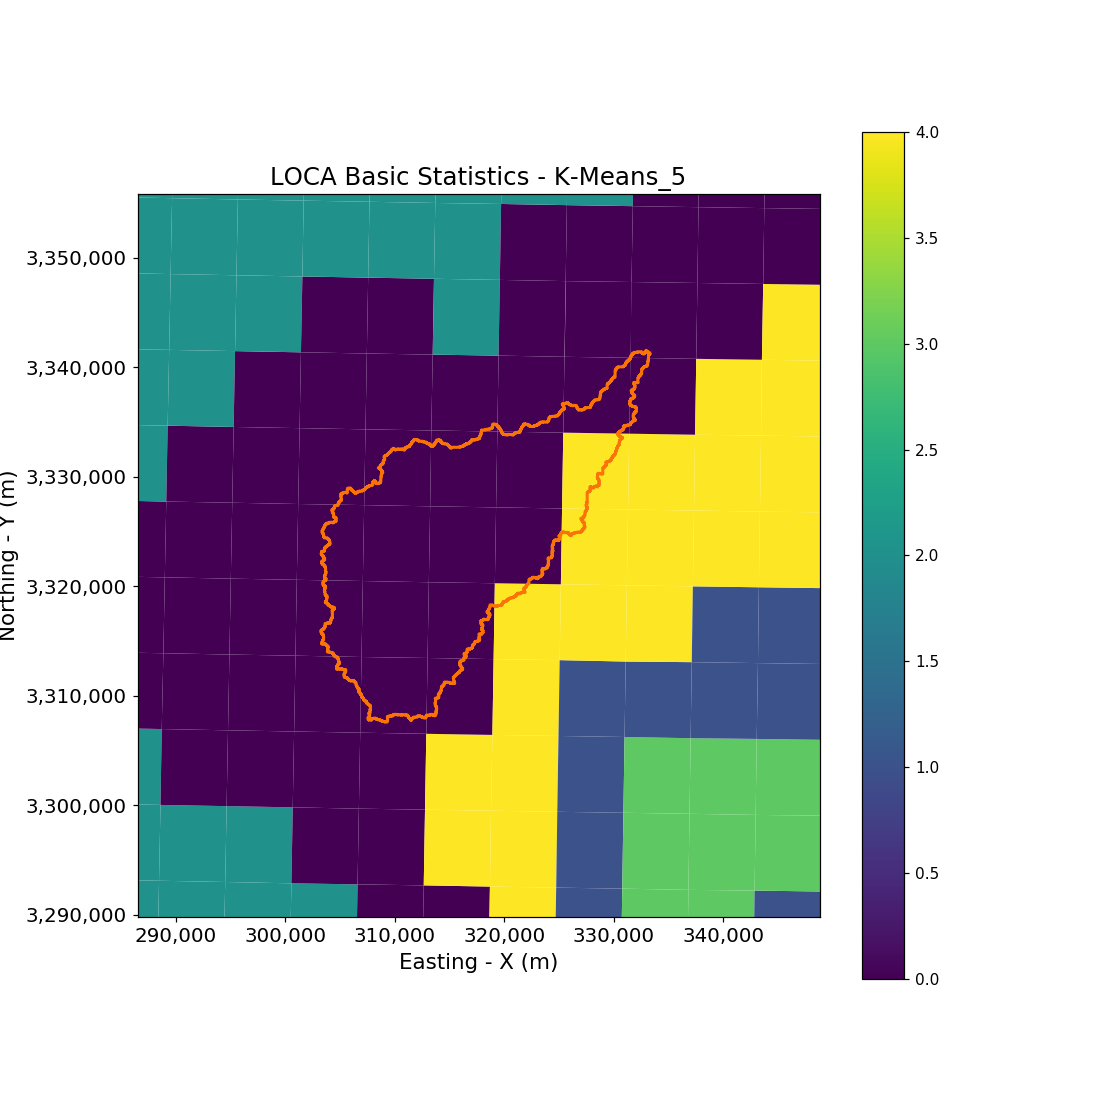

In [82]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 10.0)
ax11 = Fig1.add_subplot(111)
gpdLOBSTrackDS.plot(column=CNamesList[2], ax=ax11, legend=True )
DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, label="Watershed" )
ax11.set_xlim( ( 286500, 348800 ) )
ax11.set_ylim( ( 3289800, 3355800 ) )
ax11.set_title("LOCA Basic Statistics - %s" % CNamesList[2], fontsize=16 )
ax11.set_xlabel('Easting - X (m)', fontsize=14 )
ax11.set_ylabel('Northing - Y (m)', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )

<IPython.core.display.Javascript object>


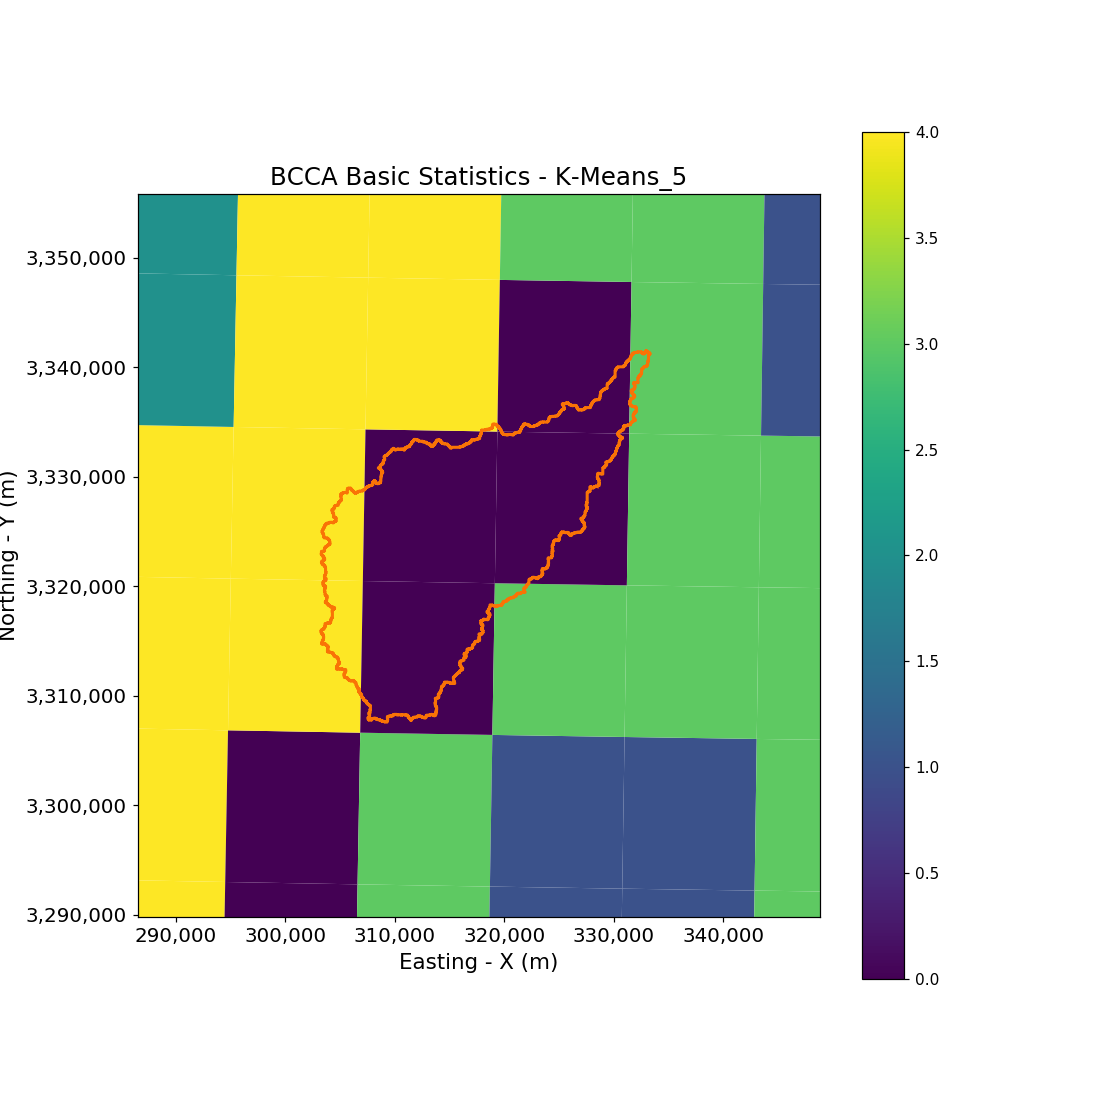

In [83]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 10.0)
ax11 = Fig1.add_subplot(111)
gpdBCBSTrackDS.plot(column=CNamesList[2], ax=ax11, legend=True )
DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, label="Watershed" )
ax11.set_xlim( ( 286500, 348800 ) )
ax11.set_ylim( ( 3289800, 3355800 ) )
ax11.set_title("BCCA Basic Statistics - %s" % CNamesList[2], fontsize=16 )
ax11.set_xlabel('Easting - X (m)', fontsize=14 )
ax11.set_ylabel('Northing - Y (m)', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )

In the above analysis, 5 clusters is too many. 3 would work fine for the area of interest which is the watershed.

#### 3 Component, PCA-Reduced Statistical Moments

Create a tracking copy DataFrame for each downscaling method.

For this one need to make the DataFrames from the numpy matrixes

In [84]:
PCAVarCols = [ "PCA_1", "PCA_2", "PCA_3" ]

In [85]:
DataDict = { PCAVarCols[0] : LOtrans3BaseStat[:, 0],
             PCAVarCols[1] : LOtrans3BaseStat[:, 1],
             PCAVarCols[2] : LOtrans3BaseStat[:, 2],
           }

In [86]:
LOPCATrackDF = pd.DataFrame( data=DataDict )

In [87]:
DataDict = { PCAVarCols[0] : BCtrans3BaseStat[:, 0],
             PCAVarCols[1] : BCtrans3BaseStat[:, 1],
             PCAVarCols[2] : BCtrans3BaseStat[:, 2],
           }

In [88]:
BCPCATrackDF = pd.DataFrame( data=DataDict )

In [89]:
LOPCATrackDF[LMCols[0]] = np.array( gpdJanDF.loc[:(BCCA_START-1), LMCols[0]], dtype=np.float32 )
LOPCATrackDF[LMCols[1]] = np.array( gpdJanDF.loc[:(BCCA_START-1), LMCols[1]], dtype=np.float32 )
BCPCATrackDF[LMCols[0]] = np.array( gpdJanDF.loc[BCCA_START:, LMCols[0]], dtype=np.float32 )
BCPCATrackDF[LMCols[1]] = np.array( gpdJanDF.loc[BCCA_START:, LMCols[1]], dtype=np.float32 )

In [90]:
display( HTML( LOPCATrackDF.head().to_html() ) )

In [91]:
display( HTML( LOPCATrackDF.head().to_html() ) )

In [92]:
gpdLOPCATrackDF = gpd.GeoDataFrame( LOPCATrackDF, geometry=PolyList[:(BCCA_START-1)] )
gpdBCPCATrackDF = gpd.GeoDataFrame( BCPCATrackDF, geometry=PolyList[(BCCA_START-1):] )
gpdLOPCATrackDF.crs = UTMCRS
gpdBCPCATrackDF.crs = UTMCRS

In [93]:
LOInertiaArray = np.zeros( len(clustEst), dtype=np.float32 )
BCInertiaArray = np.zeros( len(clustEst), dtype=np.float32 )

In [94]:
iCnt = 0
for name, cEst in clustEst:
    BCcEst = deepcopy( cEst )
    LOcBS = cEst.fit( LOtrans3BaseStat )
    BCcBS = BCcEst.fit( BCtrans3BaseStat )
    LOInertiaArray[iCnt] = LOcBS.inertia_
    BCInertiaArray[iCnt] = BCcBS.inertia_
    gpdLOPCATrackDF[name] = LOcBS.fit_predict( LOtrans3BaseStat )
    gpdBCPCATrackDF[name] = BCcBS.fit_predict( BCtrans3BaseStat )
    iCnt += 1
# end for

In [95]:
display( HTML( gpdLOPCATrackDF.head().to_html() ) )

In [96]:
display( HTML( gpdBCPCATrackDF.head().to_html() ) )

<IPython.core.display.Javascript object>


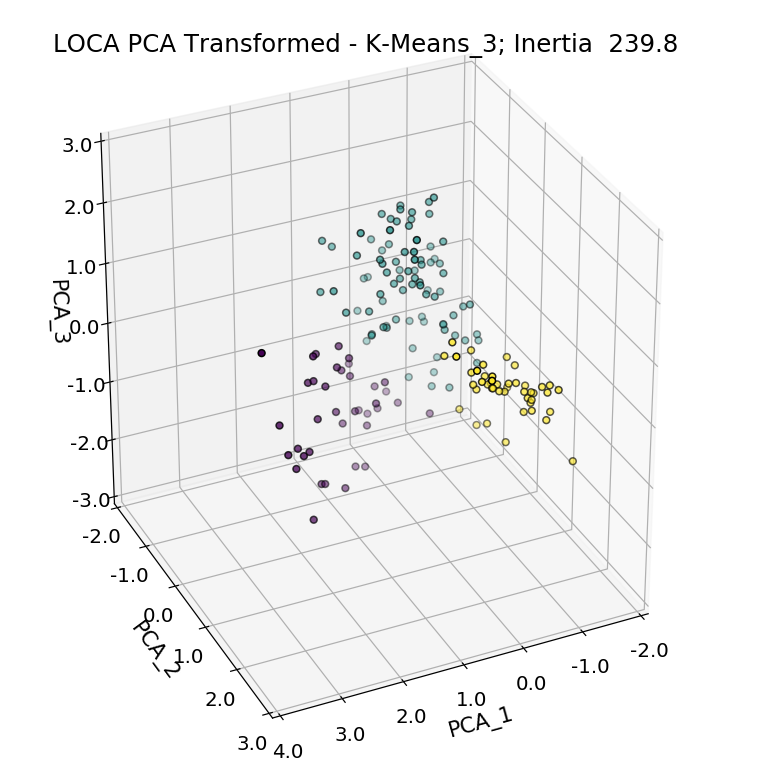

In [97]:
LOMaxX = ceil( gpdLOPCATrackDF[PCAVarCols[0]].max() )
LOMaxY = ceil( gpdLOPCATrackDF[PCAVarCols[1]].max() )
LOMaxZ = ceil( gpdLOPCATrackDF[PCAVarCols[2]].max() )
LOMinX = floor( gpdLOPCATrackDF[PCAVarCols[0]].min() )
LOMinY = floor( gpdLOPCATrackDF[PCAVarCols[1]].min() )
LOMinZ = floor( gpdLOPCATrackDF[PCAVarCols[2]].min() )
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
ax11.scatter( gpdLOPCATrackDF[PCAVarCols[0]], gpdLOPCATrackDF[PCAVarCols[1]], 
              gpdLOPCATrackDF[PCAVarCols[2]], edgecolor='k', 
              c=gpdLOPCATrackDF[CNamesList[0]])
ax11.set_xlim( (LOMinX, LOMaxX) )
ax11.set_ylim( (LOMinY, LOMaxY) )
ax11.set_zlim( (LOMinZ, LOMaxZ) )
ax11.set_title( "LOCA PCA Transformed - %s; Inertia %6.1f" % 
               ( CNamesList[0], LOInertiaArray[0] ), fontsize=16 )
ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )

<IPython.core.display.Javascript object>


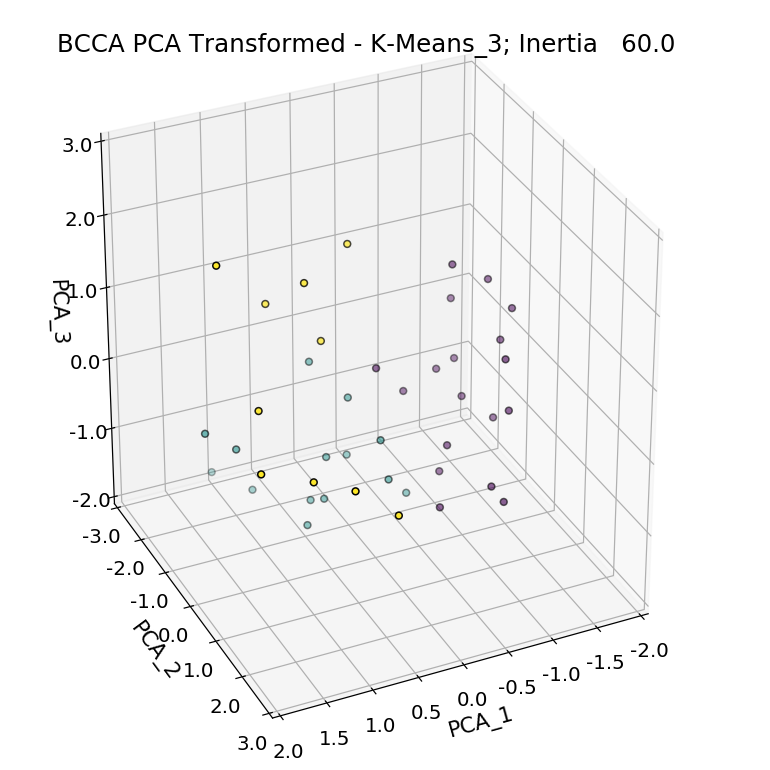

In [98]:
BCMaxX = ceil( gpdBCPCATrackDF[PCAVarCols[0]].max() )
BCMaxY = ceil( gpdBCPCATrackDF[PCAVarCols[1]].max() )
BCMaxZ = ceil( gpdBCPCATrackDF[PCAVarCols[2]].max() )
BCMinX = floor( gpdBCPCATrackDF[PCAVarCols[0]].min() )
BCMinY = floor( gpdBCPCATrackDF[PCAVarCols[1]].min() )
BCMinZ = floor( gpdBCPCATrackDF[PCAVarCols[2]].min() )
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
ax11.scatter( gpdBCPCATrackDF[PCAVarCols[0]], gpdBCPCATrackDF[PCAVarCols[1]], 
              gpdBCPCATrackDF[PCAVarCols[2]], edgecolor='k', 
              c=gpdBCPCATrackDF[CNamesList[0]])
ax11.set_xlim( (BCMinX, BCMaxX) )
ax11.set_ylim( (BCMinY, BCMaxY) )
ax11.set_zlim( (BCMinZ, BCMaxZ) )
ax11.set_title( "BCCA PCA Transformed - %s; Inertia %6.1f" % 
               ( CNamesList[0], BCInertiaArray[0] ), fontsize=16 )
ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )

<IPython.core.display.Javascript object>


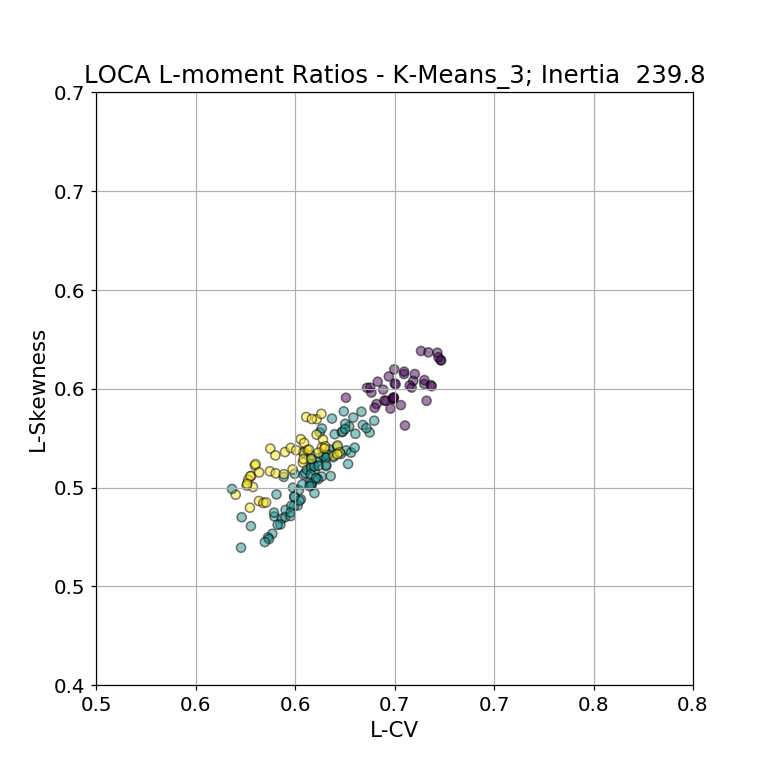

In [99]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( gpdLOPCATrackDF[LMCols[0]], gpdLOPCATrackDF[LMCols[1]], 
                      label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                      c=gpdLOPCATrackDF[CNamesList[0]] )
ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
               (CNamesList[0], LOInertiaArray[0]), fontsize=16 )
ax11.set_xlabel(r'L-CV', fontsize=14 )
ax11.set_ylabel(r'L-Skewness', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
#ax11.legend()
ax11.grid(True)

<IPython.core.display.Javascript object>


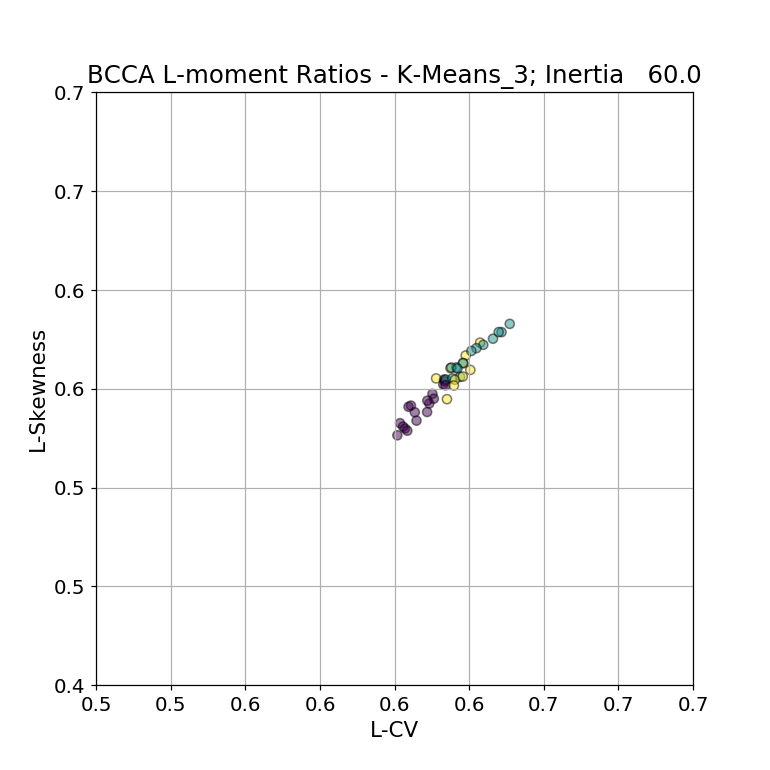

In [100]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( gpdBCPCATrackDF[LMCols[0]], gpdBCPCATrackDF[LMCols[1]], 
                      label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                      c=gpdBCPCATrackDF[CNamesList[0]] )
ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
               (CNamesList[0], BCInertiaArray[0]), fontsize=16 )
ax11.set_xlabel(r'L-CV', fontsize=14 )
ax11.set_ylabel(r'L-Skewness', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
#ax11.legend()
ax11.grid(True)

<IPython.core.display.Javascript object>


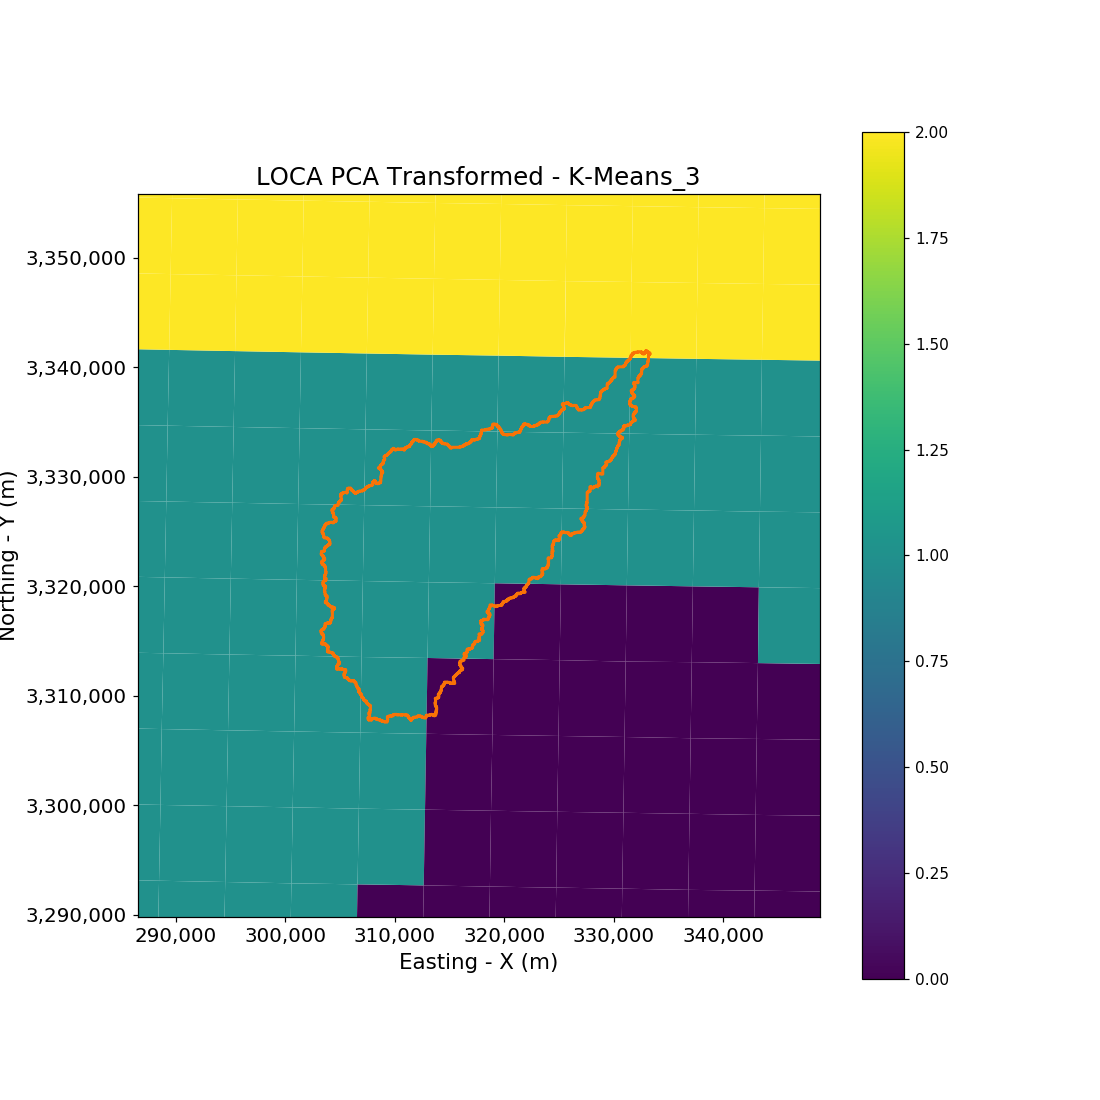

In [101]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 10.0)
ax11 = Fig1.add_subplot(111)
gpdLOPCATrackDF.plot(column=CNamesList[0], ax=ax11, legend=True )
DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, label="Watershed" )
ax11.set_xlim( ( 286500, 348800 ) )
ax11.set_ylim( ( 3289800, 3355800 ) )
ax11.set_title("LOCA PCA Transformed - %s" % CNamesList[0], fontsize=16 )
ax11.set_xlabel('Easting - X (m)', fontsize=14 )
ax11.set_ylabel('Northing - Y (m)', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )

<IPython.core.display.Javascript object>


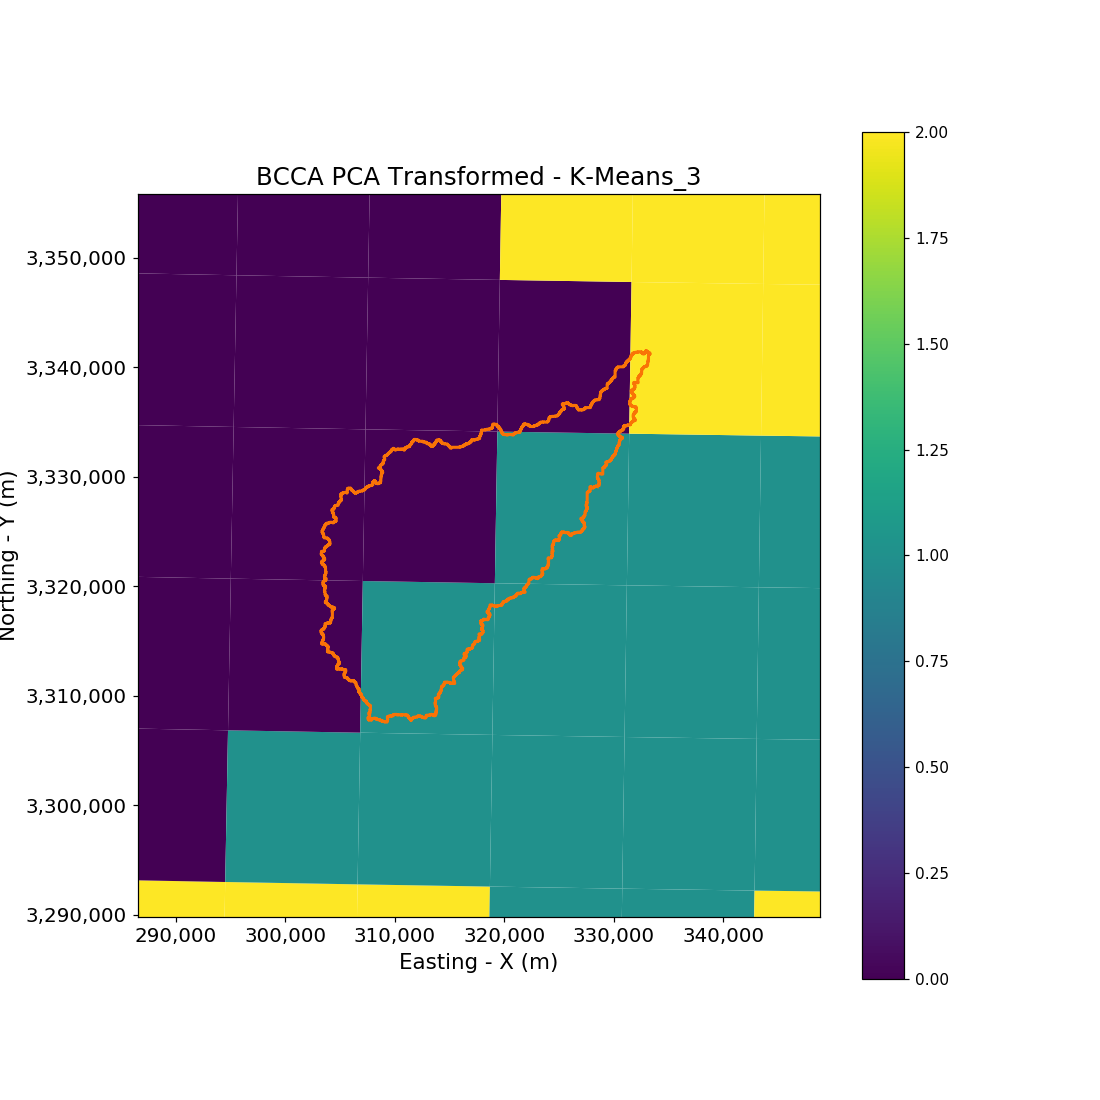

In [102]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 10.0)
ax11 = Fig1.add_subplot(111)
gpdBCPCATrackDF.plot(column=CNamesList[0], ax=ax11, legend=True )
DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, label="Watershed" )
ax11.set_xlim( ( 286500, 348800 ) )
ax11.set_ylim( ( 3289800, 3355800 ) )
ax11.set_title("BCCA PCA Transformed - %s" % CNamesList[0], fontsize=16 )
ax11.set_xlabel('Easting - X (m)', fontsize=14 )
ax11.set_ylabel('Northing - Y (m)', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )

<IPython.core.display.Javascript object>


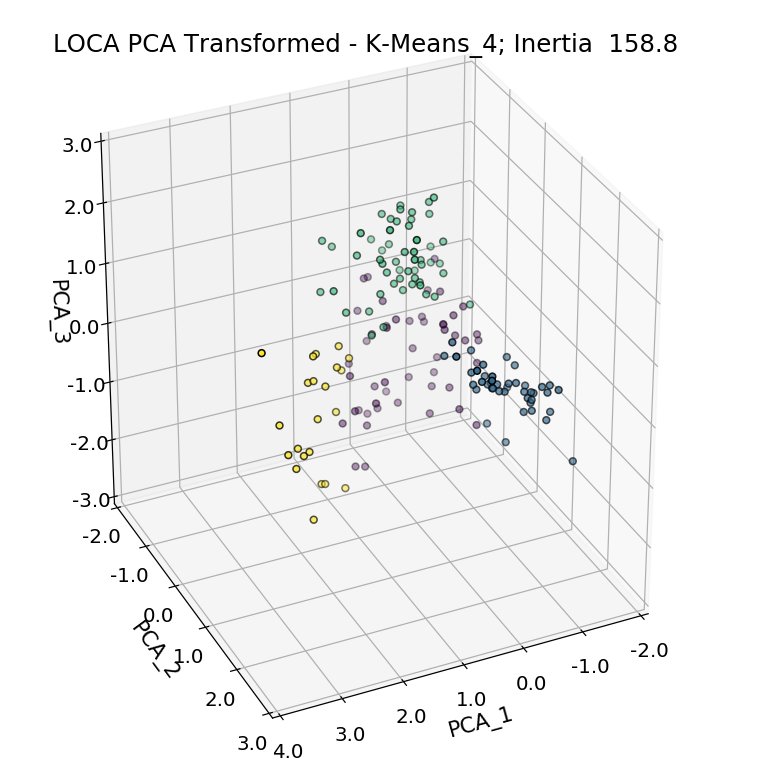

In [103]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
ax11.scatter( gpdLOPCATrackDF[PCAVarCols[0]], gpdLOPCATrackDF[PCAVarCols[1]], 
              gpdLOPCATrackDF[PCAVarCols[2]], edgecolor='k', 
              c=gpdLOPCATrackDF[CNamesList[1]])
ax11.set_xlim( (LOMinX, LOMaxX) )
ax11.set_ylim( (LOMinY, LOMaxY) )
ax11.set_zlim( (LOMinZ, LOMaxZ) )
ax11.set_title( "LOCA PCA Transformed - %s; Inertia %6.1f" % 
               ( CNamesList[1], LOInertiaArray[1] ), fontsize=16 )
ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )

<IPython.core.display.Javascript object>


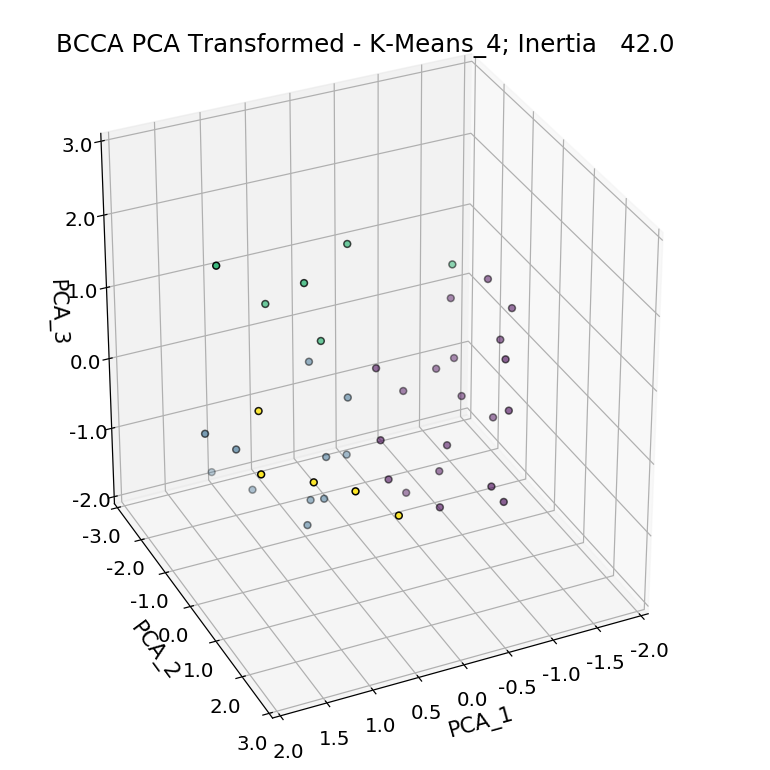

In [104]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
ax11.scatter( gpdBCPCATrackDF[PCAVarCols[0]], gpdBCPCATrackDF[PCAVarCols[1]], 
              gpdBCPCATrackDF[PCAVarCols[2]], edgecolor='k', 
              c=gpdBCPCATrackDF[CNamesList[1]])
ax11.set_xlim( (BCMinX, BCMaxX) )
ax11.set_ylim( (BCMinY, BCMaxY) )
ax11.set_zlim( (BCMinZ, BCMaxZ) )
ax11.set_title( "BCCA PCA Transformed - %s; Inertia %6.1f" % 
               ( CNamesList[1], BCInertiaArray[1] ), fontsize=16 )
ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )

<IPython.core.display.Javascript object>


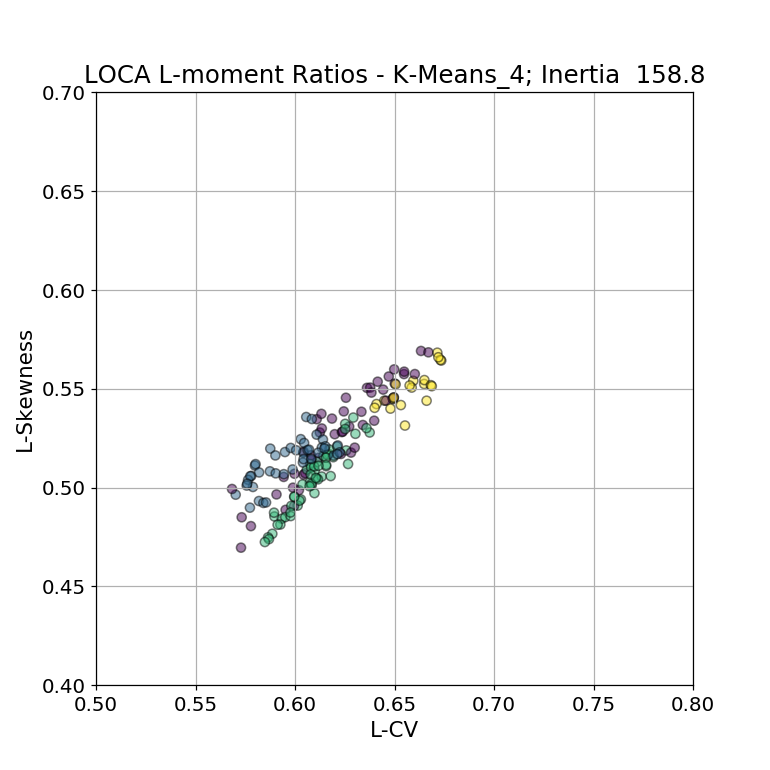

In [105]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( gpdLOPCATrackDF[LMCols[0]], gpdLOPCATrackDF[LMCols[1]], 
                      label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                      c=gpdLOPCATrackDF[CNamesList[1]] )
ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
               (CNamesList[1], LOInertiaArray[1]), fontsize=16 )
ax11.set_xlabel(r'L-CV', fontsize=14 )
ax11.set_ylabel(r'L-Skewness', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
#ax11.legend()
ax11.grid(True)

<IPython.core.display.Javascript object>


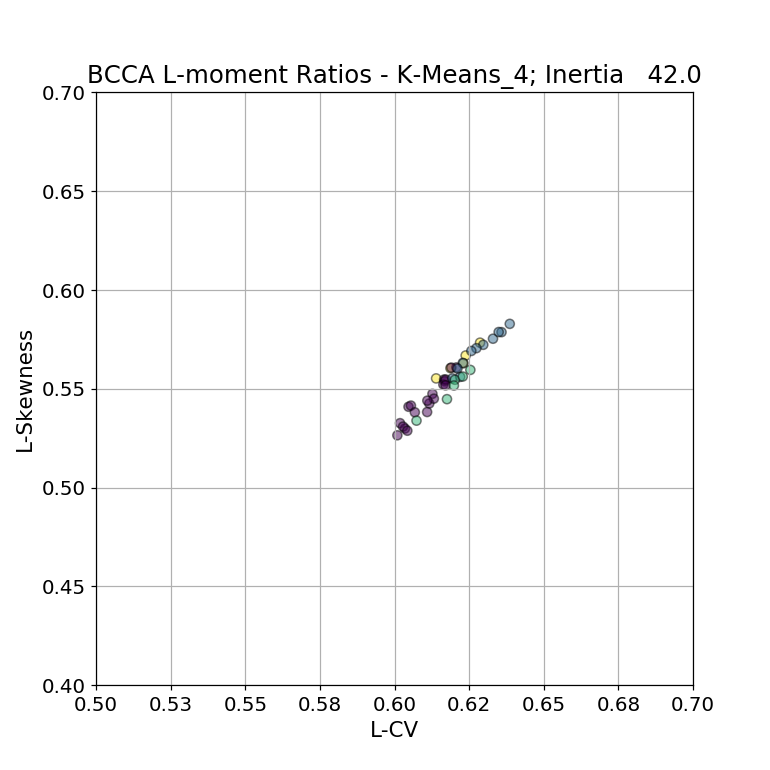

In [106]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( gpdBCPCATrackDF[LMCols[0]], gpdBCPCATrackDF[LMCols[1]], 
                      label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                      c=gpdBCPCATrackDF[CNamesList[1]] )
ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
               (CNamesList[1], BCInertiaArray[1]), fontsize=16 )
ax11.set_xlabel(r'L-CV', fontsize=14 )
ax11.set_ylabel(r'L-Skewness', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
#ax11.legend()
ax11.grid(True)

<IPython.core.display.Javascript object>


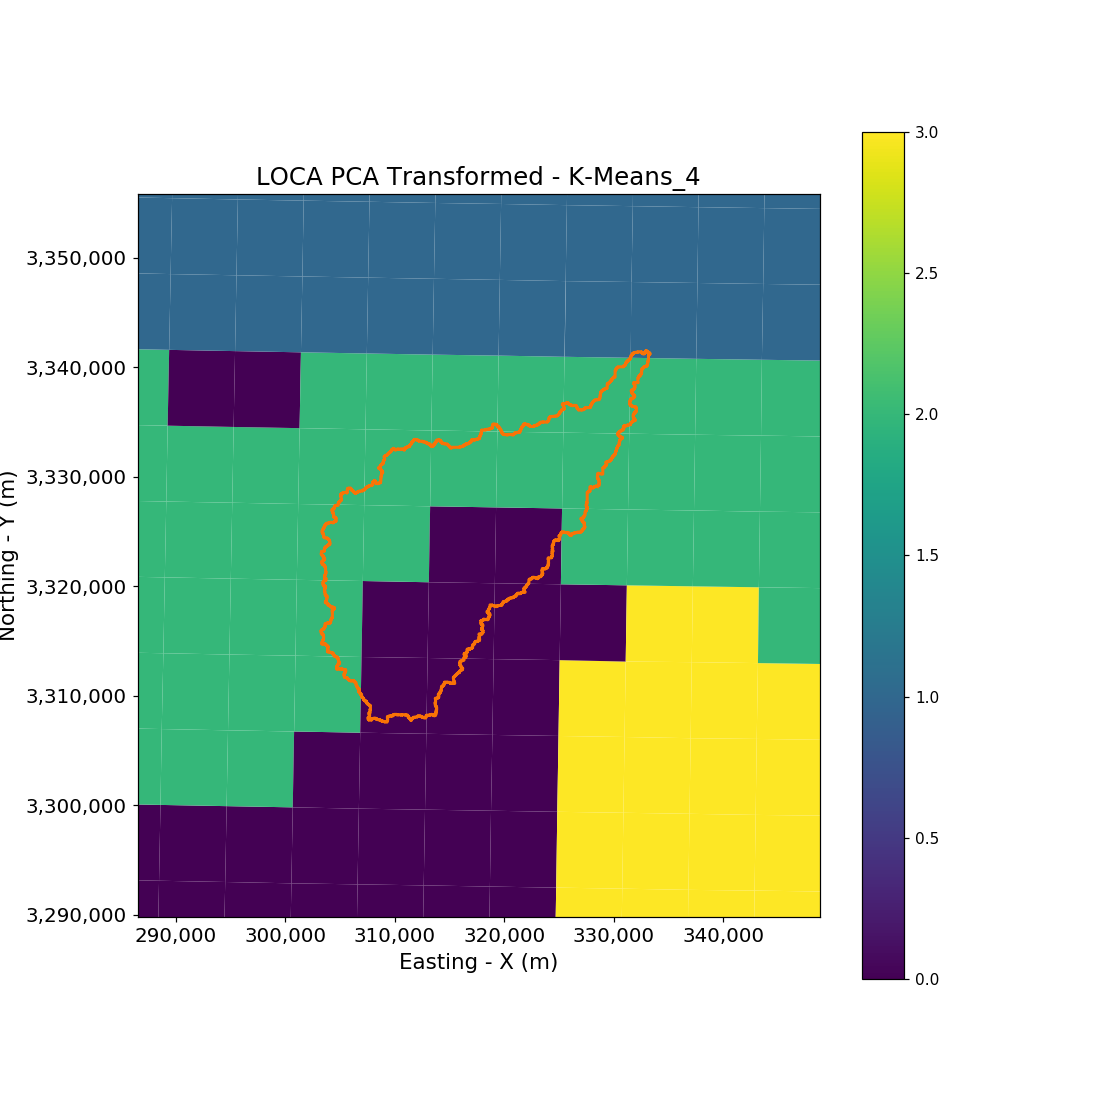

In [107]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 10.0)
ax11 = Fig1.add_subplot(111)
gpdLOPCATrackDF.plot(column=CNamesList[1], ax=ax11, legend=True )
DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, label="Watershed" )
ax11.set_xlim( ( 286500, 348800 ) )
ax11.set_ylim( ( 3289800, 3355800 ) )
ax11.set_title("LOCA PCA Transformed - %s" % CNamesList[1], fontsize=16 )
ax11.set_xlabel('Easting - X (m)', fontsize=14 )
ax11.set_ylabel('Northing - Y (m)', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )

<IPython.core.display.Javascript object>


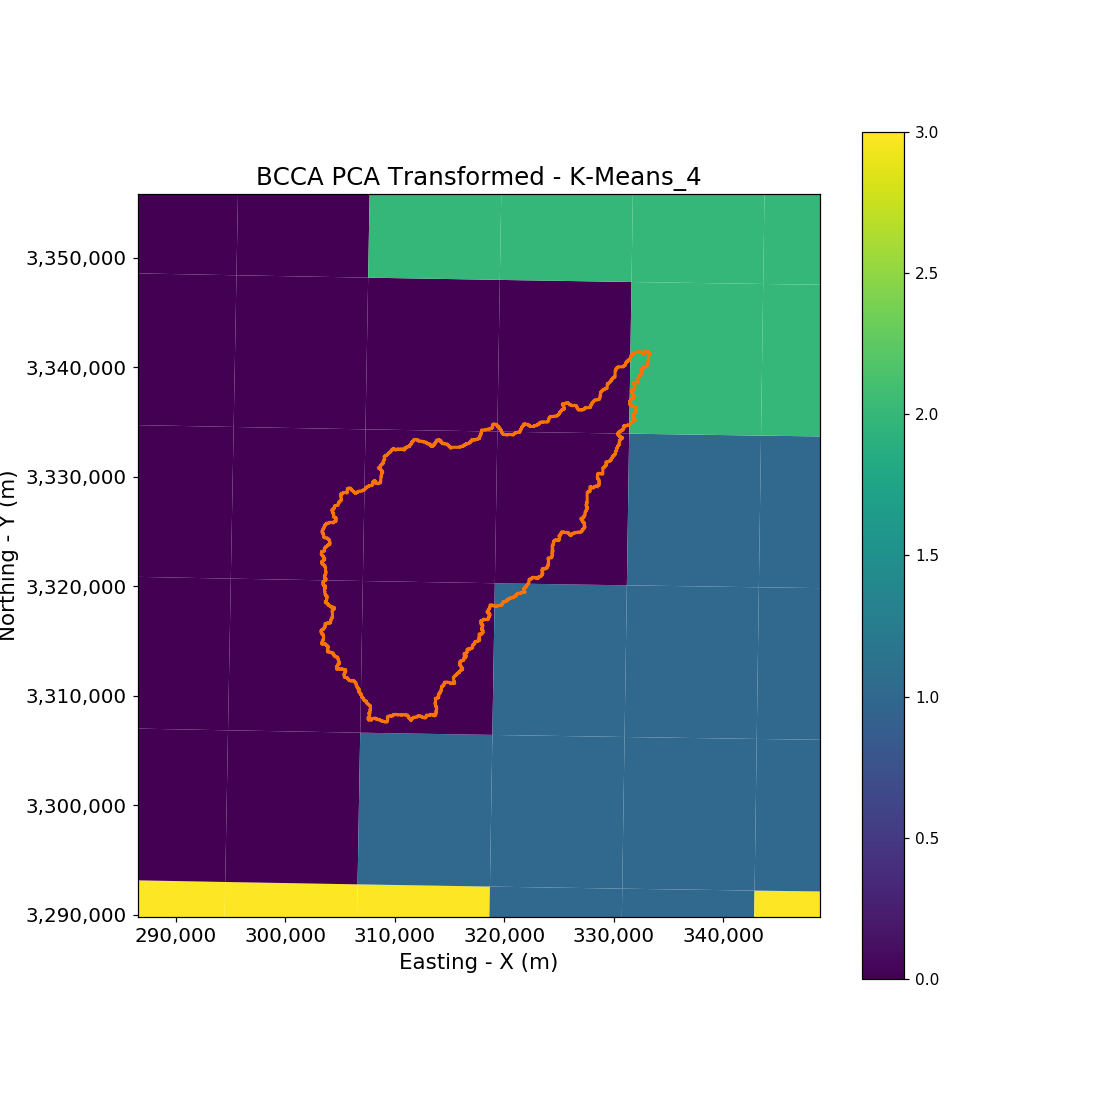

In [108]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 10.0)
ax11 = Fig1.add_subplot(111)
gpdBCPCATrackDF.plot(column=CNamesList[1], ax=ax11, legend=True )
DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, label="Watershed" )
ax11.set_xlim( ( 286500, 348800 ) )
ax11.set_ylim( ( 3289800, 3355800 ) )
ax11.set_title("BCCA PCA Transformed - %s" % CNamesList[1], fontsize=16 )
ax11.set_xlabel('Easting - X (m)', fontsize=14 )
ax11.set_ylabel('Northing - Y (m)', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )

<IPython.core.display.Javascript object>


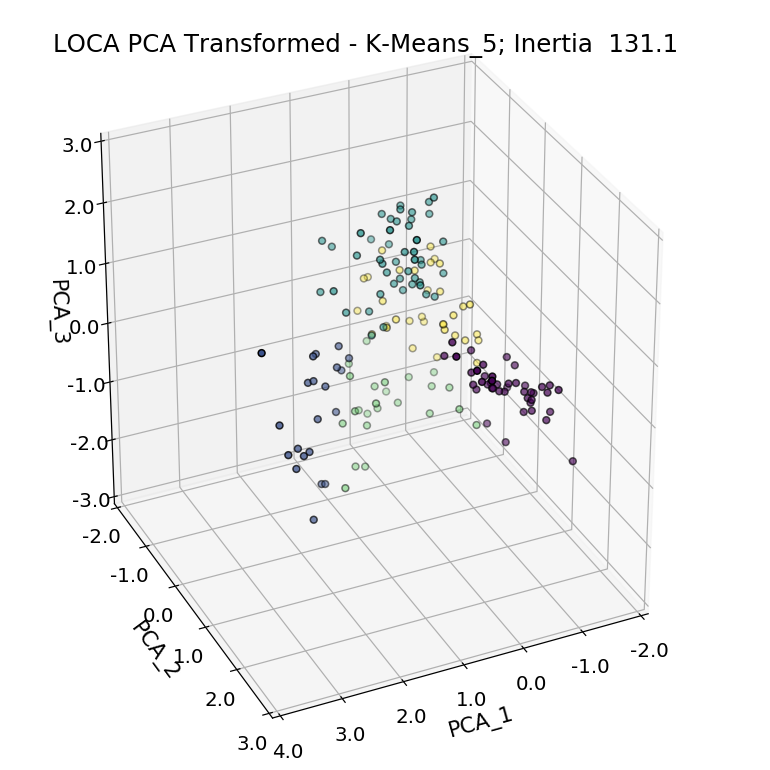

In [109]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
ax11.scatter( gpdLOPCATrackDF[PCAVarCols[0]], gpdLOPCATrackDF[PCAVarCols[1]], 
              gpdLOPCATrackDF[PCAVarCols[2]], edgecolor='k', 
              c=gpdLOPCATrackDF[CNamesList[2]])
ax11.set_xlim( (LOMinX, LOMaxX) )
ax11.set_ylim( (LOMinY, LOMaxY) )
ax11.set_zlim( (LOMinZ, LOMaxZ) )
ax11.set_title( "LOCA PCA Transformed - %s; Inertia %6.1f" % 
               ( CNamesList[2], LOInertiaArray[2] ), fontsize=16 )
ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )

<IPython.core.display.Javascript object>


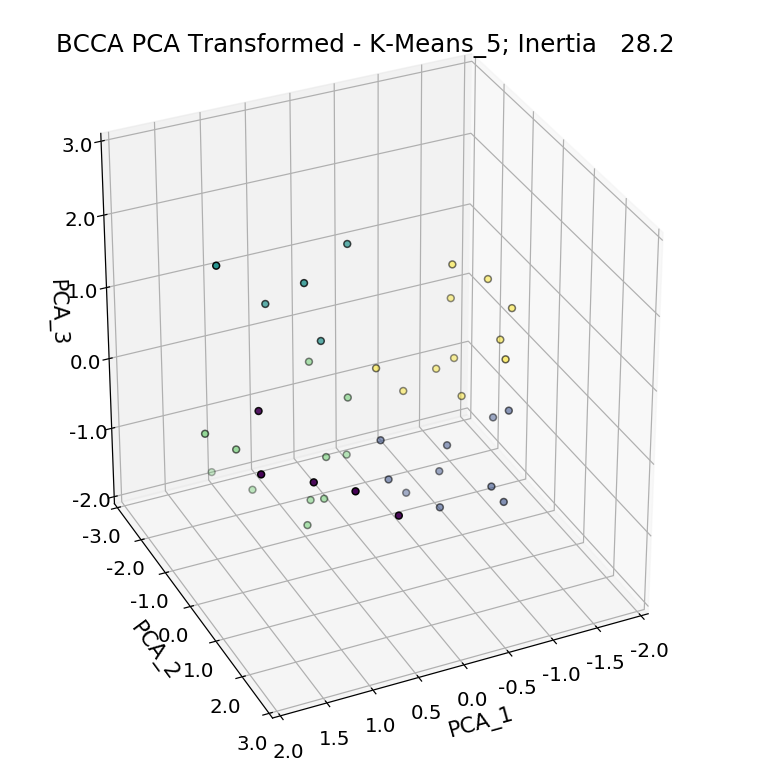

In [110]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
ax11.scatter( gpdBCPCATrackDF[PCAVarCols[0]], gpdBCPCATrackDF[PCAVarCols[1]], 
              gpdBCPCATrackDF[PCAVarCols[2]], edgecolor='k', 
              c=gpdBCPCATrackDF[CNamesList[2]])
ax11.set_xlim( (BCMinX, BCMaxX) )
ax11.set_ylim( (BCMinY, BCMaxY) )
ax11.set_zlim( (BCMinZ, BCMaxZ) )
ax11.set_title( "BCCA PCA Transformed - %s; Inertia %6.1f" % 
               ( CNamesList[2], BCInertiaArray[2] ), fontsize=16 )
ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )

<IPython.core.display.Javascript object>


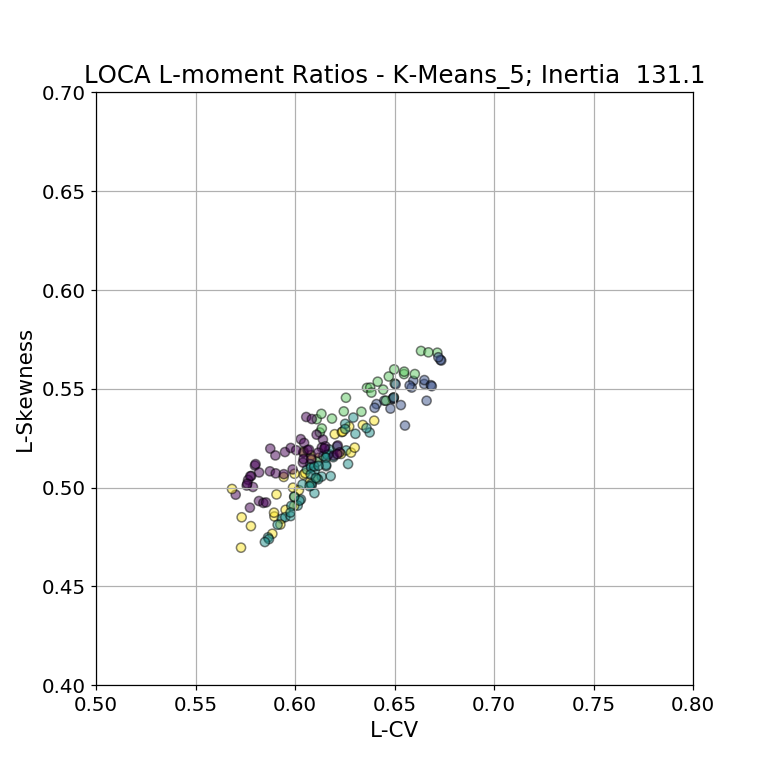

In [111]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( gpdLOPCATrackDF[LMCols[0]], gpdLOPCATrackDF[LMCols[1]], 
                      label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                      c=gpdLOPCATrackDF[CNamesList[2]] )
ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
               (CNamesList[2], LOInertiaArray[2]), fontsize=16 )
ax11.set_xlabel(r'L-CV', fontsize=14 )
ax11.set_ylabel(r'L-Skewness', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
#ax11.legend()
ax11.grid(True)

<IPython.core.display.Javascript object>


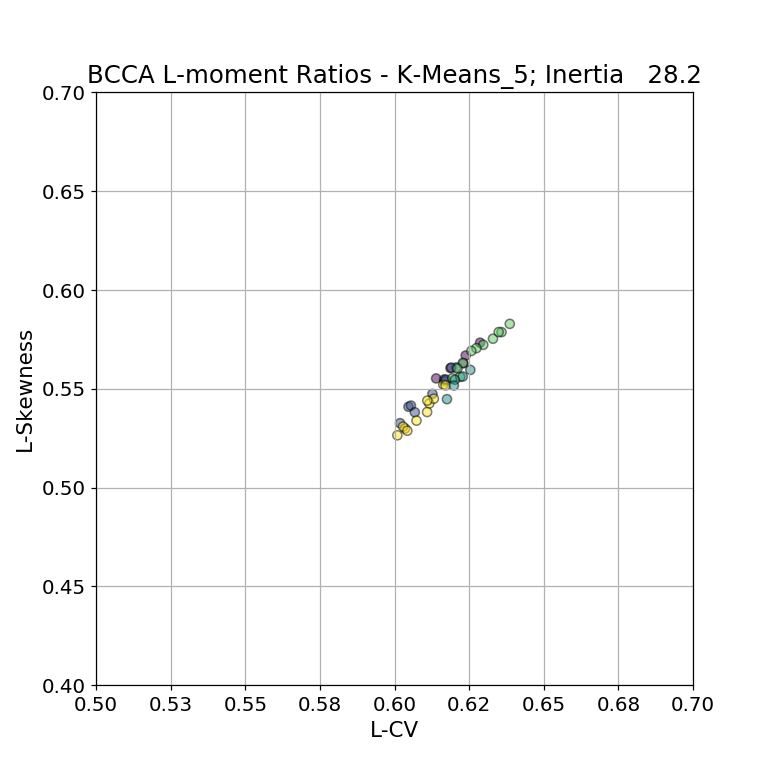

In [112]:
Fig1 = plt.figure()
Fig1.set_size_inches(7.0, 7.0)
ax11 = Fig1.add_subplot(111)
tVar1 = ax11.scatter( gpdBCPCATrackDF[LMCols[0]], gpdBCPCATrackDF[LMCols[1]], 
                      label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                      c=gpdBCPCATrackDF[CNamesList[2]] )
ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
               (CNamesList[2], BCInertiaArray[2]), fontsize=16 )
ax11.set_xlabel(r'L-CV', fontsize=14 )
ax11.set_ylabel(r'L-Skewness', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
#ax11.legend()
ax11.grid(True)

<IPython.core.display.Javascript object>


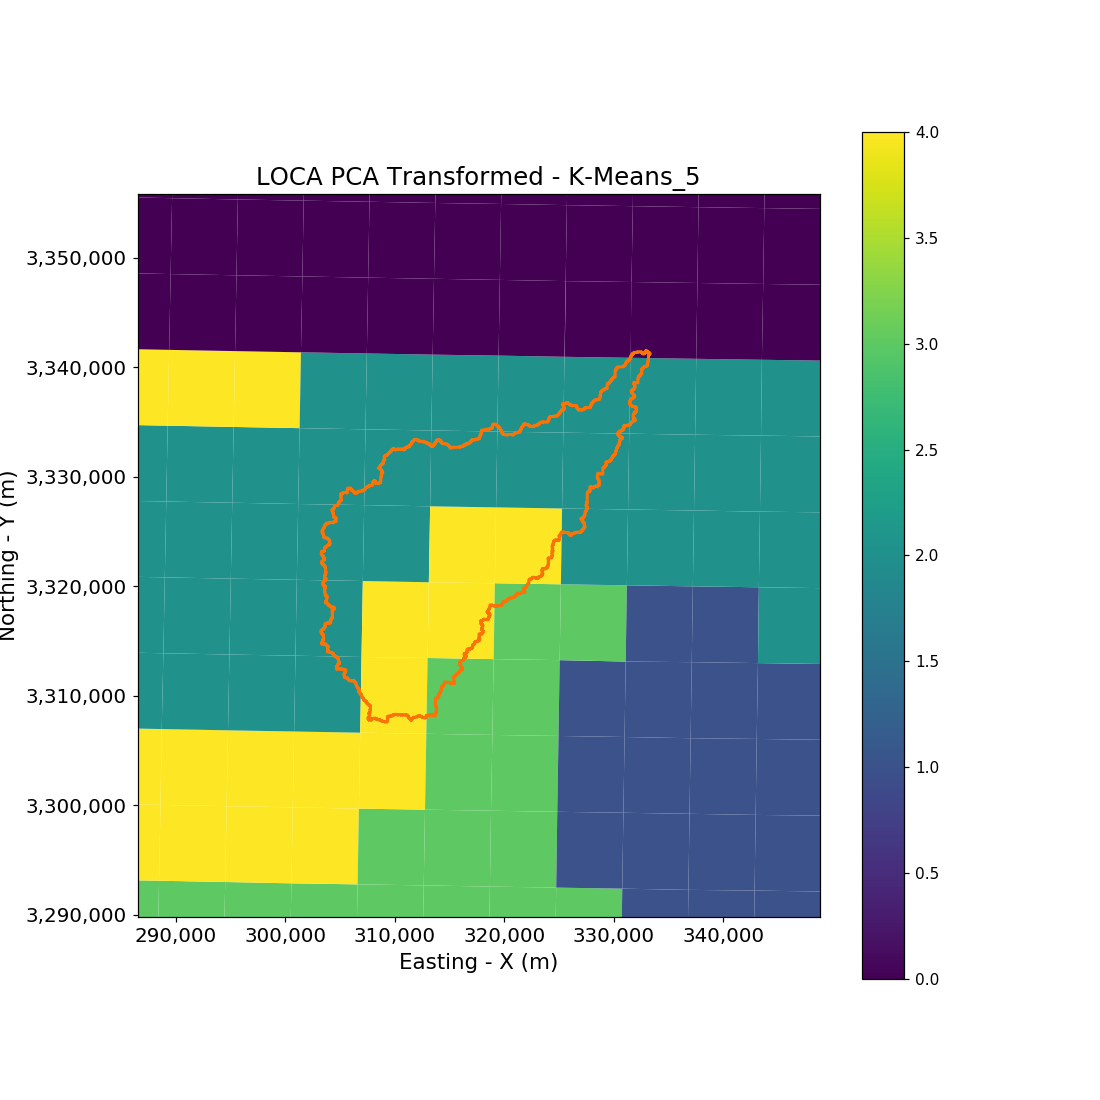

In [113]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 10.0)
ax11 = Fig1.add_subplot(111)
gpdLOPCATrackDF.plot(column=CNamesList[2], ax=ax11, legend=True )
DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, label="Watershed" )
ax11.set_xlim( ( 286500, 348800 ) )
ax11.set_ylim( ( 3289800, 3355800 ) )
ax11.set_title("LOCA PCA Transformed - %s" % CNamesList[2], fontsize=16 )
ax11.set_xlabel('Easting - X (m)', fontsize=14 )
ax11.set_ylabel('Northing - Y (m)', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )

<IPython.core.display.Javascript object>


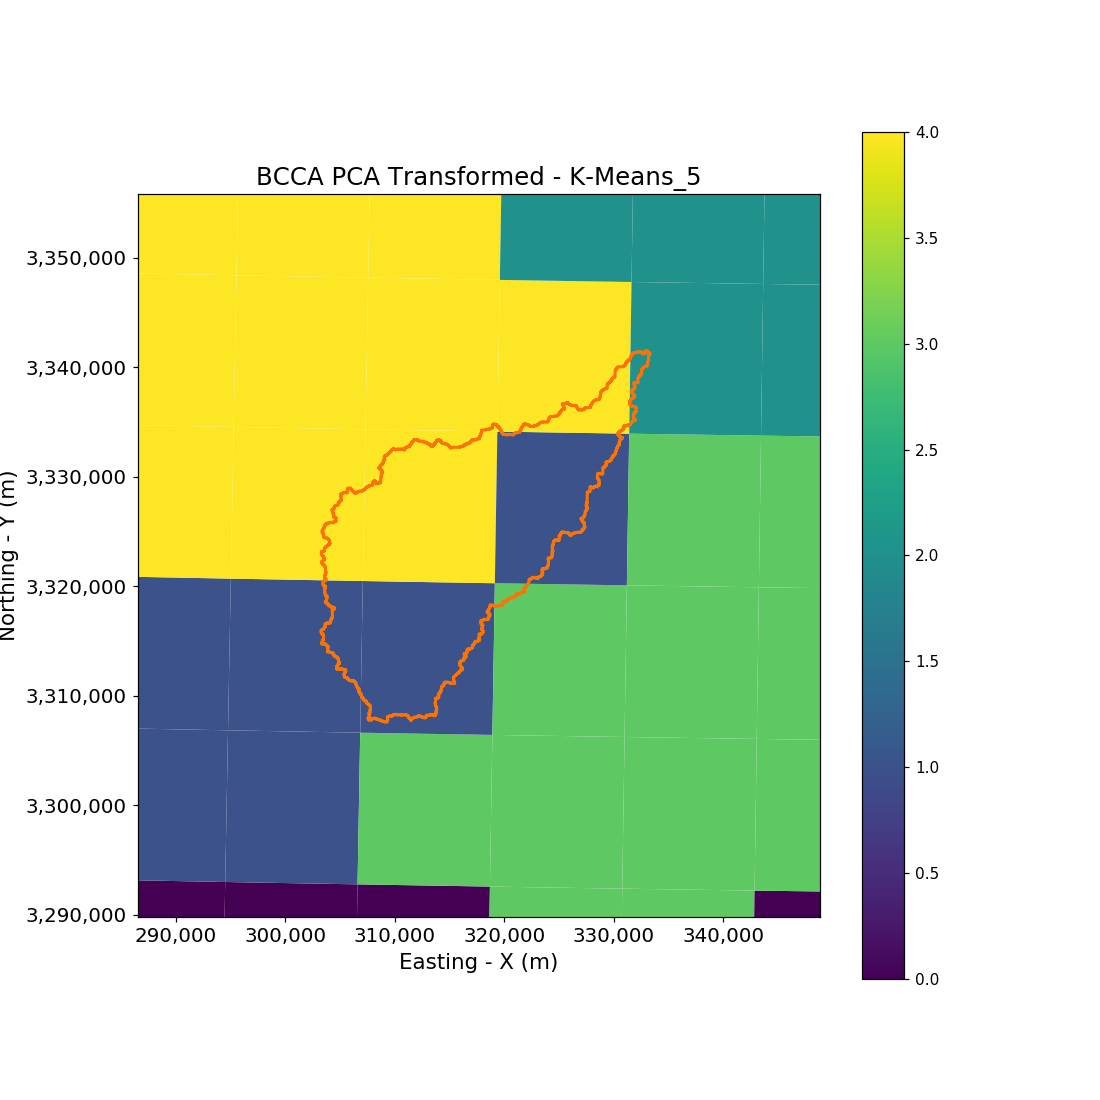

In [114]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 10.0)
ax11 = Fig1.add_subplot(111)
gpdBCPCATrackDF.plot(column=CNamesList[2], ax=ax11, legend=True )
DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, label="Watershed" )
ax11.set_xlim( ( 286500, 348800 ) )
ax11.set_ylim( ( 3289800, 3355800 ) )
ax11.set_title("BCCA PCA Transformed - %s" % CNamesList[2], fontsize=16 )
ax11.set_xlabel('Easting - X (m)', fontsize=14 )
ax11.set_ylabel('Northing - Y (m)', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=13)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )

For the CMIP5 results, we try in the regionalization to enforce the PRISM categories/groups for this data period.

## All Months

Use what was learned from working on January to generate a loop to go through all months and output the following items.

1. Spreadsheet with statistics including cluster centers
2. Plots to reproduce those provided above for all months
3. Shapefiles for archive and plotting of the grid cell layout of cluster definitions.

In [115]:
StatsCoalHds = [ "PCA3_ExVarRat_1", #0
                 "PCA3_ExVarRat_2", #1
                 "PCA3_ExVarRat_3", #2
                 "PCA3_SumExVar", #3
                 "PCA3_Comp1_%s" % BaseStatsCols[0], #4
                 "PCA3_Comp1_%s" % BaseStatsCols[1], #5
                 "PCA3_Comp1_%s" % BaseStatsCols[2], #6
                 "PCA3_Comp1_%s" % BaseStatsCols[3], #7
                 "PCA3_Comp1_%s" % BaseStatsCols[4], #8
                 "PCA3_Comp2_%s" % BaseStatsCols[0], #9
                 "PCA3_Comp2_%s" % BaseStatsCols[1], #10
                 "PCA3_Comp2_%s" % BaseStatsCols[2], #11
                 "PCA3_Comp2_%s" % BaseStatsCols[3], #12
                 "PCA3_Comp2_%s" % BaseStatsCols[4], #13
                 "PCA3_Comp3_%s" % BaseStatsCols[0], #14
                 "PCA3_Comp3_%s" % BaseStatsCols[1], #15
                 "PCA3_Comp3_%s" % BaseStatsCols[2], #16
                 "PCA3_Comp3_%s" % BaseStatsCols[3], #17
                 "PCA3_Comp3_%s" % BaseStatsCols[4], #18
                 "N3_BS_Inertia", #19
                 "N3_K1_CCenter_mu", #20
                 "N3_K1_CCenter_rho", #21
                 "N3_K2_CCenter_mu", #22
                 "N3_K2_CCenter_rho", #23
                 "N3_K3_CCenter_mu", #24
                 "N3_K3_CCenter_rho", #25
                 "N3_PCA_Inertia", #26
                 "N3_K1_CCenter_PCA1", #27
                 "N3_K1_CCenter_PCA2", #28
                 "N3_K1_CCenter_PCA3", #29
                 "N3_K2_CCenter_PCA1", #30
                 "N3_K2_CCenter_PCA2", #31
                 "N3_K2_CCenter_PCA3", #32
                 "N3_K3_CCenter_PCA1", #33
                 "N3_K3_CCenter_PCA2", #34
                 "N3_K3_CCenter_PCA3", #35
                 "N4_BS_Inertia", #36
                 "N4_K1_CCenter_mu", #37
                 "N4_K1_CCenter_rho", #38
                 "N4_K2_CCenter_mu", #39
                 "N4_K2_CCenter_rho", #40
                 "N4_K3_CCenter_mu", #41
                 "N4_K3_CCenter_rho", #42
                 "N4_K4_CCenter_mu", #43
                 "N4_K4_CCenter_rho", #44
                 "N4_PCA_Inertia", #45
                 "N4_K1_CCenter_PCA1", #46
                 "N4_K1_CCenter_PCA2", #47
                 "N4_K1_CCenter_PCA3", #48
                 "N4_K2_CCenter_PCA1", #49
                 "N4_K2_CCenter_PCA2", #50
                 "N4_K2_CCenter_PCA3", #51
                 "N4_K3_CCenter_PCA1", #52
                 "N4_K3_CCenter_PCA2", #53
                 "N4_K3_CCenter_PCA3", #54
                 "N4_K4_CCenter_PCA1", #55
                 "N4_K4_CCenter_PCA2", #56            
                 "N4_K4_CCenter_PCA3", #57
                 "N5_BS_Inertia", #58
                 "N5_K1_CCenter_mu", #59
                 "N5_K1_CCenter_rho", #60
                 "N5_K2_CCenter_mu", #61
                 "N5_K2_CCenter_rho", #62
                 "N5_K3_CCenter_mu", #63
                 "N5_K3_CCenter_rho", #64
                 "N5_K4_CCenter_mu", #65
                 "N5_K4_CCenter_rho", #66
                 "N5_K5_CCenter_mu", #67
                 "N5_K5_CCenter_rho", #68
                 "N5_PCA_Inertia", #69
                 "N5_K1_CCenter_PCA1", #70
                 "N5_K1_CCenter_PCA2", #71
                 "N5_K1_CCenter_PCA3", #72
                 "N5_K2_CCenter_PCA1", #73
                 "N5_K2_CCenter_PCA2", #74
                 "N5_K2_CCenter_PCA3", #75
                 "N5_K3_CCenter_PCA1", #76
                 "N5_K3_CCenter_PCA2", #77
                 "N5_K3_CCenter_PCA3", #78
                 "N5_K4_CCenter_PCA1", #79
                 "N5_K4_CCenter_PCA2", #80
                 "N5_K4_CCenter_PCA3", #81
                 "N5_K5_CCenter_PCA1", #82
                 "N5_K5_CCenter_PCA2", #83
                 "N5_K5_CCenter_PCA3", #84
               ]

In [116]:
# create our overall tracking DataFrame
NumInds = len( StatsCoalHds )
DataDict = { "Jan" : np.zeros( NumInds, dtype=np.float32 ),
             "Feb" : np.zeros( NumInds, dtype=np.float32 ),
             "Mar" : np.zeros( NumInds, dtype=np.float32 ),
             "Apr" : np.zeros( NumInds, dtype=np.float32 ),
             "May" : np.zeros( NumInds, dtype=np.float32 ),
             "Jun" : np.zeros( NumInds, dtype=np.float32 ),
             "Jul" : np.zeros( NumInds, dtype=np.float32 ),
             "Aug" : np.zeros( NumInds, dtype=np.float32 ),
             "Sep" : np.zeros( NumInds, dtype=np.float32 ),
             "Oct" : np.zeros( NumInds, dtype=np.float32 ),
             "Nov" : np.zeros( NumInds, dtype=np.float32 ),
             "Dec" : np.zeros( NumInds, dtype=np.float32 ),  
}
cpDataDict = deepcopy( DataDict )
cpStatsCoalHds = deepcopy( StatsCoalHds )
LOCAnTrackDF = pd.DataFrame( index=StatsCoalHds, data=DataDict )
BCCAnTrackDF = pd.DataFrame( index=cpStatsCoalHds, data=cpDataDict )

In [ ]:
Monther = "Jan"
# setup stuff
LOBSArray = gpdJanDF.loc[:(BCCA_START-1), BSCols]
BCBSArray = gpdJanDF.loc[BCCA_START:, BSCols]
LOPolyList = gpdJanDF.loc[:(BCCA_START-1), 'geometry'].tolist()
BCPolyList = gpdJanDF.loc[BCCA_START:, 'geometry'].tolist()
# get our regular basic stats DF
LOBSArrayDF = gpdJanDF.loc[:(BCCA_START-1), BSCols]
BCBSArrayDF = gpdJanDF.loc[BCCA_START:, BSCols]
LOBSTrackDF = LOBSArrayDF.copy()
BCBSTrackDF = BCBSArrayDF.copy()
LOBSTrackDF[LMCols[0]] = np.array( gpdJanDF.loc[:(BCCA_START-1), LMCols[0]], dtype=np.float32 )
LOBSTrackDF[LMCols[1]] = np.array( gpdJanDF.loc[:(BCCA_START-1), LMCols[1]], dtype=np.float32 )
BCBSTrackDF[LMCols[0]] = np.array( gpdJanDF.loc[BCCA_START:, LMCols[0]], dtype=np.float32 )
BCBSTrackDF[LMCols[1]] = np.array( gpdJanDF.loc[BCCA_START:, LMCols[1]], dtype=np.float32 )
gpdLOBSTrackDF = gpd.GeoDataFrame( LOBSTrackDF, geometry=LOPolyList )
gpdLOBSTrackDF.crs = UTMCRS
gpdBCBSTrackDF = gpd.GeoDataFrame( BCBSTrackDF, geometry=BCPolyList )
gpdBCBSTrackDF.crs = UTMCRS
# do PCA
LOBaseStatsArray = gpdJanDF.loc[:(BCCA_START-1), BaseStatsCols]
BCBaseStatsArray = gpdJanDF.loc[BCCA_START:, BaseStatsCols]
LOpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
LOresPCA3 = LOpca3.fit( LOBaseStatsArray )
BCpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
BCresPCA3 = BCpca3.fit( BCBaseStatsArray )
#       archive PCA fits and components
LOcExVarRat = LOresPCA3.explained_variance_ratio_
LOCAnTrackDF.at[ StatsCoalHds[0], Monther ] = LOcExVarRat[0]
LOCAnTrackDF.at[ StatsCoalHds[1], Monther ] = LOcExVarRat[1]
LOCAnTrackDF.at[ StatsCoalHds[2], Monther ] = LOcExVarRat[2]
LOcSumExVar = sum(LOresPCA3.explained_variance_ratio_)
LOCAnTrackDF.at[ StatsCoalHds[4], Monther ] = LOcSumExVar
LOcPCAComps = LOresPCA3.components_
BCcExVarRat = BCresPCA3.explained_variance_ratio_
BCCAnTrackDF.at[ StatsCoalHds[0], Monther ] = BCcExVarRat[0]
BCCAnTrackDF.at[ StatsCoalHds[1], Monther ] = BCcExVarRat[1]
BCCAnTrackDF.at[ StatsCoalHds[2], Monther ] = BCcExVarRat[2]
BCcSumExVar = sum(BCresPCA3.explained_variance_ratio_)
BCCAnTrackDF.at[ StatsCoalHds[4], Monther ] = BCcSumExVar
BCcPCAComps = BCresPCA3.components_
# this is 3 x 5
stInd = 3
iCnt = 0
for iI in range(3):
    for jJ in range(5):
        hdInd = stInd + iCnt
        LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcPCAComps[iI, jJ]
        BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcPCAComps[iI, jJ]
        iCnt += 1
    # end for
# end for
LOtrans3BaseStat = LOresPCA3.transform( LOBaseStatsArray )
BCtrans3BaseStat = BCresPCA3.transform( BCBaseStatsArray )
LODataDict = { PCAVarCols[0] : LOtrans3BaseStat[:, 0],
               PCAVarCols[1] : LOtrans3BaseStat[:, 1],
               PCAVarCols[2] : LOtrans3BaseStat[:, 2],
           }
LOPCATrackDF = pd.DataFrame( data=LODataDict )
BCDataDict = { PCAVarCols[0] : BCtrans3BaseStat[:, 0],
               PCAVarCols[1] : BCtrans3BaseStat[:, 1],
               PCAVarCols[2] : BCtrans3BaseStat[:, 2],
           }
BCPCATrackDF = pd.DataFrame( data=BCDataDict )
LOPCATrackDF[LMCols[0]] = np.array( gpdJanDF.loc[:(BCCA_START-1), LMCols[0]], dtype=np.float32 )
LOPCATrackDF[LMCols[1]] = np.array( gpdJanDF.loc[:(BCCA_START-1), LMCols[1]], dtype=np.float32 )
BCPCATrackDF[LMCols[0]] = np.array( gpdJanDF.loc[BCCA_START:, LMCols[0]], dtype=np.float32 )
BCPCATrackDF[LMCols[1]] = np.array( gpdJanDF.loc[BCCA_START:, LMCols[1]], dtype=np.float32 )
gpdLOPCATrackDF = gpd.GeoDataFrame( LOPCATrackDF, geometry=LOPolyList )
gpdLOPCATrackDF.crs = UTMCRS
gpdBCPCATrackDF = gpd.GeoDataFrame( BCPCATrackDF, geometry=BCPolyList )
gpdBCPCATrackDF.crs = UTMCRS
# set our Maxs and Mins for plotting
LOMaxX = round( gpdLOBSTrackDF[BSCols[0]].max() + 0.5, 0 )
LOMaxY = round( gpdLOBSTrackDF[BSCols[1]].max() + 10.0, -1 )
LOMinX = round( gpdLOBSTrackDF[BSCols[0]].min() - 0.5, 0 )
LOMinY = round( gpdLOBSTrackDF[BSCols[1]].min() - 10.0, -1 )
LOMaxLMX = round( gpdLOBSTrackDF[LMCols[0]].max() + 0.1, 1 )
LOMaxLMY = round( gpdLOBSTrackDF[LMCols[1]].max() + 0.1, 1 )
LOMinLMX = round( gpdLOBSTrackDF[LMCols[0]].min() - 0.1, 1 )
LOMinLMY = round( gpdLOBSTrackDF[LMCols[1]].min() - 0.1, 1 )
LOMaxPX = ceil( gpdLOPCATrackDF[PCAVarCols[0]].max() )
LOMaxPY = ceil( gpdLOPCATrackDF[PCAVarCols[1]].max() )
LOMaxPZ = ceil( gpdLOPCATrackDF[PCAVarCols[2]].max() )
LOMinPX = floor( gpdLOPCATrackDF[PCAVarCols[0]].min() )
LOMinPY = floor( gpdLOPCATrackDF[PCAVarCols[1]].min() )
LOMinPZ = floor( gpdLOPCATrackDF[PCAVarCols[2]].min() )
BCMaxX = round( gpdBCBSTrackDF[BSCols[0]].max() + 0.5, 0 )
BCMaxY = round( gpdBCBSTrackDF[BSCols[1]].max() + 10.0, -1 )
BCMinX = round( gpdBCBSTrackDF[BSCols[0]].min() - 0.5, 0 )
BCMinY = round( gpdBCBSTrackDF[BSCols[1]].min() - 10.0, -1 )
BCMaxLMX = round( gpdBCBSTrackDF[LMCols[0]].max() + 0.1, 1 )
BCMaxLMY = round( gpdBCBSTrackDF[LMCols[1]].max() + 0.1, 1 )
BCMinLMX = round( gpdBCBSTrackDF[LMCols[0]].min() - 0.1, 1 )
BCMinLMY = round( gpdBCBSTrackDF[LMCols[1]].min() - 0.1, 1 )
BCMaxPX = ceil( gpdBCPCATrackDF[PCAVarCols[0]].max() )
BCMaxPY = ceil( gpdBCPCATrackDF[PCAVarCols[1]].max() )
BCMaxPZ = ceil( gpdBCPCATrackDF[PCAVarCols[2]].max() )
BCMinPX = floor( gpdBCPCATrackDF[PCAVarCols[0]].min() )
BCMinPY = floor( gpdBCPCATrackDF[PCAVarCols[1]].min() )
BCMinPZ = floor( gpdBCPCATrackDF[PCAVarCols[2]].min() )
# now ready to start our loop
nClustList = [ 3, 4, 5]
iCnt = 0
hdInd = 19
for name, cEst in clustEst:
    # get the number of clusters
    nClust = nClustList[iCnt]
    # regular clustering
    BCcEst = deepcopy( cEst )
    LOcBS = cEst.fit( LOBSArrayDF )
    BCcBS = BCcEst.fit( BCBSArrayDF )
    LOcBSInertia = LOcBS.inertia_
    BCcBSInertia = BCcBS.inertia_
    LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcBSInertia
    BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcBSInertia
    hdInd += 1    
    gpdLOBSTrackDF[name] = LOcBS.fit_predict( LOBSArrayDF )
    gpdBCBSTrackDF[name] = BCcBS.fit_predict( BCBSArrayDF )
    LOcCArray = LOcBS.cluster_centers_
    BCcCArray = BCcBS.cluster_centers_
    for iI in range( nClust ):
        for jJ in range( 2 ):
            LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  LOcCArray[iI, jJ]
            BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  BCcCArray[iI, jJ]
            hdInd += 1
        # end of inner for
    # end of outer for
    # PCA clustering
    LOcPCA = cEst.fit( LOtrans3BaseStat )
    BCcPCA = BCcEst.fit( BCtrans3BaseStat )
    gpdLOPCATrackDF[name] = LOcPCA.fit_predict( LOtrans3BaseStat )
    gpdBCPCATrackDF[name] = BCcPCA.fit_predict( BCtrans3BaseStat )
    LOcPCAInertia = LOcPCA.inertia_
    BCcPCAInertia = BCcPCA.inertia_
    LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcPCAInertia
    BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcPCAInertia
    hdInd += 1
    LOcCArray = LOcPCA.cluster_centers_
    BCcCArray = BCcPCA.cluster_centers_
    for iI in range( nClust ):
        for jJ in range( 3 ):
            LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  LOcCArray[iI, jJ]
            BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  BCcCArray[iI, jJ]
            hdInd += 1
        # end of inner for
    # end of outer for
    # plots ...
    # basic stats scatter
    cFigName = "LOCA_%s_BS%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOBSTrackDF[BSCols[0]], gpdLOBSTrackDF[BSCols[1]], 
                          label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                          c=gpdLOBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinX, LOMaxX) )
    ax11.set_ylim( (LOMinY, LOMaxY) )
    ax11.set_title("LOCA Basic Statistics - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
    ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCBSTrackDF[BSCols[0]], gpdBCBSTrackDF[BSCols[1]], 
                          label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                          c=gpdBCBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinX, BCMaxX) )
    ax11.set_ylim( (BCMinY, BCMaxY) )
    ax11.set_title("BCCA Basic Statistics - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
    ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # basic stats L-moment ratios
    cFigName = "LOCA_%s_BS%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOBSTrackDF[LMCols[0]], gpdLOBSTrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdLOBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
    ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
    ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCBSTrackDF[LMCols[0]], gpdBCBSTrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdBCBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
    ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
    ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # basic stats map
    cFigName = "LOCA_%s_BS%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdLOBSTrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("LOCA Basic Statistics - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdBCBSTrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("BCCA Basic Statistics - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA scatter
    cFigName = "LOCA_%s_PCA%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
    ax11.scatter( gpdLOPCATrackDF[PCAVarCols[0]], gpdLOPCATrackDF[PCAVarCols[1]], 
                  gpdLOPCATrackDF[PCAVarCols[2]], edgecolor='k', 
                  c=gpdLOPCATrackDF[CNamesList[iCnt]])
    ax11.set_xlim( (LOMinPX, LOMaxPX) )
    ax11.set_ylim( (LOMinPY, LOMaxPY) )
    ax11.set_zlim( (LOMinPZ, LOMaxPZ) )
    ax11.set_title( "LOCA PCA Transformed - %s; Inertia %6.1f" % 
                   ( CNamesList[iCnt], LOcPCAInertia ), fontsize=16 )
    ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
    ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
    ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
    ax11.scatter( gpdBCPCATrackDF[PCAVarCols[0]], gpdBCPCATrackDF[PCAVarCols[1]], 
                  gpdBCPCATrackDF[PCAVarCols[2]], edgecolor='k', 
                  c=gpdBCPCATrackDF[CNamesList[iCnt]])
    ax11.set_xlim( (BCMinPX, BCMaxPX) )
    ax11.set_ylim( (BCMinPY, LOMaxPY) )
    ax11.set_zlim( (BCMinPZ, LOMaxPZ) )
    ax11.set_title( "BCCA PCA Transformed - %s; Inertia %6.1f" % 
                   ( CNamesList[iCnt], BCcPCAInertia ), fontsize=16 )
    ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
    ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
    ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA L-moment ratios
    cFigName = "LOCA_%s_PCA%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOPCATrackDF[LMCols[0]], gpdLOPCATrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdLOPCATrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
    ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
    ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcPCAInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCPCATrackDF[LMCols[0]], gpdBCPCATrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdBCPCATrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
    ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
    ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcPCAInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA map
    cFigName = "LOCA_%s_PCA%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdLOPCATrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("LOCA PCA Transformed - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdBCPCATrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("BCCA PCA Transformed - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # increment iCnt
    iCnt += 1
# end of for loop
# output our shapefiles
OutFName = os.path.normpath( os.path.join( OUT_DIR, "LOCA_%s_ClusterBS.shp" % Monther ) )
gpdLOBSTrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "BCCA_%s_ClusterBS.shp" % Monther ) )
gpdBCBSTrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "LOCA_%s_ClusterPCA.shp" % Monther ) )
gpdLOPCATrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "BCCA_%s_ClusterPCA.shp" % Monther ) )
gpdBCPCATrackDF.to_file(OutFName)

In [ ]:
Monther = "Feb"
# setup stuff
LOBSArray = gpdFebDF.loc[:(BCCA_START-1), BSCols]
BCBSArray = gpdFebDF.loc[BCCA_START:, BSCols]
LOPolyList = gpdFebDF.loc[:(BCCA_START-1), 'geometry'].tolist()
BCPolyList = gpdFebDF.loc[BCCA_START:, 'geometry'].tolist()
# get our regular basic stats DF
LOBSArrayDF = gpdFebDF.loc[:(BCCA_START-1), BSCols]
BCBSArrayDF = gpdFebDF.loc[BCCA_START:, BSCols]
LOBSTrackDF = LOBSArrayDF.copy()
BCBSTrackDF = BCBSArrayDF.copy()
LOBSTrackDF[LMCols[0]] = np.array( gpdFebDF.loc[:(BCCA_START-1), LMCols[0]], dtype=np.float32 )
LOBSTrackDF[LMCols[1]] = np.array( gpdFebDF.loc[:(BCCA_START-1), LMCols[1]], dtype=np.float32 )
BCBSTrackDF[LMCols[0]] = np.array( gpdFebDF.loc[BCCA_START:, LMCols[0]], dtype=np.float32 )
BCBSTrackDF[LMCols[1]] = np.array( gpdFebDF.loc[BCCA_START:, LMCols[1]], dtype=np.float32 )
gpdLOBSTrackDF = gpd.GeoDataFrame( LOBSTrackDF, geometry=LOPolyList )
gpdLOBSTrackDF.crs = UTMCRS
gpdBCBSTrackDF = gpd.GeoDataFrame( BCBSTrackDF, geometry=BCPolyList )
gpdBCBSTrackDF.crs = UTMCRS
# do PCA
LOBaseStatsArray = gpdFebDF.loc[:(BCCA_START-1), BaseStatsCols]
BCBaseStatsArray = gpdFebDF.loc[BCCA_START:, BaseStatsCols]
LOpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
LOresPCA3 = LOpca3.fit( LOBaseStatsArray )
BCpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
BCresPCA3 = BCpca3.fit( BCBaseStatsArray )
#       archive PCA fits and components
LOcExVarRat = LOresPCA3.explained_variance_ratio_
LOCAnTrackDF.at[ StatsCoalHds[0], Monther ] = LOcExVarRat[0]
LOCAnTrackDF.at[ StatsCoalHds[1], Monther ] = LOcExVarRat[1]
LOCAnTrackDF.at[ StatsCoalHds[2], Monther ] = LOcExVarRat[2]
LOcSumExVar = sum(LOresPCA3.explained_variance_ratio_)
LOCAnTrackDF.at[ StatsCoalHds[4], Monther ] = LOcSumExVar
LOcPCAComps = LOresPCA3.components_
BCcExVarRat = BCresPCA3.explained_variance_ratio_
BCCAnTrackDF.at[ StatsCoalHds[0], Monther ] = BCcExVarRat[0]
BCCAnTrackDF.at[ StatsCoalHds[1], Monther ] = BCcExVarRat[1]
BCCAnTrackDF.at[ StatsCoalHds[2], Monther ] = BCcExVarRat[2]
BCcSumExVar = sum(BCresPCA3.explained_variance_ratio_)
BCCAnTrackDF.at[ StatsCoalHds[4], Monther ] = BCcSumExVar
BCcPCAComps = BCresPCA3.components_
# this is 3 x 5
stInd = 3
iCnt = 0
for iI in range(3):
    for jJ in range(5):
        hdInd = stInd + iCnt
        LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcPCAComps[iI, jJ]
        BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcPCAComps[iI, jJ]
        iCnt += 1
    # end for
# end for
LOtrans3BaseStat = LOresPCA3.transform( LOBaseStatsArray )
BCtrans3BaseStat = BCresPCA3.transform( BCBaseStatsArray )
LODataDict = { PCAVarCols[0] : LOtrans3BaseStat[:, 0],
               PCAVarCols[1] : LOtrans3BaseStat[:, 1],
               PCAVarCols[2] : LOtrans3BaseStat[:, 2],
           }
LOPCATrackDF = pd.DataFrame( data=LODataDict )
BCDataDict = { PCAVarCols[0] : BCtrans3BaseStat[:, 0],
               PCAVarCols[1] : BCtrans3BaseStat[:, 1],
               PCAVarCols[2] : BCtrans3BaseStat[:, 2],
           }
BCPCATrackDF = pd.DataFrame( data=BCDataDict )
LOPCATrackDF[LMCols[0]] = np.array( gpdFebDF.loc[:(BCCA_START-1), LMCols[0]], dtype=np.float32 )
LOPCATrackDF[LMCols[1]] = np.array( gpdFebDF.loc[:(BCCA_START-1), LMCols[1]], dtype=np.float32 )
BCPCATrackDF[LMCols[0]] = np.array( gpdFebDF.loc[BCCA_START:, LMCols[0]], dtype=np.float32 )
BCPCATrackDF[LMCols[1]] = np.array( gpdFebDF.loc[BCCA_START:, LMCols[1]], dtype=np.float32 )
gpdLOPCATrackDF = gpd.GeoDataFrame( LOPCATrackDF, geometry=LOPolyList )
gpdLOPCATrackDF.crs = UTMCRS
gpdBCPCATrackDF = gpd.GeoDataFrame( BCPCATrackDF, geometry=BCPolyList )
gpdBCPCATrackDF.crs = UTMCRS
# set our Maxs and Mins for plotting
LOMaxX = round( gpdLOBSTrackDF[BSCols[0]].max() + 0.5, 0 )
LOMaxY = round( gpdLOBSTrackDF[BSCols[1]].max() + 10.0, -1 )
LOMinX = round( gpdLOBSTrackDF[BSCols[0]].min() - 0.5, 0 )
LOMinY = round( gpdLOBSTrackDF[BSCols[1]].min() - 10.0, -1 )
LOMaxLMX = round( gpdLOBSTrackDF[LMCols[0]].max() + 0.1, 1 )
LOMaxLMY = round( gpdLOBSTrackDF[LMCols[1]].max() + 0.1, 1 )
LOMinLMX = round( gpdLOBSTrackDF[LMCols[0]].min() - 0.1, 1 )
LOMinLMY = round( gpdLOBSTrackDF[LMCols[1]].min() - 0.1, 1 )
LOMaxPX = ceil( gpdLOPCATrackDF[PCAVarCols[0]].max() )
LOMaxPY = ceil( gpdLOPCATrackDF[PCAVarCols[1]].max() )
LOMaxPZ = ceil( gpdLOPCATrackDF[PCAVarCols[2]].max() )
LOMinPX = floor( gpdLOPCATrackDF[PCAVarCols[0]].min() )
LOMinPY = floor( gpdLOPCATrackDF[PCAVarCols[1]].min() )
LOMinPZ = floor( gpdLOPCATrackDF[PCAVarCols[2]].min() )
BCMaxX = round( gpdBCBSTrackDF[BSCols[0]].max() + 0.5, 0 )
BCMaxY = round( gpdBCBSTrackDF[BSCols[1]].max() + 10.0, -1 )
BCMinX = round( gpdBCBSTrackDF[BSCols[0]].min() - 0.5, 0 )
BCMinY = round( gpdBCBSTrackDF[BSCols[1]].min() - 10.0, -1 )
BCMaxLMX = round( gpdBCBSTrackDF[LMCols[0]].max() + 0.1, 1 )
BCMaxLMY = round( gpdBCBSTrackDF[LMCols[1]].max() + 0.1, 1 )
BCMinLMX = round( gpdBCBSTrackDF[LMCols[0]].min() - 0.1, 1 )
BCMinLMY = round( gpdBCBSTrackDF[LMCols[1]].min() - 0.1, 1 )
BCMaxPX = ceil( gpdBCPCATrackDF[PCAVarCols[0]].max() )
BCMaxPY = ceil( gpdBCPCATrackDF[PCAVarCols[1]].max() )
BCMaxPZ = ceil( gpdBCPCATrackDF[PCAVarCols[2]].max() )
BCMinPX = floor( gpdBCPCATrackDF[PCAVarCols[0]].min() )
BCMinPY = floor( gpdBCPCATrackDF[PCAVarCols[1]].min() )
BCMinPZ = floor( gpdBCPCATrackDF[PCAVarCols[2]].min() )
# now ready to start our loop
nClustList = [ 3, 4, 5]
iCnt = 0
hdInd = 19
for name, cEst in clustEst:
    # get the number of clusters
    nClust = nClustList[iCnt]
    # regular clustering
    BCcEst = deepcopy( cEst )
    LOcBS = cEst.fit( LOBSArrayDF )
    BCcBS = BCcEst.fit( BCBSArrayDF )
    LOcBSInertia = LOcBS.inertia_
    BCcBSInertia = BCcBS.inertia_
    LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcBSInertia
    BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcBSInertia
    hdInd += 1    
    gpdLOBSTrackDF[name] = LOcBS.fit_predict( LOBSArrayDF )
    gpdBCBSTrackDF[name] = BCcBS.fit_predict( BCBSArrayDF )
    LOcCArray = LOcBS.cluster_centers_
    BCcCArray = BCcBS.cluster_centers_
    for iI in range( nClust ):
        for jJ in range( 2 ):
            LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  LOcCArray[iI, jJ]
            BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  BCcCArray[iI, jJ]
            hdInd += 1
        # end of inner for
    # end of outer for
    # PCA clustering
    LOcPCA = cEst.fit( LOtrans3BaseStat )
    BCcPCA = BCcEst.fit( BCtrans3BaseStat )
    gpdLOPCATrackDF[name] = LOcPCA.fit_predict( LOtrans3BaseStat )
    gpdBCPCATrackDF[name] = BCcPCA.fit_predict( BCtrans3BaseStat )
    LOcPCAInertia = LOcPCA.inertia_
    BCcPCAInertia = BCcPCA.inertia_
    LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcPCAInertia
    BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcPCAInertia
    hdInd += 1
    LOcCArray = LOcPCA.cluster_centers_
    BCcCArray = BCcPCA.cluster_centers_
    for iI in range( nClust ):
        for jJ in range( 3 ):
            LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  LOcCArray[iI, jJ]
            BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  BCcCArray[iI, jJ]
            hdInd += 1
        # end of inner for
    # end of outer for
    # plots ...
    # basic stats scatter
    cFigName = "LOCA_%s_BS%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOBSTrackDF[BSCols[0]], gpdLOBSTrackDF[BSCols[1]], 
                          label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                          c=gpdLOBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinX, LOMaxX) )
    ax11.set_ylim( (LOMinY, LOMaxY) )
    ax11.set_title("LOCA Basic Statistics - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
    ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCBSTrackDF[BSCols[0]], gpdBCBSTrackDF[BSCols[1]], 
                          label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                          c=gpdBCBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinX, BCMaxX) )
    ax11.set_ylim( (BCMinY, BCMaxY) )
    ax11.set_title("BCCA Basic Statistics - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
    ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # basic stats L-moment ratios
    cFigName = "LOCA_%s_BS%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOBSTrackDF[LMCols[0]], gpdLOBSTrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdLOBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
    ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
    ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCBSTrackDF[LMCols[0]], gpdBCBSTrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdBCBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
    ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
    ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # basic stats map
    cFigName = "LOCA_%s_BS%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdLOBSTrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("LOCA Basic Statistics - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdBCBSTrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("BCCA Basic Statistics - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA scatter
    cFigName = "LOCA_%s_PCA%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
    ax11.scatter( gpdLOPCATrackDF[PCAVarCols[0]], gpdLOPCATrackDF[PCAVarCols[1]], 
                  gpdLOPCATrackDF[PCAVarCols[2]], edgecolor='k', 
                  c=gpdLOPCATrackDF[CNamesList[iCnt]])
    ax11.set_xlim( (LOMinPX, LOMaxPX) )
    ax11.set_ylim( (LOMinPY, LOMaxPY) )
    ax11.set_zlim( (LOMinPZ, LOMaxPZ) )
    ax11.set_title( "LOCA PCA Transformed - %s; Inertia %6.1f" % 
                   ( CNamesList[iCnt], LOcPCAInertia ), fontsize=16 )
    ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
    ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
    ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
    ax11.scatter( gpdBCPCATrackDF[PCAVarCols[0]], gpdBCPCATrackDF[PCAVarCols[1]], 
                  gpdBCPCATrackDF[PCAVarCols[2]], edgecolor='k', 
                  c=gpdBCPCATrackDF[CNamesList[iCnt]])
    ax11.set_xlim( (BCMinPX, BCMaxPX) )
    ax11.set_ylim( (BCMinPY, LOMaxPY) )
    ax11.set_zlim( (BCMinPZ, LOMaxPZ) )
    ax11.set_title( "BCCA PCA Transformed - %s; Inertia %6.1f" % 
                   ( CNamesList[iCnt], BCcPCAInertia ), fontsize=16 )
    ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
    ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
    ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA L-moment ratios
    cFigName = "LOCA_%s_PCA%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOPCATrackDF[LMCols[0]], gpdLOPCATrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdLOPCATrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
    ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
    ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcPCAInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCPCATrackDF[LMCols[0]], gpdBCPCATrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdBCPCATrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
    ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
    ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcPCAInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA map
    cFigName = "LOCA_%s_PCA%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdLOPCATrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("LOCA PCA Transformed - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdBCPCATrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("BCCA PCA Transformed - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # increment iCnt
    iCnt += 1
# end of for loop
# output our shapefiles
OutFName = os.path.normpath( os.path.join( OUT_DIR, "LOCA_%s_ClusterBS.shp" % Monther ) )
gpdLOBSTrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "BCCA_%s_ClusterBS.shp" % Monther ) )
gpdBCBSTrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "LOCA_%s_ClusterPCA.shp" % Monther ) )
gpdLOPCATrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "BCCA_%s_ClusterPCA.shp" % Monther ) )
gpdBCPCATrackDF.to_file(OutFName)

In [ ]:
Monther = "Mar"
# setup stuff
LOBSArray = gpdMarDF.loc[:(BCCA_START-1), BSCols]
BCBSArray = gpdMarDF.loc[BCCA_START:, BSCols]
LOPolyList = gpdMarDF.loc[:(BCCA_START-1), 'geometry'].tolist()
BCPolyList = gpdMarDF.loc[BCCA_START:, 'geometry'].tolist()
# get our regular basic stats DF
LOBSArrayDF = gpdMarDF.loc[:(BCCA_START-1), BSCols]
BCBSArrayDF = gpdMarDF.loc[BCCA_START:, BSCols]
LOBSTrackDF = LOBSArrayDF.copy()
BCBSTrackDF = BCBSArrayDF.copy()
LOBSTrackDF[LMCols[0]] = np.array( gpdMarDF.loc[:(BCCA_START-1), LMCols[0]], dtype=np.float32 )
LOBSTrackDF[LMCols[1]] = np.array( gpdMarDF.loc[:(BCCA_START-1), LMCols[1]], dtype=np.float32 )
BCBSTrackDF[LMCols[0]] = np.array( gpdMarDF.loc[BCCA_START:, LMCols[0]], dtype=np.float32 )
BCBSTrackDF[LMCols[1]] = np.array( gpdMarDF.loc[BCCA_START:, LMCols[1]], dtype=np.float32 )
gpdLOBSTrackDF = gpd.GeoDataFrame( LOBSTrackDF, geometry=LOPolyList )
gpdLOBSTrackDF.crs = UTMCRS
gpdBCBSTrackDF = gpd.GeoDataFrame( BCBSTrackDF, geometry=BCPolyList )
gpdBCBSTrackDF.crs = UTMCRS
# do PCA
LOBaseStatsArray = gpdMarDF.loc[:(BCCA_START-1), BaseStatsCols]
BCBaseStatsArray = gpdMarDF.loc[BCCA_START:, BaseStatsCols]
LOpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
LOresPCA3 = LOpca3.fit( LOBaseStatsArray )
BCpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
BCresPCA3 = BCpca3.fit( BCBaseStatsArray )
#       archive PCA fits and components
LOcExVarRat = LOresPCA3.explained_variance_ratio_
LOCAnTrackDF.at[ StatsCoalHds[0], Monther ] = LOcExVarRat[0]
LOCAnTrackDF.at[ StatsCoalHds[1], Monther ] = LOcExVarRat[1]
LOCAnTrackDF.at[ StatsCoalHds[2], Monther ] = LOcExVarRat[2]
LOcSumExVar = sum(LOresPCA3.explained_variance_ratio_)
LOCAnTrackDF.at[ StatsCoalHds[4], Monther ] = LOcSumExVar
LOcPCAComps = LOresPCA3.components_
BCcExVarRat = BCresPCA3.explained_variance_ratio_
BCCAnTrackDF.at[ StatsCoalHds[0], Monther ] = BCcExVarRat[0]
BCCAnTrackDF.at[ StatsCoalHds[1], Monther ] = BCcExVarRat[1]
BCCAnTrackDF.at[ StatsCoalHds[2], Monther ] = BCcExVarRat[2]
BCcSumExVar = sum(BCresPCA3.explained_variance_ratio_)
BCCAnTrackDF.at[ StatsCoalHds[4], Monther ] = BCcSumExVar
BCcPCAComps = BCresPCA3.components_
# this is 3 x 5
stInd = 3
iCnt = 0
for iI in range(3):
    for jJ in range(5):
        hdInd = stInd + iCnt
        LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcPCAComps[iI, jJ]
        BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcPCAComps[iI, jJ]
        iCnt += 1
    # end for
# end for
LOtrans3BaseStat = LOresPCA3.transform( LOBaseStatsArray )
BCtrans3BaseStat = BCresPCA3.transform( BCBaseStatsArray )
LODataDict = { PCAVarCols[0] : LOtrans3BaseStat[:, 0],
               PCAVarCols[1] : LOtrans3BaseStat[:, 1],
               PCAVarCols[2] : LOtrans3BaseStat[:, 2],
           }
LOPCATrackDF = pd.DataFrame( data=LODataDict )
BCDataDict = { PCAVarCols[0] : BCtrans3BaseStat[:, 0],
               PCAVarCols[1] : BCtrans3BaseStat[:, 1],
               PCAVarCols[2] : BCtrans3BaseStat[:, 2],
           }
BCPCATrackDF = pd.DataFrame( data=BCDataDict )
LOPCATrackDF[LMCols[0]] = np.array( gpdMarDF.loc[:(BCCA_START-1), LMCols[0]], dtype=np.float32 )
LOPCATrackDF[LMCols[1]] = np.array( gpdMarDF.loc[:(BCCA_START-1), LMCols[1]], dtype=np.float32 )
BCPCATrackDF[LMCols[0]] = np.array( gpdMarDF.loc[BCCA_START:, LMCols[0]], dtype=np.float32 )
BCPCATrackDF[LMCols[1]] = np.array( gpdMarDF.loc[BCCA_START:, LMCols[1]], dtype=np.float32 )
gpdLOPCATrackDF = gpd.GeoDataFrame( LOPCATrackDF, geometry=LOPolyList )
gpdLOPCATrackDF.crs = UTMCRS
gpdBCPCATrackDF = gpd.GeoDataFrame( BCPCATrackDF, geometry=BCPolyList )
gpdBCPCATrackDF.crs = UTMCRS
# set our Maxs and Mins for plotting
LOMaxX = round( gpdLOBSTrackDF[BSCols[0]].max() + 0.5, 0 )
LOMaxY = round( gpdLOBSTrackDF[BSCols[1]].max() + 10.0, -1 )
LOMinX = round( gpdLOBSTrackDF[BSCols[0]].min() - 0.5, 0 )
LOMinY = round( gpdLOBSTrackDF[BSCols[1]].min() - 10.0, -1 )
LOMaxLMX = round( gpdLOBSTrackDF[LMCols[0]].max() + 0.1, 1 )
LOMaxLMY = round( gpdLOBSTrackDF[LMCols[1]].max() + 0.1, 1 )
LOMinLMX = round( gpdLOBSTrackDF[LMCols[0]].min() - 0.1, 1 )
LOMinLMY = round( gpdLOBSTrackDF[LMCols[1]].min() - 0.1, 1 )
LOMaxPX = ceil( gpdLOPCATrackDF[PCAVarCols[0]].max() )
LOMaxPY = ceil( gpdLOPCATrackDF[PCAVarCols[1]].max() )
LOMaxPZ = ceil( gpdLOPCATrackDF[PCAVarCols[2]].max() )
LOMinPX = floor( gpdLOPCATrackDF[PCAVarCols[0]].min() )
LOMinPY = floor( gpdLOPCATrackDF[PCAVarCols[1]].min() )
LOMinPZ = floor( gpdLOPCATrackDF[PCAVarCols[2]].min() )
BCMaxX = round( gpdBCBSTrackDF[BSCols[0]].max() + 0.5, 0 )
BCMaxY = round( gpdBCBSTrackDF[BSCols[1]].max() + 10.0, -1 )
BCMinX = round( gpdBCBSTrackDF[BSCols[0]].min() - 0.5, 0 )
BCMinY = round( gpdBCBSTrackDF[BSCols[1]].min() - 10.0, -1 )
BCMaxLMX = round( gpdBCBSTrackDF[LMCols[0]].max() + 0.1, 1 )
BCMaxLMY = round( gpdBCBSTrackDF[LMCols[1]].max() + 0.1, 1 )
BCMinLMX = round( gpdBCBSTrackDF[LMCols[0]].min() - 0.1, 1 )
BCMinLMY = round( gpdBCBSTrackDF[LMCols[1]].min() - 0.1, 1 )
BCMaxPX = ceil( gpdBCPCATrackDF[PCAVarCols[0]].max() )
BCMaxPY = ceil( gpdBCPCATrackDF[PCAVarCols[1]].max() )
BCMaxPZ = ceil( gpdBCPCATrackDF[PCAVarCols[2]].max() )
BCMinPX = floor( gpdBCPCATrackDF[PCAVarCols[0]].min() )
BCMinPY = floor( gpdBCPCATrackDF[PCAVarCols[1]].min() )
BCMinPZ = floor( gpdBCPCATrackDF[PCAVarCols[2]].min() )
# now ready to start our loop
nClustList = [ 3, 4, 5]
iCnt = 0
hdInd = 19
for name, cEst in clustEst:
    # get the number of clusters
    nClust = nClustList[iCnt]
    # regular clustering
    BCcEst = deepcopy( cEst )
    LOcBS = cEst.fit( LOBSArrayDF )
    BCcBS = BCcEst.fit( BCBSArrayDF )
    LOcBSInertia = LOcBS.inertia_
    BCcBSInertia = BCcBS.inertia_
    LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcBSInertia
    BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcBSInertia
    hdInd += 1    
    gpdLOBSTrackDF[name] = LOcBS.fit_predict( LOBSArrayDF )
    gpdBCBSTrackDF[name] = BCcBS.fit_predict( BCBSArrayDF )
    LOcCArray = LOcBS.cluster_centers_
    BCcCArray = BCcBS.cluster_centers_
    for iI in range( nClust ):
        for jJ in range( 2 ):
            LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  LOcCArray[iI, jJ]
            BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  BCcCArray[iI, jJ]
            hdInd += 1
        # end of inner for
    # end of outer for
    # PCA clustering
    LOcPCA = cEst.fit( LOtrans3BaseStat )
    BCcPCA = BCcEst.fit( BCtrans3BaseStat )
    gpdLOPCATrackDF[name] = LOcPCA.fit_predict( LOtrans3BaseStat )
    gpdBCPCATrackDF[name] = BCcPCA.fit_predict( BCtrans3BaseStat )
    LOcPCAInertia = LOcPCA.inertia_
    BCcPCAInertia = BCcPCA.inertia_
    LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcPCAInertia
    BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcPCAInertia
    hdInd += 1
    LOcCArray = LOcPCA.cluster_centers_
    BCcCArray = BCcPCA.cluster_centers_
    for iI in range( nClust ):
        for jJ in range( 3 ):
            LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  LOcCArray[iI, jJ]
            BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  BCcCArray[iI, jJ]
            hdInd += 1
        # end of inner for
    # end of outer for
    # plots ...
    # basic stats scatter
    cFigName = "LOCA_%s_BS%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOBSTrackDF[BSCols[0]], gpdLOBSTrackDF[BSCols[1]], 
                          label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                          c=gpdLOBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinX, LOMaxX) )
    ax11.set_ylim( (LOMinY, LOMaxY) )
    ax11.set_title("LOCA Basic Statistics - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
    ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCBSTrackDF[BSCols[0]], gpdBCBSTrackDF[BSCols[1]], 
                          label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                          c=gpdBCBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinX, BCMaxX) )
    ax11.set_ylim( (BCMinY, BCMaxY) )
    ax11.set_title("BCCA Basic Statistics - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
    ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # basic stats L-moment ratios
    cFigName = "LOCA_%s_BS%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOBSTrackDF[LMCols[0]], gpdLOBSTrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdLOBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
    ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
    ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCBSTrackDF[LMCols[0]], gpdBCBSTrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdBCBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
    ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
    ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # basic stats map
    cFigName = "LOCA_%s_BS%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdLOBSTrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("LOCA Basic Statistics - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdBCBSTrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("BCCA Basic Statistics - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA scatter
    cFigName = "LOCA_%s_PCA%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
    ax11.scatter( gpdLOPCATrackDF[PCAVarCols[0]], gpdLOPCATrackDF[PCAVarCols[1]], 
                  gpdLOPCATrackDF[PCAVarCols[2]], edgecolor='k', 
                  c=gpdLOPCATrackDF[CNamesList[iCnt]])
    ax11.set_xlim( (LOMinPX, LOMaxPX) )
    ax11.set_ylim( (LOMinPY, LOMaxPY) )
    ax11.set_zlim( (LOMinPZ, LOMaxPZ) )
    ax11.set_title( "LOCA PCA Transformed - %s; Inertia %6.1f" % 
                   ( CNamesList[iCnt], LOcPCAInertia ), fontsize=16 )
    ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
    ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
    ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
    ax11.scatter( gpdBCPCATrackDF[PCAVarCols[0]], gpdBCPCATrackDF[PCAVarCols[1]], 
                  gpdBCPCATrackDF[PCAVarCols[2]], edgecolor='k', 
                  c=gpdBCPCATrackDF[CNamesList[iCnt]])
    ax11.set_xlim( (BCMinPX, BCMaxPX) )
    ax11.set_ylim( (BCMinPY, LOMaxPY) )
    ax11.set_zlim( (BCMinPZ, LOMaxPZ) )
    ax11.set_title( "BCCA PCA Transformed - %s; Inertia %6.1f" % 
                   ( CNamesList[iCnt], BCcPCAInertia ), fontsize=16 )
    ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
    ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
    ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA L-moment ratios
    cFigName = "LOCA_%s_PCA%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOPCATrackDF[LMCols[0]], gpdLOPCATrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdLOPCATrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
    ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
    ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcPCAInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCPCATrackDF[LMCols[0]], gpdBCPCATrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdBCPCATrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
    ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
    ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcPCAInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA map
    cFigName = "LOCA_%s_PCA%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdLOPCATrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("LOCA PCA Transformed - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdBCPCATrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("BCCA PCA Transformed - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # increment iCnt
    iCnt += 1
# end of for loop
# output our shapefiles
OutFName = os.path.normpath( os.path.join( OUT_DIR, "LOCA_%s_ClusterBS.shp" % Monther ) )
gpdLOBSTrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "BCCA_%s_ClusterBS.shp" % Monther ) )
gpdBCBSTrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "LOCA_%s_ClusterPCA.shp" % Monther ) )
gpdLOPCATrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "BCCA_%s_ClusterPCA.shp" % Monther ) )
gpdBCPCATrackDF.to_file(OutFName)

In [ ]:
Monther = "Apr"
# setup stuff
LOBSArray = gpdAprDF.loc[:(BCCA_START-1), BSCols]
BCBSArray = gpdAprDF.loc[BCCA_START:, BSCols]
LOPolyList = gpdAprDF.loc[:(BCCA_START-1), 'geometry'].tolist()
BCPolyList = gpdAprDF.loc[BCCA_START:, 'geometry'].tolist()
# get our regular basic stats DF
LOBSArrayDF = gpdAprDF.loc[:(BCCA_START-1), BSCols]
BCBSArrayDF = gpdAprDF.loc[BCCA_START:, BSCols]
LOBSTrackDF = LOBSArrayDF.copy()
BCBSTrackDF = BCBSArrayDF.copy()
LOBSTrackDF[LMCols[0]] = np.array( gpdAprDF.loc[:(BCCA_START-1), LMCols[0]], dtype=np.float32 )
LOBSTrackDF[LMCols[1]] = np.array( gpdAprDF.loc[:(BCCA_START-1), LMCols[1]], dtype=np.float32 )
BCBSTrackDF[LMCols[0]] = np.array( gpdAprDF.loc[BCCA_START:, LMCols[0]], dtype=np.float32 )
BCBSTrackDF[LMCols[1]] = np.array( gpdAprDF.loc[BCCA_START:, LMCols[1]], dtype=np.float32 )
gpdLOBSTrackDF = gpd.GeoDataFrame( LOBSTrackDF, geometry=LOPolyList )
gpdLOBSTrackDF.crs = UTMCRS
gpdBCBSTrackDF = gpd.GeoDataFrame( BCBSTrackDF, geometry=BCPolyList )
gpdBCBSTrackDF.crs = UTMCRS
# do PCA
LOBaseStatsArray = gpdAprDF.loc[:(BCCA_START-1), BaseStatsCols]
BCBaseStatsArray = gpdAprDF.loc[BCCA_START:, BaseStatsCols]
LOpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
LOresPCA3 = LOpca3.fit( LOBaseStatsArray )
BCpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
BCresPCA3 = BCpca3.fit( BCBaseStatsArray )
#       archive PCA fits and components
LOcExVarRat = LOresPCA3.explained_variance_ratio_
LOCAnTrackDF.at[ StatsCoalHds[0], Monther ] = LOcExVarRat[0]
LOCAnTrackDF.at[ StatsCoalHds[1], Monther ] = LOcExVarRat[1]
LOCAnTrackDF.at[ StatsCoalHds[2], Monther ] = LOcExVarRat[2]
LOcSumExVar = sum(LOresPCA3.explained_variance_ratio_)
LOCAnTrackDF.at[ StatsCoalHds[4], Monther ] = LOcSumExVar
LOcPCAComps = LOresPCA3.components_
BCcExVarRat = BCresPCA3.explained_variance_ratio_
BCCAnTrackDF.at[ StatsCoalHds[0], Monther ] = BCcExVarRat[0]
BCCAnTrackDF.at[ StatsCoalHds[1], Monther ] = BCcExVarRat[1]
BCCAnTrackDF.at[ StatsCoalHds[2], Monther ] = BCcExVarRat[2]
BCcSumExVar = sum(BCresPCA3.explained_variance_ratio_)
BCCAnTrackDF.at[ StatsCoalHds[4], Monther ] = BCcSumExVar
BCcPCAComps = BCresPCA3.components_
# this is 3 x 5
stInd = 3
iCnt = 0
for iI in range(3):
    for jJ in range(5):
        hdInd = stInd + iCnt
        LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcPCAComps[iI, jJ]
        BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcPCAComps[iI, jJ]
        iCnt += 1
    # end for
# end for
LOtrans3BaseStat = LOresPCA3.transform( LOBaseStatsArray )
BCtrans3BaseStat = BCresPCA3.transform( BCBaseStatsArray )
LODataDict = { PCAVarCols[0] : LOtrans3BaseStat[:, 0],
               PCAVarCols[1] : LOtrans3BaseStat[:, 1],
               PCAVarCols[2] : LOtrans3BaseStat[:, 2],
           }
LOPCATrackDF = pd.DataFrame( data=LODataDict )
BCDataDict = { PCAVarCols[0] : BCtrans3BaseStat[:, 0],
               PCAVarCols[1] : BCtrans3BaseStat[:, 1],
               PCAVarCols[2] : BCtrans3BaseStat[:, 2],
           }
BCPCATrackDF = pd.DataFrame( data=BCDataDict )
LOPCATrackDF[LMCols[0]] = np.array( gpdAprDF.loc[:(BCCA_START-1), LMCols[0]], dtype=np.float32 )
LOPCATrackDF[LMCols[1]] = np.array( gpdAprDF.loc[:(BCCA_START-1), LMCols[1]], dtype=np.float32 )
BCPCATrackDF[LMCols[0]] = np.array( gpdAprDF.loc[BCCA_START:, LMCols[0]], dtype=np.float32 )
BCPCATrackDF[LMCols[1]] = np.array( gpdAprDF.loc[BCCA_START:, LMCols[1]], dtype=np.float32 )
gpdLOPCATrackDF = gpd.GeoDataFrame( LOPCATrackDF, geometry=LOPolyList )
gpdLOPCATrackDF.crs = UTMCRS
gpdBCPCATrackDF = gpd.GeoDataFrame( BCPCATrackDF, geometry=BCPolyList )
gpdBCPCATrackDF.crs = UTMCRS
# set our Maxs and Mins for plotting
LOMaxX = round( gpdLOBSTrackDF[BSCols[0]].max() + 0.5, 0 )
LOMaxY = round( gpdLOBSTrackDF[BSCols[1]].max() + 10.0, -1 )
LOMinX = round( gpdLOBSTrackDF[BSCols[0]].min() - 0.5, 0 )
LOMinY = round( gpdLOBSTrackDF[BSCols[1]].min() - 10.0, -1 )
LOMaxLMX = round( gpdLOBSTrackDF[LMCols[0]].max() + 0.1, 1 )
LOMaxLMY = round( gpdLOBSTrackDF[LMCols[1]].max() + 0.1, 1 )
LOMinLMX = round( gpdLOBSTrackDF[LMCols[0]].min() - 0.1, 1 )
LOMinLMY = round( gpdLOBSTrackDF[LMCols[1]].min() - 0.1, 1 )
LOMaxPX = ceil( gpdLOPCATrackDF[PCAVarCols[0]].max() )
LOMaxPY = ceil( gpdLOPCATrackDF[PCAVarCols[1]].max() )
LOMaxPZ = ceil( gpdLOPCATrackDF[PCAVarCols[2]].max() )
LOMinPX = floor( gpdLOPCATrackDF[PCAVarCols[0]].min() )
LOMinPY = floor( gpdLOPCATrackDF[PCAVarCols[1]].min() )
LOMinPZ = floor( gpdLOPCATrackDF[PCAVarCols[2]].min() )
BCMaxX = round( gpdBCBSTrackDF[BSCols[0]].max() + 0.5, 0 )
BCMaxY = round( gpdBCBSTrackDF[BSCols[1]].max() + 10.0, -1 )
BCMinX = round( gpdBCBSTrackDF[BSCols[0]].min() - 0.5, 0 )
BCMinY = round( gpdBCBSTrackDF[BSCols[1]].min() - 10.0, -1 )
BCMaxLMX = round( gpdBCBSTrackDF[LMCols[0]].max() + 0.1, 1 )
BCMaxLMY = round( gpdBCBSTrackDF[LMCols[1]].max() + 0.1, 1 )
BCMinLMX = round( gpdBCBSTrackDF[LMCols[0]].min() - 0.1, 1 )
BCMinLMY = round( gpdBCBSTrackDF[LMCols[1]].min() - 0.1, 1 )
BCMaxPX = ceil( gpdBCPCATrackDF[PCAVarCols[0]].max() )
BCMaxPY = ceil( gpdBCPCATrackDF[PCAVarCols[1]].max() )
BCMaxPZ = ceil( gpdBCPCATrackDF[PCAVarCols[2]].max() )
BCMinPX = floor( gpdBCPCATrackDF[PCAVarCols[0]].min() )
BCMinPY = floor( gpdBCPCATrackDF[PCAVarCols[1]].min() )
BCMinPZ = floor( gpdBCPCATrackDF[PCAVarCols[2]].min() )
# now ready to start our loop
nClustList = [ 3, 4, 5]
iCnt = 0
hdInd = 19
for name, cEst in clustEst:
    # get the number of clusters
    nClust = nClustList[iCnt]
    # regular clustering
    BCcEst = deepcopy( cEst )
    LOcBS = cEst.fit( LOBSArrayDF )
    BCcBS = BCcEst.fit( BCBSArrayDF )
    LOcBSInertia = LOcBS.inertia_
    BCcBSInertia = BCcBS.inertia_
    LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcBSInertia
    BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcBSInertia
    hdInd += 1    
    gpdLOBSTrackDF[name] = LOcBS.fit_predict( LOBSArrayDF )
    gpdBCBSTrackDF[name] = BCcBS.fit_predict( BCBSArrayDF )
    LOcCArray = LOcBS.cluster_centers_
    BCcCArray = BCcBS.cluster_centers_
    for iI in range( nClust ):
        for jJ in range( 2 ):
            LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  LOcCArray[iI, jJ]
            BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  BCcCArray[iI, jJ]
            hdInd += 1
        # end of inner for
    # end of outer for
    # PCA clustering
    LOcPCA = cEst.fit( LOtrans3BaseStat )
    BCcPCA = BCcEst.fit( BCtrans3BaseStat )
    gpdLOPCATrackDF[name] = LOcPCA.fit_predict( LOtrans3BaseStat )
    gpdBCPCATrackDF[name] = BCcPCA.fit_predict( BCtrans3BaseStat )
    LOcPCAInertia = LOcPCA.inertia_
    BCcPCAInertia = BCcPCA.inertia_
    LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcPCAInertia
    BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcPCAInertia
    hdInd += 1
    LOcCArray = LOcPCA.cluster_centers_
    BCcCArray = BCcPCA.cluster_centers_
    for iI in range( nClust ):
        for jJ in range( 3 ):
            LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  LOcCArray[iI, jJ]
            BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  BCcCArray[iI, jJ]
            hdInd += 1
        # end of inner for
    # end of outer for
    # plots ...
    # basic stats scatter
    cFigName = "LOCA_%s_BS%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOBSTrackDF[BSCols[0]], gpdLOBSTrackDF[BSCols[1]], 
                          label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                          c=gpdLOBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinX, LOMaxX) )
    ax11.set_ylim( (LOMinY, LOMaxY) )
    ax11.set_title("LOCA Basic Statistics - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
    ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCBSTrackDF[BSCols[0]], gpdBCBSTrackDF[BSCols[1]], 
                          label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                          c=gpdBCBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinX, BCMaxX) )
    ax11.set_ylim( (BCMinY, BCMaxY) )
    ax11.set_title("BCCA Basic Statistics - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
    ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # basic stats L-moment ratios
    cFigName = "LOCA_%s_BS%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOBSTrackDF[LMCols[0]], gpdLOBSTrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdLOBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
    ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
    ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCBSTrackDF[LMCols[0]], gpdBCBSTrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdBCBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
    ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
    ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # basic stats map
    cFigName = "LOCA_%s_BS%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdLOBSTrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("LOCA Basic Statistics - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdBCBSTrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("BCCA Basic Statistics - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA scatter
    cFigName = "LOCA_%s_PCA%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
    ax11.scatter( gpdLOPCATrackDF[PCAVarCols[0]], gpdLOPCATrackDF[PCAVarCols[1]], 
                  gpdLOPCATrackDF[PCAVarCols[2]], edgecolor='k', 
                  c=gpdLOPCATrackDF[CNamesList[iCnt]])
    ax11.set_xlim( (LOMinPX, LOMaxPX) )
    ax11.set_ylim( (LOMinPY, LOMaxPY) )
    ax11.set_zlim( (LOMinPZ, LOMaxPZ) )
    ax11.set_title( "LOCA PCA Transformed - %s; Inertia %6.1f" % 
                   ( CNamesList[iCnt], LOcPCAInertia ), fontsize=16 )
    ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
    ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
    ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
    ax11.scatter( gpdBCPCATrackDF[PCAVarCols[0]], gpdBCPCATrackDF[PCAVarCols[1]], 
                  gpdBCPCATrackDF[PCAVarCols[2]], edgecolor='k', 
                  c=gpdBCPCATrackDF[CNamesList[iCnt]])
    ax11.set_xlim( (BCMinPX, BCMaxPX) )
    ax11.set_ylim( (BCMinPY, LOMaxPY) )
    ax11.set_zlim( (BCMinPZ, LOMaxPZ) )
    ax11.set_title( "BCCA PCA Transformed - %s; Inertia %6.1f" % 
                   ( CNamesList[iCnt], BCcPCAInertia ), fontsize=16 )
    ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
    ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
    ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA L-moment ratios
    cFigName = "LOCA_%s_PCA%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOPCATrackDF[LMCols[0]], gpdLOPCATrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdLOPCATrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
    ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
    ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcPCAInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCPCATrackDF[LMCols[0]], gpdBCPCATrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdBCPCATrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
    ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
    ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcPCAInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA map
    cFigName = "LOCA_%s_PCA%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdLOPCATrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("LOCA PCA Transformed - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdBCPCATrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("BCCA PCA Transformed - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # increment iCnt
    iCnt += 1
# end of for loop
# output our shapefiles
OutFName = os.path.normpath( os.path.join( OUT_DIR, "LOCA_%s_ClusterBS.shp" % Monther ) )
gpdLOBSTrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "BCCA_%s_ClusterBS.shp" % Monther ) )
gpdBCBSTrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "LOCA_%s_ClusterPCA.shp" % Monther ) )
gpdLOPCATrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "BCCA_%s_ClusterPCA.shp" % Monther ) )
gpdBCPCATrackDF.to_file(OutFName)

In [ ]:
Monther = "May"
# setup stuff
LOBSArray = gpdMayDF.loc[:(BCCA_START-1), BSCols]
BCBSArray = gpdMayDF.loc[BCCA_START:, BSCols]
LOPolyList = gpdMayDF.loc[:(BCCA_START-1), 'geometry'].tolist()
BCPolyList = gpdMayDF.loc[BCCA_START:, 'geometry'].tolist()
# get our regular basic stats DF
LOBSArrayDF = gpdMayDF.loc[:(BCCA_START-1), BSCols]
BCBSArrayDF = gpdMayDF.loc[BCCA_START:, BSCols]
LOBSTrackDF = LOBSArrayDF.copy()
BCBSTrackDF = BCBSArrayDF.copy()
LOBSTrackDF[LMCols[0]] = np.array( gpdMayDF.loc[:(BCCA_START-1), LMCols[0]], dtype=np.float32 )
LOBSTrackDF[LMCols[1]] = np.array( gpdMayDF.loc[:(BCCA_START-1), LMCols[1]], dtype=np.float32 )
BCBSTrackDF[LMCols[0]] = np.array( gpdMayDF.loc[BCCA_START:, LMCols[0]], dtype=np.float32 )
BCBSTrackDF[LMCols[1]] = np.array( gpdMayDF.loc[BCCA_START:, LMCols[1]], dtype=np.float32 )
gpdLOBSTrackDF = gpd.GeoDataFrame( LOBSTrackDF, geometry=LOPolyList )
gpdLOBSTrackDF.crs = UTMCRS
gpdBCBSTrackDF = gpd.GeoDataFrame( BCBSTrackDF, geometry=BCPolyList )
gpdBCBSTrackDF.crs = UTMCRS
# do PCA
LOBaseStatsArray = gpdMayDF.loc[:(BCCA_START-1), BaseStatsCols]
BCBaseStatsArray = gpdMayDF.loc[BCCA_START:, BaseStatsCols]
LOpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
LOresPCA3 = LOpca3.fit( LOBaseStatsArray )
BCpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
BCresPCA3 = BCpca3.fit( BCBaseStatsArray )
#       archive PCA fits and components
LOcExVarRat = LOresPCA3.explained_variance_ratio_
LOCAnTrackDF.at[ StatsCoalHds[0], Monther ] = LOcExVarRat[0]
LOCAnTrackDF.at[ StatsCoalHds[1], Monther ] = LOcExVarRat[1]
LOCAnTrackDF.at[ StatsCoalHds[2], Monther ] = LOcExVarRat[2]
LOcSumExVar = sum(LOresPCA3.explained_variance_ratio_)
LOCAnTrackDF.at[ StatsCoalHds[4], Monther ] = LOcSumExVar
LOcPCAComps = LOresPCA3.components_
BCcExVarRat = BCresPCA3.explained_variance_ratio_
BCCAnTrackDF.at[ StatsCoalHds[0], Monther ] = BCcExVarRat[0]
BCCAnTrackDF.at[ StatsCoalHds[1], Monther ] = BCcExVarRat[1]
BCCAnTrackDF.at[ StatsCoalHds[2], Monther ] = BCcExVarRat[2]
BCcSumExVar = sum(BCresPCA3.explained_variance_ratio_)
BCCAnTrackDF.at[ StatsCoalHds[4], Monther ] = BCcSumExVar
BCcPCAComps = BCresPCA3.components_
# this is 3 x 5
stInd = 3
iCnt = 0
for iI in range(3):
    for jJ in range(5):
        hdInd = stInd + iCnt
        LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcPCAComps[iI, jJ]
        BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcPCAComps[iI, jJ]
        iCnt += 1
    # end for
# end for
LOtrans3BaseStat = LOresPCA3.transform( LOBaseStatsArray )
BCtrans3BaseStat = BCresPCA3.transform( BCBaseStatsArray )
LODataDict = { PCAVarCols[0] : LOtrans3BaseStat[:, 0],
               PCAVarCols[1] : LOtrans3BaseStat[:, 1],
               PCAVarCols[2] : LOtrans3BaseStat[:, 2],
           }
LOPCATrackDF = pd.DataFrame( data=LODataDict )
BCDataDict = { PCAVarCols[0] : BCtrans3BaseStat[:, 0],
               PCAVarCols[1] : BCtrans3BaseStat[:, 1],
               PCAVarCols[2] : BCtrans3BaseStat[:, 2],
           }
BCPCATrackDF = pd.DataFrame( data=BCDataDict )
LOPCATrackDF[LMCols[0]] = np.array( gpdMayDF.loc[:(BCCA_START-1), LMCols[0]], dtype=np.float32 )
LOPCATrackDF[LMCols[1]] = np.array( gpdMayDF.loc[:(BCCA_START-1), LMCols[1]], dtype=np.float32 )
BCPCATrackDF[LMCols[0]] = np.array( gpdMayDF.loc[BCCA_START:, LMCols[0]], dtype=np.float32 )
BCPCATrackDF[LMCols[1]] = np.array( gpdMayDF.loc[BCCA_START:, LMCols[1]], dtype=np.float32 )
gpdLOPCATrackDF = gpd.GeoDataFrame( LOPCATrackDF, geometry=LOPolyList )
gpdLOPCATrackDF.crs = UTMCRS
gpdBCPCATrackDF = gpd.GeoDataFrame( BCPCATrackDF, geometry=BCPolyList )
gpdBCPCATrackDF.crs = UTMCRS
# set our Maxs and Mins for plotting
LOMaxX = round( gpdLOBSTrackDF[BSCols[0]].max() + 0.5, 0 )
LOMaxY = round( gpdLOBSTrackDF[BSCols[1]].max() + 10.0, -1 )
LOMinX = round( gpdLOBSTrackDF[BSCols[0]].min() - 0.5, 0 )
LOMinY = round( gpdLOBSTrackDF[BSCols[1]].min() - 10.0, -1 )
LOMaxLMX = round( gpdLOBSTrackDF[LMCols[0]].max() + 0.1, 1 )
LOMaxLMY = round( gpdLOBSTrackDF[LMCols[1]].max() + 0.1, 1 )
LOMinLMX = round( gpdLOBSTrackDF[LMCols[0]].min() - 0.1, 1 )
LOMinLMY = round( gpdLOBSTrackDF[LMCols[1]].min() - 0.1, 1 )
LOMaxPX = ceil( gpdLOPCATrackDF[PCAVarCols[0]].max() )
LOMaxPY = ceil( gpdLOPCATrackDF[PCAVarCols[1]].max() )
LOMaxPZ = ceil( gpdLOPCATrackDF[PCAVarCols[2]].max() )
LOMinPX = floor( gpdLOPCATrackDF[PCAVarCols[0]].min() )
LOMinPY = floor( gpdLOPCATrackDF[PCAVarCols[1]].min() )
LOMinPZ = floor( gpdLOPCATrackDF[PCAVarCols[2]].min() )
BCMaxX = round( gpdBCBSTrackDF[BSCols[0]].max() + 0.5, 0 )
BCMaxY = round( gpdBCBSTrackDF[BSCols[1]].max() + 10.0, -1 )
BCMinX = round( gpdBCBSTrackDF[BSCols[0]].min() - 0.5, 0 )
BCMinY = round( gpdBCBSTrackDF[BSCols[1]].min() - 10.0, -1 )
BCMaxLMX = round( gpdBCBSTrackDF[LMCols[0]].max() + 0.1, 1 )
BCMaxLMY = round( gpdBCBSTrackDF[LMCols[1]].max() + 0.1, 1 )
BCMinLMX = round( gpdBCBSTrackDF[LMCols[0]].min() - 0.1, 1 )
BCMinLMY = round( gpdBCBSTrackDF[LMCols[1]].min() - 0.1, 1 )
BCMaxPX = ceil( gpdBCPCATrackDF[PCAVarCols[0]].max() )
BCMaxPY = ceil( gpdBCPCATrackDF[PCAVarCols[1]].max() )
BCMaxPZ = ceil( gpdBCPCATrackDF[PCAVarCols[2]].max() )
BCMinPX = floor( gpdBCPCATrackDF[PCAVarCols[0]].min() )
BCMinPY = floor( gpdBCPCATrackDF[PCAVarCols[1]].min() )
BCMinPZ = floor( gpdBCPCATrackDF[PCAVarCols[2]].min() )
# now ready to start our loop
nClustList = [ 3, 4, 5]
iCnt = 0
hdInd = 19
for name, cEst in clustEst:
    # get the number of clusters
    nClust = nClustList[iCnt]
    # regular clustering
    BCcEst = deepcopy( cEst )
    LOcBS = cEst.fit( LOBSArrayDF )
    BCcBS = BCcEst.fit( BCBSArrayDF )
    LOcBSInertia = LOcBS.inertia_
    BCcBSInertia = BCcBS.inertia_
    LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcBSInertia
    BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcBSInertia
    hdInd += 1    
    gpdLOBSTrackDF[name] = LOcBS.fit_predict( LOBSArrayDF )
    gpdBCBSTrackDF[name] = BCcBS.fit_predict( BCBSArrayDF )
    LOcCArray = LOcBS.cluster_centers_
    BCcCArray = BCcBS.cluster_centers_
    for iI in range( nClust ):
        for jJ in range( 2 ):
            LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  LOcCArray[iI, jJ]
            BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  BCcCArray[iI, jJ]
            hdInd += 1
        # end of inner for
    # end of outer for
    # PCA clustering
    LOcPCA = cEst.fit( LOtrans3BaseStat )
    BCcPCA = BCcEst.fit( BCtrans3BaseStat )
    gpdLOPCATrackDF[name] = LOcPCA.fit_predict( LOtrans3BaseStat )
    gpdBCPCATrackDF[name] = BCcPCA.fit_predict( BCtrans3BaseStat )
    LOcPCAInertia = LOcPCA.inertia_
    BCcPCAInertia = BCcPCA.inertia_
    LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcPCAInertia
    BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcPCAInertia
    hdInd += 1
    LOcCArray = LOcPCA.cluster_centers_
    BCcCArray = BCcPCA.cluster_centers_
    for iI in range( nClust ):
        for jJ in range( 3 ):
            LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  LOcCArray[iI, jJ]
            BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  BCcCArray[iI, jJ]
            hdInd += 1
        # end of inner for
    # end of outer for
    # plots ...
    # basic stats scatter
    cFigName = "LOCA_%s_BS%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOBSTrackDF[BSCols[0]], gpdLOBSTrackDF[BSCols[1]], 
                          label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                          c=gpdLOBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinX, LOMaxX) )
    ax11.set_ylim( (LOMinY, LOMaxY) )
    ax11.set_title("LOCA Basic Statistics - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
    ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCBSTrackDF[BSCols[0]], gpdBCBSTrackDF[BSCols[1]], 
                          label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                          c=gpdBCBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinX, BCMaxX) )
    ax11.set_ylim( (BCMinY, BCMaxY) )
    ax11.set_title("BCCA Basic Statistics - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
    ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # basic stats L-moment ratios
    cFigName = "LOCA_%s_BS%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOBSTrackDF[LMCols[0]], gpdLOBSTrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdLOBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
    ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
    ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCBSTrackDF[LMCols[0]], gpdBCBSTrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdBCBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
    ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
    ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # basic stats map
    cFigName = "LOCA_%s_BS%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdLOBSTrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("LOCA Basic Statistics - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdBCBSTrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("BCCA Basic Statistics - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA scatter
    cFigName = "LOCA_%s_PCA%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
    ax11.scatter( gpdLOPCATrackDF[PCAVarCols[0]], gpdLOPCATrackDF[PCAVarCols[1]], 
                  gpdLOPCATrackDF[PCAVarCols[2]], edgecolor='k', 
                  c=gpdLOPCATrackDF[CNamesList[iCnt]])
    ax11.set_xlim( (LOMinPX, LOMaxPX) )
    ax11.set_ylim( (LOMinPY, LOMaxPY) )
    ax11.set_zlim( (LOMinPZ, LOMaxPZ) )
    ax11.set_title( "LOCA PCA Transformed - %s; Inertia %6.1f" % 
                   ( CNamesList[iCnt], LOcPCAInertia ), fontsize=16 )
    ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
    ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
    ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
    ax11.scatter( gpdBCPCATrackDF[PCAVarCols[0]], gpdBCPCATrackDF[PCAVarCols[1]], 
                  gpdBCPCATrackDF[PCAVarCols[2]], edgecolor='k', 
                  c=gpdBCPCATrackDF[CNamesList[iCnt]])
    ax11.set_xlim( (BCMinPX, BCMaxPX) )
    ax11.set_ylim( (BCMinPY, LOMaxPY) )
    ax11.set_zlim( (BCMinPZ, LOMaxPZ) )
    ax11.set_title( "BCCA PCA Transformed - %s; Inertia %6.1f" % 
                   ( CNamesList[iCnt], BCcPCAInertia ), fontsize=16 )
    ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
    ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
    ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA L-moment ratios
    cFigName = "LOCA_%s_PCA%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOPCATrackDF[LMCols[0]], gpdLOPCATrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdLOPCATrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
    ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
    ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcPCAInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCPCATrackDF[LMCols[0]], gpdBCPCATrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdBCPCATrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
    ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
    ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcPCAInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA map
    cFigName = "LOCA_%s_PCA%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdLOPCATrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("LOCA PCA Transformed - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdBCPCATrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("BCCA PCA Transformed - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # increment iCnt
    iCnt += 1
# end of for loop
# output our shapefiles
OutFName = os.path.normpath( os.path.join( OUT_DIR, "LOCA_%s_ClusterBS.shp" % Monther ) )
gpdLOBSTrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "BCCA_%s_ClusterBS.shp" % Monther ) )
gpdBCBSTrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "LOCA_%s_ClusterPCA.shp" % Monther ) )
gpdLOPCATrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "BCCA_%s_ClusterPCA.shp" % Monther ) )
gpdBCPCATrackDF.to_file(OutFName)

In [ ]:
Monther = "Jun"
# setup stuff
LOBSArray = gpdJunDF.loc[:(BCCA_START-1), BSCols]
BCBSArray = gpdJunDF.loc[BCCA_START:, BSCols]
LOPolyList = gpdJunDF.loc[:(BCCA_START-1), 'geometry'].tolist()
BCPolyList = gpdJunDF.loc[BCCA_START:, 'geometry'].tolist()
# get our regular basic stats DF
LOBSArrayDF = gpdJunDF.loc[:(BCCA_START-1), BSCols]
BCBSArrayDF = gpdJunDF.loc[BCCA_START:, BSCols]
LOBSTrackDF = LOBSArrayDF.copy()
BCBSTrackDF = BCBSArrayDF.copy()
LOBSTrackDF[LMCols[0]] = np.array( gpdJunDF.loc[:(BCCA_START-1), LMCols[0]], dtype=np.float32 )
LOBSTrackDF[LMCols[1]] = np.array( gpdJunDF.loc[:(BCCA_START-1), LMCols[1]], dtype=np.float32 )
BCBSTrackDF[LMCols[0]] = np.array( gpdJunDF.loc[BCCA_START:, LMCols[0]], dtype=np.float32 )
BCBSTrackDF[LMCols[1]] = np.array( gpdJunDF.loc[BCCA_START:, LMCols[1]], dtype=np.float32 )
gpdLOBSTrackDF = gpd.GeoDataFrame( LOBSTrackDF, geometry=LOPolyList )
gpdLOBSTrackDF.crs = UTMCRS
gpdBCBSTrackDF = gpd.GeoDataFrame( BCBSTrackDF, geometry=BCPolyList )
gpdBCBSTrackDF.crs = UTMCRS
# do PCA
LOBaseStatsArray = gpdJunDF.loc[:(BCCA_START-1), BaseStatsCols]
BCBaseStatsArray = gpdJunDF.loc[BCCA_START:, BaseStatsCols]
LOpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
LOresPCA3 = LOpca3.fit( LOBaseStatsArray )
BCpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
BCresPCA3 = BCpca3.fit( BCBaseStatsArray )
#       archive PCA fits and components
LOcExVarRat = LOresPCA3.explained_variance_ratio_
LOCAnTrackDF.at[ StatsCoalHds[0], Monther ] = LOcExVarRat[0]
LOCAnTrackDF.at[ StatsCoalHds[1], Monther ] = LOcExVarRat[1]
LOCAnTrackDF.at[ StatsCoalHds[2], Monther ] = LOcExVarRat[2]
LOcSumExVar = sum(LOresPCA3.explained_variance_ratio_)
LOCAnTrackDF.at[ StatsCoalHds[4], Monther ] = LOcSumExVar
LOcPCAComps = LOresPCA3.components_
BCcExVarRat = BCresPCA3.explained_variance_ratio_
BCCAnTrackDF.at[ StatsCoalHds[0], Monther ] = BCcExVarRat[0]
BCCAnTrackDF.at[ StatsCoalHds[1], Monther ] = BCcExVarRat[1]
BCCAnTrackDF.at[ StatsCoalHds[2], Monther ] = BCcExVarRat[2]
BCcSumExVar = sum(BCresPCA3.explained_variance_ratio_)
BCCAnTrackDF.at[ StatsCoalHds[4], Monther ] = BCcSumExVar
BCcPCAComps = BCresPCA3.components_
# this is 3 x 5
stInd = 3
iCnt = 0
for iI in range(3):
    for jJ in range(5):
        hdInd = stInd + iCnt
        LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcPCAComps[iI, jJ]
        BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcPCAComps[iI, jJ]
        iCnt += 1
    # end for
# end for
LOtrans3BaseStat = LOresPCA3.transform( LOBaseStatsArray )
BCtrans3BaseStat = BCresPCA3.transform( BCBaseStatsArray )
LODataDict = { PCAVarCols[0] : LOtrans3BaseStat[:, 0],
               PCAVarCols[1] : LOtrans3BaseStat[:, 1],
               PCAVarCols[2] : LOtrans3BaseStat[:, 2],
           }
LOPCATrackDF = pd.DataFrame( data=LODataDict )
BCDataDict = { PCAVarCols[0] : BCtrans3BaseStat[:, 0],
               PCAVarCols[1] : BCtrans3BaseStat[:, 1],
               PCAVarCols[2] : BCtrans3BaseStat[:, 2],
           }
BCPCATrackDF = pd.DataFrame( data=BCDataDict )
LOPCATrackDF[LMCols[0]] = np.array( gpdJunDF.loc[:(BCCA_START-1), LMCols[0]], dtype=np.float32 )
LOPCATrackDF[LMCols[1]] = np.array( gpdJunDF.loc[:(BCCA_START-1), LMCols[1]], dtype=np.float32 )
BCPCATrackDF[LMCols[0]] = np.array( gpdJunDF.loc[BCCA_START:, LMCols[0]], dtype=np.float32 )
BCPCATrackDF[LMCols[1]] = np.array( gpdJunDF.loc[BCCA_START:, LMCols[1]], dtype=np.float32 )
gpdLOPCATrackDF = gpd.GeoDataFrame( LOPCATrackDF, geometry=LOPolyList )
gpdLOPCATrackDF.crs = UTMCRS
gpdBCPCATrackDF = gpd.GeoDataFrame( BCPCATrackDF, geometry=BCPolyList )
gpdBCPCATrackDF.crs = UTMCRS
# set our Maxs and Mins for plotting
LOMaxX = round( gpdLOBSTrackDF[BSCols[0]].max() + 0.5, 0 )
LOMaxY = round( gpdLOBSTrackDF[BSCols[1]].max() + 10.0, -1 )
LOMinX = round( gpdLOBSTrackDF[BSCols[0]].min() - 0.5, 0 )
LOMinY = round( gpdLOBSTrackDF[BSCols[1]].min() - 10.0, -1 )
LOMaxLMX = round( gpdLOBSTrackDF[LMCols[0]].max() + 0.1, 1 )
LOMaxLMY = round( gpdLOBSTrackDF[LMCols[1]].max() + 0.1, 1 )
LOMinLMX = round( gpdLOBSTrackDF[LMCols[0]].min() - 0.1, 1 )
LOMinLMY = round( gpdLOBSTrackDF[LMCols[1]].min() - 0.1, 1 )
LOMaxPX = ceil( gpdLOPCATrackDF[PCAVarCols[0]].max() )
LOMaxPY = ceil( gpdLOPCATrackDF[PCAVarCols[1]].max() )
LOMaxPZ = ceil( gpdLOPCATrackDF[PCAVarCols[2]].max() )
LOMinPX = floor( gpdLOPCATrackDF[PCAVarCols[0]].min() )
LOMinPY = floor( gpdLOPCATrackDF[PCAVarCols[1]].min() )
LOMinPZ = floor( gpdLOPCATrackDF[PCAVarCols[2]].min() )
BCMaxX = round( gpdBCBSTrackDF[BSCols[0]].max() + 0.5, 0 )
BCMaxY = round( gpdBCBSTrackDF[BSCols[1]].max() + 10.0, -1 )
BCMinX = round( gpdBCBSTrackDF[BSCols[0]].min() - 0.5, 0 )
BCMinY = round( gpdBCBSTrackDF[BSCols[1]].min() - 10.0, -1 )
BCMaxLMX = round( gpdBCBSTrackDF[LMCols[0]].max() + 0.1, 1 )
BCMaxLMY = round( gpdBCBSTrackDF[LMCols[1]].max() + 0.1, 1 )
BCMinLMX = round( gpdBCBSTrackDF[LMCols[0]].min() - 0.1, 1 )
BCMinLMY = round( gpdBCBSTrackDF[LMCols[1]].min() - 0.1, 1 )
BCMaxPX = ceil( gpdBCPCATrackDF[PCAVarCols[0]].max() )
BCMaxPY = ceil( gpdBCPCATrackDF[PCAVarCols[1]].max() )
BCMaxPZ = ceil( gpdBCPCATrackDF[PCAVarCols[2]].max() )
BCMinPX = floor( gpdBCPCATrackDF[PCAVarCols[0]].min() )
BCMinPY = floor( gpdBCPCATrackDF[PCAVarCols[1]].min() )
BCMinPZ = floor( gpdBCPCATrackDF[PCAVarCols[2]].min() )
# now ready to start our loop
nClustList = [ 3, 4, 5]
iCnt = 0
hdInd = 19
for name, cEst in clustEst:
    # get the number of clusters
    nClust = nClustList[iCnt]
    # regular clustering
    BCcEst = deepcopy( cEst )
    LOcBS = cEst.fit( LOBSArrayDF )
    BCcBS = BCcEst.fit( BCBSArrayDF )
    LOcBSInertia = LOcBS.inertia_
    BCcBSInertia = BCcBS.inertia_
    LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcBSInertia
    BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcBSInertia
    hdInd += 1    
    gpdLOBSTrackDF[name] = LOcBS.fit_predict( LOBSArrayDF )
    gpdBCBSTrackDF[name] = BCcBS.fit_predict( BCBSArrayDF )
    LOcCArray = LOcBS.cluster_centers_
    BCcCArray = BCcBS.cluster_centers_
    for iI in range( nClust ):
        for jJ in range( 2 ):
            LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  LOcCArray[iI, jJ]
            BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  BCcCArray[iI, jJ]
            hdInd += 1
        # end of inner for
    # end of outer for
    # PCA clustering
    LOcPCA = cEst.fit( LOtrans3BaseStat )
    BCcPCA = BCcEst.fit( BCtrans3BaseStat )
    gpdLOPCATrackDF[name] = LOcPCA.fit_predict( LOtrans3BaseStat )
    gpdBCPCATrackDF[name] = BCcPCA.fit_predict( BCtrans3BaseStat )
    LOcPCAInertia = LOcPCA.inertia_
    BCcPCAInertia = BCcPCA.inertia_
    LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcPCAInertia
    BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcPCAInertia
    hdInd += 1
    LOcCArray = LOcPCA.cluster_centers_
    BCcCArray = BCcPCA.cluster_centers_
    for iI in range( nClust ):
        for jJ in range( 3 ):
            LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  LOcCArray[iI, jJ]
            BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  BCcCArray[iI, jJ]
            hdInd += 1
        # end of inner for
    # end of outer for
    # plots ...
    # basic stats scatter
    cFigName = "LOCA_%s_BS%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOBSTrackDF[BSCols[0]], gpdLOBSTrackDF[BSCols[1]], 
                          label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                          c=gpdLOBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinX, LOMaxX) )
    ax11.set_ylim( (LOMinY, LOMaxY) )
    ax11.set_title("LOCA Basic Statistics - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
    ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCBSTrackDF[BSCols[0]], gpdBCBSTrackDF[BSCols[1]], 
                          label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                          c=gpdBCBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinX, BCMaxX) )
    ax11.set_ylim( (BCMinY, BCMaxY) )
    ax11.set_title("BCCA Basic Statistics - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
    ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # basic stats L-moment ratios
    cFigName = "LOCA_%s_BS%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOBSTrackDF[LMCols[0]], gpdLOBSTrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdLOBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
    ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
    ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCBSTrackDF[LMCols[0]], gpdBCBSTrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdBCBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
    ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
    ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # basic stats map
    cFigName = "LOCA_%s_BS%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdLOBSTrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("LOCA Basic Statistics - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdBCBSTrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("BCCA Basic Statistics - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA scatter
    cFigName = "LOCA_%s_PCA%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
    ax11.scatter( gpdLOPCATrackDF[PCAVarCols[0]], gpdLOPCATrackDF[PCAVarCols[1]], 
                  gpdLOPCATrackDF[PCAVarCols[2]], edgecolor='k', 
                  c=gpdLOPCATrackDF[CNamesList[iCnt]])
    ax11.set_xlim( (LOMinPX, LOMaxPX) )
    ax11.set_ylim( (LOMinPY, LOMaxPY) )
    ax11.set_zlim( (LOMinPZ, LOMaxPZ) )
    ax11.set_title( "LOCA PCA Transformed - %s; Inertia %6.1f" % 
                   ( CNamesList[iCnt], LOcPCAInertia ), fontsize=16 )
    ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
    ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
    ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
    ax11.scatter( gpdBCPCATrackDF[PCAVarCols[0]], gpdBCPCATrackDF[PCAVarCols[1]], 
                  gpdBCPCATrackDF[PCAVarCols[2]], edgecolor='k', 
                  c=gpdBCPCATrackDF[CNamesList[iCnt]])
    ax11.set_xlim( (BCMinPX, BCMaxPX) )
    ax11.set_ylim( (BCMinPY, LOMaxPY) )
    ax11.set_zlim( (BCMinPZ, LOMaxPZ) )
    ax11.set_title( "BCCA PCA Transformed - %s; Inertia %6.1f" % 
                   ( CNamesList[iCnt], BCcPCAInertia ), fontsize=16 )
    ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
    ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
    ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA L-moment ratios
    cFigName = "LOCA_%s_PCA%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOPCATrackDF[LMCols[0]], gpdLOPCATrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdLOPCATrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
    ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
    ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcPCAInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCPCATrackDF[LMCols[0]], gpdBCPCATrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdBCPCATrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
    ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
    ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcPCAInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA map
    cFigName = "LOCA_%s_PCA%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdLOPCATrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("LOCA PCA Transformed - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdBCPCATrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("BCCA PCA Transformed - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # increment iCnt
    iCnt += 1
# end of for loop
# output our shapefiles
OutFName = os.path.normpath( os.path.join( OUT_DIR, "LOCA_%s_ClusterBS.shp" % Monther ) )
gpdLOBSTrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "BCCA_%s_ClusterBS.shp" % Monther ) )
gpdBCBSTrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "LOCA_%s_ClusterPCA.shp" % Monther ) )
gpdLOPCATrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "BCCA_%s_ClusterPCA.shp" % Monther ) )
gpdBCPCATrackDF.to_file(OutFName)

In [ ]:
Monther = "Jul"
# setup stuff
LOBSArray = gpdJulDF.loc[:(BCCA_START-1), BSCols]
BCBSArray = gpdJulDF.loc[BCCA_START:, BSCols]
LOPolyList = gpdJulDF.loc[:(BCCA_START-1), 'geometry'].tolist()
BCPolyList = gpdJulDF.loc[BCCA_START:, 'geometry'].tolist()
# get our regular basic stats DF
LOBSArrayDF = gpdJulDF.loc[:(BCCA_START-1), BSCols]
BCBSArrayDF = gpdJulDF.loc[BCCA_START:, BSCols]
LOBSTrackDF = LOBSArrayDF.copy()
BCBSTrackDF = BCBSArrayDF.copy()
LOBSTrackDF[LMCols[0]] = np.array( gpdJulDF.loc[:(BCCA_START-1), LMCols[0]], dtype=np.float32 )
LOBSTrackDF[LMCols[1]] = np.array( gpdJulDF.loc[:(BCCA_START-1), LMCols[1]], dtype=np.float32 )
BCBSTrackDF[LMCols[0]] = np.array( gpdJulDF.loc[BCCA_START:, LMCols[0]], dtype=np.float32 )
BCBSTrackDF[LMCols[1]] = np.array( gpdJulDF.loc[BCCA_START:, LMCols[1]], dtype=np.float32 )
gpdLOBSTrackDF = gpd.GeoDataFrame( LOBSTrackDF, geometry=LOPolyList )
gpdLOBSTrackDF.crs = UTMCRS
gpdBCBSTrackDF = gpd.GeoDataFrame( BCBSTrackDF, geometry=BCPolyList )
gpdBCBSTrackDF.crs = UTMCRS
# do PCA
LOBaseStatsArray = gpdJulDF.loc[:(BCCA_START-1), BaseStatsCols]
BCBaseStatsArray = gpdJulDF.loc[BCCA_START:, BaseStatsCols]
LOpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
LOresPCA3 = LOpca3.fit( LOBaseStatsArray )
BCpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
BCresPCA3 = BCpca3.fit( BCBaseStatsArray )
#       archive PCA fits and components
LOcExVarRat = LOresPCA3.explained_variance_ratio_
LOCAnTrackDF.at[ StatsCoalHds[0], Monther ] = LOcExVarRat[0]
LOCAnTrackDF.at[ StatsCoalHds[1], Monther ] = LOcExVarRat[1]
LOCAnTrackDF.at[ StatsCoalHds[2], Monther ] = LOcExVarRat[2]
LOcSumExVar = sum(LOresPCA3.explained_variance_ratio_)
LOCAnTrackDF.at[ StatsCoalHds[4], Monther ] = LOcSumExVar
LOcPCAComps = LOresPCA3.components_
BCcExVarRat = BCresPCA3.explained_variance_ratio_
BCCAnTrackDF.at[ StatsCoalHds[0], Monther ] = BCcExVarRat[0]
BCCAnTrackDF.at[ StatsCoalHds[1], Monther ] = BCcExVarRat[1]
BCCAnTrackDF.at[ StatsCoalHds[2], Monther ] = BCcExVarRat[2]
BCcSumExVar = sum(BCresPCA3.explained_variance_ratio_)
BCCAnTrackDF.at[ StatsCoalHds[4], Monther ] = BCcSumExVar
BCcPCAComps = BCresPCA3.components_
# this is 3 x 5
stInd = 3
iCnt = 0
for iI in range(3):
    for jJ in range(5):
        hdInd = stInd + iCnt
        LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcPCAComps[iI, jJ]
        BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcPCAComps[iI, jJ]
        iCnt += 1
    # end for
# end for
LOtrans3BaseStat = LOresPCA3.transform( LOBaseStatsArray )
BCtrans3BaseStat = BCresPCA3.transform( BCBaseStatsArray )
LODataDict = { PCAVarCols[0] : LOtrans3BaseStat[:, 0],
               PCAVarCols[1] : LOtrans3BaseStat[:, 1],
               PCAVarCols[2] : LOtrans3BaseStat[:, 2],
           }
LOPCATrackDF = pd.DataFrame( data=LODataDict )
BCDataDict = { PCAVarCols[0] : BCtrans3BaseStat[:, 0],
               PCAVarCols[1] : BCtrans3BaseStat[:, 1],
               PCAVarCols[2] : BCtrans3BaseStat[:, 2],
           }
BCPCATrackDF = pd.DataFrame( data=BCDataDict )
LOPCATrackDF[LMCols[0]] = np.array( gpdJulDF.loc[:(BCCA_START-1), LMCols[0]], dtype=np.float32 )
LOPCATrackDF[LMCols[1]] = np.array( gpdJulDF.loc[:(BCCA_START-1), LMCols[1]], dtype=np.float32 )
BCPCATrackDF[LMCols[0]] = np.array( gpdJulDF.loc[BCCA_START:, LMCols[0]], dtype=np.float32 )
BCPCATrackDF[LMCols[1]] = np.array( gpdJulDF.loc[BCCA_START:, LMCols[1]], dtype=np.float32 )
gpdLOPCATrackDF = gpd.GeoDataFrame( LOPCATrackDF, geometry=LOPolyList )
gpdLOPCATrackDF.crs = UTMCRS
gpdBCPCATrackDF = gpd.GeoDataFrame( BCPCATrackDF, geometry=BCPolyList )
gpdBCPCATrackDF.crs = UTMCRS
# set our Maxs and Mins for plotting
LOMaxX = round( gpdLOBSTrackDF[BSCols[0]].max() + 0.5, 0 )
LOMaxY = round( gpdLOBSTrackDF[BSCols[1]].max() + 10.0, -1 )
LOMinX = round( gpdLOBSTrackDF[BSCols[0]].min() - 0.5, 0 )
LOMinY = round( gpdLOBSTrackDF[BSCols[1]].min() - 10.0, -1 )
LOMaxLMX = round( gpdLOBSTrackDF[LMCols[0]].max() + 0.1, 1 )
LOMaxLMY = round( gpdLOBSTrackDF[LMCols[1]].max() + 0.1, 1 )
LOMinLMX = round( gpdLOBSTrackDF[LMCols[0]].min() - 0.1, 1 )
LOMinLMY = round( gpdLOBSTrackDF[LMCols[1]].min() - 0.1, 1 )
LOMaxPX = ceil( gpdLOPCATrackDF[PCAVarCols[0]].max() )
LOMaxPY = ceil( gpdLOPCATrackDF[PCAVarCols[1]].max() )
LOMaxPZ = ceil( gpdLOPCATrackDF[PCAVarCols[2]].max() )
LOMinPX = floor( gpdLOPCATrackDF[PCAVarCols[0]].min() )
LOMinPY = floor( gpdLOPCATrackDF[PCAVarCols[1]].min() )
LOMinPZ = floor( gpdLOPCATrackDF[PCAVarCols[2]].min() )
BCMaxX = round( gpdBCBSTrackDF[BSCols[0]].max() + 0.5, 0 )
BCMaxY = round( gpdBCBSTrackDF[BSCols[1]].max() + 10.0, -1 )
BCMinX = round( gpdBCBSTrackDF[BSCols[0]].min() - 0.5, 0 )
BCMinY = round( gpdBCBSTrackDF[BSCols[1]].min() - 10.0, -1 )
BCMaxLMX = round( gpdBCBSTrackDF[LMCols[0]].max() + 0.1, 1 )
BCMaxLMY = round( gpdBCBSTrackDF[LMCols[1]].max() + 0.1, 1 )
BCMinLMX = round( gpdBCBSTrackDF[LMCols[0]].min() - 0.1, 1 )
BCMinLMY = round( gpdBCBSTrackDF[LMCols[1]].min() - 0.1, 1 )
BCMaxPX = ceil( gpdBCPCATrackDF[PCAVarCols[0]].max() )
BCMaxPY = ceil( gpdBCPCATrackDF[PCAVarCols[1]].max() )
BCMaxPZ = ceil( gpdBCPCATrackDF[PCAVarCols[2]].max() )
BCMinPX = floor( gpdBCPCATrackDF[PCAVarCols[0]].min() )
BCMinPY = floor( gpdBCPCATrackDF[PCAVarCols[1]].min() )
BCMinPZ = floor( gpdBCPCATrackDF[PCAVarCols[2]].min() )
# now ready to start our loop
nClustList = [ 3, 4, 5]
iCnt = 0
hdInd = 19
for name, cEst in clustEst:
    # get the number of clusters
    nClust = nClustList[iCnt]
    # regular clustering
    BCcEst = deepcopy( cEst )
    LOcBS = cEst.fit( LOBSArrayDF )
    BCcBS = BCcEst.fit( BCBSArrayDF )
    LOcBSInertia = LOcBS.inertia_
    BCcBSInertia = BCcBS.inertia_
    LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcBSInertia
    BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcBSInertia
    hdInd += 1    
    gpdLOBSTrackDF[name] = LOcBS.fit_predict( LOBSArrayDF )
    gpdBCBSTrackDF[name] = BCcBS.fit_predict( BCBSArrayDF )
    LOcCArray = LOcBS.cluster_centers_
    BCcCArray = BCcBS.cluster_centers_
    for iI in range( nClust ):
        for jJ in range( 2 ):
            LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  LOcCArray[iI, jJ]
            BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  BCcCArray[iI, jJ]
            hdInd += 1
        # end of inner for
    # end of outer for
    # PCA clustering
    LOcPCA = cEst.fit( LOtrans3BaseStat )
    BCcPCA = BCcEst.fit( BCtrans3BaseStat )
    gpdLOPCATrackDF[name] = LOcPCA.fit_predict( LOtrans3BaseStat )
    gpdBCPCATrackDF[name] = BCcPCA.fit_predict( BCtrans3BaseStat )
    LOcPCAInertia = LOcPCA.inertia_
    BCcPCAInertia = BCcPCA.inertia_
    LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcPCAInertia
    BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcPCAInertia
    hdInd += 1
    LOcCArray = LOcPCA.cluster_centers_
    BCcCArray = BCcPCA.cluster_centers_
    for iI in range( nClust ):
        for jJ in range( 3 ):
            LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  LOcCArray[iI, jJ]
            BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  BCcCArray[iI, jJ]
            hdInd += 1
        # end of inner for
    # end of outer for
    # plots ...
    # basic stats scatter
    cFigName = "LOCA_%s_BS%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOBSTrackDF[BSCols[0]], gpdLOBSTrackDF[BSCols[1]], 
                          label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                          c=gpdLOBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinX, LOMaxX) )
    ax11.set_ylim( (LOMinY, LOMaxY) )
    ax11.set_title("LOCA Basic Statistics - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
    ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCBSTrackDF[BSCols[0]], gpdBCBSTrackDF[BSCols[1]], 
                          label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                          c=gpdBCBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinX, BCMaxX) )
    ax11.set_ylim( (BCMinY, BCMaxY) )
    ax11.set_title("BCCA Basic Statistics - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
    ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # basic stats L-moment ratios
    cFigName = "LOCA_%s_BS%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOBSTrackDF[LMCols[0]], gpdLOBSTrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdLOBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
    ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
    ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCBSTrackDF[LMCols[0]], gpdBCBSTrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdBCBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
    ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
    ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # basic stats map
    cFigName = "LOCA_%s_BS%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdLOBSTrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("LOCA Basic Statistics - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdBCBSTrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("BCCA Basic Statistics - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA scatter
    cFigName = "LOCA_%s_PCA%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
    ax11.scatter( gpdLOPCATrackDF[PCAVarCols[0]], gpdLOPCATrackDF[PCAVarCols[1]], 
                  gpdLOPCATrackDF[PCAVarCols[2]], edgecolor='k', 
                  c=gpdLOPCATrackDF[CNamesList[iCnt]])
    ax11.set_xlim( (LOMinPX, LOMaxPX) )
    ax11.set_ylim( (LOMinPY, LOMaxPY) )
    ax11.set_zlim( (LOMinPZ, LOMaxPZ) )
    ax11.set_title( "LOCA PCA Transformed - %s; Inertia %6.1f" % 
                   ( CNamesList[iCnt], LOcPCAInertia ), fontsize=16 )
    ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
    ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
    ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
    ax11.scatter( gpdBCPCATrackDF[PCAVarCols[0]], gpdBCPCATrackDF[PCAVarCols[1]], 
                  gpdBCPCATrackDF[PCAVarCols[2]], edgecolor='k', 
                  c=gpdBCPCATrackDF[CNamesList[iCnt]])
    ax11.set_xlim( (BCMinPX, BCMaxPX) )
    ax11.set_ylim( (BCMinPY, LOMaxPY) )
    ax11.set_zlim( (BCMinPZ, LOMaxPZ) )
    ax11.set_title( "BCCA PCA Transformed - %s; Inertia %6.1f" % 
                   ( CNamesList[iCnt], BCcPCAInertia ), fontsize=16 )
    ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
    ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
    ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA L-moment ratios
    cFigName = "LOCA_%s_PCA%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOPCATrackDF[LMCols[0]], gpdLOPCATrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdLOPCATrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
    ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
    ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcPCAInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCPCATrackDF[LMCols[0]], gpdBCPCATrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdBCPCATrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
    ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
    ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcPCAInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA map
    cFigName = "LOCA_%s_PCA%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdLOPCATrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("LOCA PCA Transformed - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdBCPCATrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("BCCA PCA Transformed - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # increment iCnt
    iCnt += 1
# end of for loop
# output our shapefiles
OutFName = os.path.normpath( os.path.join( OUT_DIR, "LOCA_%s_ClusterBS.shp" % Monther ) )
gpdLOBSTrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "BCCA_%s_ClusterBS.shp" % Monther ) )
gpdBCBSTrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "LOCA_%s_ClusterPCA.shp" % Monther ) )
gpdLOPCATrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "BCCA_%s_ClusterPCA.shp" % Monther ) )
gpdBCPCATrackDF.to_file(OutFName)

In [ ]:
Monther = "Aug"
# setup stuff
LOBSArray = gpdAugDF.loc[:(BCCA_START-1), BSCols]
BCBSArray = gpdAugDF.loc[BCCA_START:, BSCols]
LOPolyList = gpdAugDF.loc[:(BCCA_START-1), 'geometry'].tolist()
BCPolyList = gpdAugDF.loc[BCCA_START:, 'geometry'].tolist()
# get our regular basic stats DF
LOBSArrayDF = gpdAugDF.loc[:(BCCA_START-1), BSCols]
BCBSArrayDF = gpdAugDF.loc[BCCA_START:, BSCols]
LOBSTrackDF = LOBSArrayDF.copy()
BCBSTrackDF = BCBSArrayDF.copy()
LOBSTrackDF[LMCols[0]] = np.array( gpdAugDF.loc[:(BCCA_START-1), LMCols[0]], dtype=np.float32 )
LOBSTrackDF[LMCols[1]] = np.array( gpdAugDF.loc[:(BCCA_START-1), LMCols[1]], dtype=np.float32 )
BCBSTrackDF[LMCols[0]] = np.array( gpdAugDF.loc[BCCA_START:, LMCols[0]], dtype=np.float32 )
BCBSTrackDF[LMCols[1]] = np.array( gpdAugDF.loc[BCCA_START:, LMCols[1]], dtype=np.float32 )
gpdLOBSTrackDF = gpd.GeoDataFrame( LOBSTrackDF, geometry=LOPolyList )
gpdLOBSTrackDF.crs = UTMCRS
gpdBCBSTrackDF = gpd.GeoDataFrame( BCBSTrackDF, geometry=BCPolyList )
gpdBCBSTrackDF.crs = UTMCRS
# do PCA
LOBaseStatsArray = gpdAugDF.loc[:(BCCA_START-1), BaseStatsCols]
BCBaseStatsArray = gpdAugDF.loc[BCCA_START:, BaseStatsCols]
LOpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
LOresPCA3 = LOpca3.fit( LOBaseStatsArray )
BCpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
BCresPCA3 = BCpca3.fit( BCBaseStatsArray )
#       archive PCA fits and components
LOcExVarRat = LOresPCA3.explained_variance_ratio_
LOCAnTrackDF.at[ StatsCoalHds[0], Monther ] = LOcExVarRat[0]
LOCAnTrackDF.at[ StatsCoalHds[1], Monther ] = LOcExVarRat[1]
LOCAnTrackDF.at[ StatsCoalHds[2], Monther ] = LOcExVarRat[2]
LOcSumExVar = sum(LOresPCA3.explained_variance_ratio_)
LOCAnTrackDF.at[ StatsCoalHds[4], Monther ] = LOcSumExVar
LOcPCAComps = LOresPCA3.components_
BCcExVarRat = BCresPCA3.explained_variance_ratio_
BCCAnTrackDF.at[ StatsCoalHds[0], Monther ] = BCcExVarRat[0]
BCCAnTrackDF.at[ StatsCoalHds[1], Monther ] = BCcExVarRat[1]
BCCAnTrackDF.at[ StatsCoalHds[2], Monther ] = BCcExVarRat[2]
BCcSumExVar = sum(BCresPCA3.explained_variance_ratio_)
BCCAnTrackDF.at[ StatsCoalHds[4], Monther ] = BCcSumExVar
BCcPCAComps = BCresPCA3.components_
# this is 3 x 5
stInd = 3
iCnt = 0
for iI in range(3):
    for jJ in range(5):
        hdInd = stInd + iCnt
        LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcPCAComps[iI, jJ]
        BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcPCAComps[iI, jJ]
        iCnt += 1
    # end for
# end for
LOtrans3BaseStat = LOresPCA3.transform( LOBaseStatsArray )
BCtrans3BaseStat = BCresPCA3.transform( BCBaseStatsArray )
LODataDict = { PCAVarCols[0] : LOtrans3BaseStat[:, 0],
               PCAVarCols[1] : LOtrans3BaseStat[:, 1],
               PCAVarCols[2] : LOtrans3BaseStat[:, 2],
           }
LOPCATrackDF = pd.DataFrame( data=LODataDict )
BCDataDict = { PCAVarCols[0] : BCtrans3BaseStat[:, 0],
               PCAVarCols[1] : BCtrans3BaseStat[:, 1],
               PCAVarCols[2] : BCtrans3BaseStat[:, 2],
           }
BCPCATrackDF = pd.DataFrame( data=BCDataDict )
LOPCATrackDF[LMCols[0]] = np.array( gpdAugDF.loc[:(BCCA_START-1), LMCols[0]], dtype=np.float32 )
LOPCATrackDF[LMCols[1]] = np.array( gpdAugDF.loc[:(BCCA_START-1), LMCols[1]], dtype=np.float32 )
BCPCATrackDF[LMCols[0]] = np.array( gpdAugDF.loc[BCCA_START:, LMCols[0]], dtype=np.float32 )
BCPCATrackDF[LMCols[1]] = np.array( gpdAugDF.loc[BCCA_START:, LMCols[1]], dtype=np.float32 )
gpdLOPCATrackDF = gpd.GeoDataFrame( LOPCATrackDF, geometry=LOPolyList )
gpdLOPCATrackDF.crs = UTMCRS
gpdBCPCATrackDF = gpd.GeoDataFrame( BCPCATrackDF, geometry=BCPolyList )
gpdBCPCATrackDF.crs = UTMCRS
# set our Maxs and Mins for plotting
LOMaxX = round( gpdLOBSTrackDF[BSCols[0]].max() + 0.5, 0 )
LOMaxY = round( gpdLOBSTrackDF[BSCols[1]].max() + 10.0, -1 )
LOMinX = round( gpdLOBSTrackDF[BSCols[0]].min() - 0.5, 0 )
LOMinY = round( gpdLOBSTrackDF[BSCols[1]].min() - 10.0, -1 )
LOMaxLMX = round( gpdLOBSTrackDF[LMCols[0]].max() + 0.1, 1 )
LOMaxLMY = round( gpdLOBSTrackDF[LMCols[1]].max() + 0.1, 1 )
LOMinLMX = round( gpdLOBSTrackDF[LMCols[0]].min() - 0.1, 1 )
LOMinLMY = round( gpdLOBSTrackDF[LMCols[1]].min() - 0.1, 1 )
LOMaxPX = ceil( gpdLOPCATrackDF[PCAVarCols[0]].max() )
LOMaxPY = ceil( gpdLOPCATrackDF[PCAVarCols[1]].max() )
LOMaxPZ = ceil( gpdLOPCATrackDF[PCAVarCols[2]].max() )
LOMinPX = floor( gpdLOPCATrackDF[PCAVarCols[0]].min() )
LOMinPY = floor( gpdLOPCATrackDF[PCAVarCols[1]].min() )
LOMinPZ = floor( gpdLOPCATrackDF[PCAVarCols[2]].min() )
BCMaxX = round( gpdBCBSTrackDF[BSCols[0]].max() + 0.5, 0 )
BCMaxY = round( gpdBCBSTrackDF[BSCols[1]].max() + 10.0, -1 )
BCMinX = round( gpdBCBSTrackDF[BSCols[0]].min() - 0.5, 0 )
BCMinY = round( gpdBCBSTrackDF[BSCols[1]].min() - 10.0, -1 )
BCMaxLMX = round( gpdBCBSTrackDF[LMCols[0]].max() + 0.1, 1 )
BCMaxLMY = round( gpdBCBSTrackDF[LMCols[1]].max() + 0.1, 1 )
BCMinLMX = round( gpdBCBSTrackDF[LMCols[0]].min() - 0.1, 1 )
BCMinLMY = round( gpdBCBSTrackDF[LMCols[1]].min() - 0.1, 1 )
BCMaxPX = ceil( gpdBCPCATrackDF[PCAVarCols[0]].max() )
BCMaxPY = ceil( gpdBCPCATrackDF[PCAVarCols[1]].max() )
BCMaxPZ = ceil( gpdBCPCATrackDF[PCAVarCols[2]].max() )
BCMinPX = floor( gpdBCPCATrackDF[PCAVarCols[0]].min() )
BCMinPY = floor( gpdBCPCATrackDF[PCAVarCols[1]].min() )
BCMinPZ = floor( gpdBCPCATrackDF[PCAVarCols[2]].min() )
# now ready to start our loop
nClustList = [ 3, 4, 5]
iCnt = 0
hdInd = 19
for name, cEst in clustEst:
    # get the number of clusters
    nClust = nClustList[iCnt]
    # regular clustering
    BCcEst = deepcopy( cEst )
    LOcBS = cEst.fit( LOBSArrayDF )
    BCcBS = BCcEst.fit( BCBSArrayDF )
    LOcBSInertia = LOcBS.inertia_
    BCcBSInertia = BCcBS.inertia_
    LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcBSInertia
    BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcBSInertia
    hdInd += 1    
    gpdLOBSTrackDF[name] = LOcBS.fit_predict( LOBSArrayDF )
    gpdBCBSTrackDF[name] = BCcBS.fit_predict( BCBSArrayDF )
    LOcCArray = LOcBS.cluster_centers_
    BCcCArray = BCcBS.cluster_centers_
    for iI in range( nClust ):
        for jJ in range( 2 ):
            LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  LOcCArray[iI, jJ]
            BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  BCcCArray[iI, jJ]
            hdInd += 1
        # end of inner for
    # end of outer for
    # PCA clustering
    LOcPCA = cEst.fit( LOtrans3BaseStat )
    BCcPCA = BCcEst.fit( BCtrans3BaseStat )
    gpdLOPCATrackDF[name] = LOcPCA.fit_predict( LOtrans3BaseStat )
    gpdBCPCATrackDF[name] = BCcPCA.fit_predict( BCtrans3BaseStat )
    LOcPCAInertia = LOcPCA.inertia_
    BCcPCAInertia = BCcPCA.inertia_
    LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcPCAInertia
    BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcPCAInertia
    hdInd += 1
    LOcCArray = LOcPCA.cluster_centers_
    BCcCArray = BCcPCA.cluster_centers_
    for iI in range( nClust ):
        for jJ in range( 3 ):
            LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  LOcCArray[iI, jJ]
            BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  BCcCArray[iI, jJ]
            hdInd += 1
        # end of inner for
    # end of outer for
    # plots ...
    # basic stats scatter
    cFigName = "LOCA_%s_BS%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOBSTrackDF[BSCols[0]], gpdLOBSTrackDF[BSCols[1]], 
                          label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                          c=gpdLOBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinX, LOMaxX) )
    ax11.set_ylim( (LOMinY, LOMaxY) )
    ax11.set_title("LOCA Basic Statistics - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
    ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCBSTrackDF[BSCols[0]], gpdBCBSTrackDF[BSCols[1]], 
                          label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                          c=gpdBCBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinX, BCMaxX) )
    ax11.set_ylim( (BCMinY, BCMaxY) )
    ax11.set_title("BCCA Basic Statistics - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
    ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # basic stats L-moment ratios
    cFigName = "LOCA_%s_BS%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOBSTrackDF[LMCols[0]], gpdLOBSTrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdLOBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
    ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
    ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCBSTrackDF[LMCols[0]], gpdBCBSTrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdBCBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
    ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
    ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # basic stats map
    cFigName = "LOCA_%s_BS%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdLOBSTrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("LOCA Basic Statistics - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdBCBSTrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("BCCA Basic Statistics - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA scatter
    cFigName = "LOCA_%s_PCA%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
    ax11.scatter( gpdLOPCATrackDF[PCAVarCols[0]], gpdLOPCATrackDF[PCAVarCols[1]], 
                  gpdLOPCATrackDF[PCAVarCols[2]], edgecolor='k', 
                  c=gpdLOPCATrackDF[CNamesList[iCnt]])
    ax11.set_xlim( (LOMinPX, LOMaxPX) )
    ax11.set_ylim( (LOMinPY, LOMaxPY) )
    ax11.set_zlim( (LOMinPZ, LOMaxPZ) )
    ax11.set_title( "LOCA PCA Transformed - %s; Inertia %6.1f" % 
                   ( CNamesList[iCnt], LOcPCAInertia ), fontsize=16 )
    ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
    ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
    ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
    ax11.scatter( gpdBCPCATrackDF[PCAVarCols[0]], gpdBCPCATrackDF[PCAVarCols[1]], 
                  gpdBCPCATrackDF[PCAVarCols[2]], edgecolor='k', 
                  c=gpdBCPCATrackDF[CNamesList[iCnt]])
    ax11.set_xlim( (BCMinPX, BCMaxPX) )
    ax11.set_ylim( (BCMinPY, LOMaxPY) )
    ax11.set_zlim( (BCMinPZ, LOMaxPZ) )
    ax11.set_title( "BCCA PCA Transformed - %s; Inertia %6.1f" % 
                   ( CNamesList[iCnt], BCcPCAInertia ), fontsize=16 )
    ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
    ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
    ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA L-moment ratios
    cFigName = "LOCA_%s_PCA%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOPCATrackDF[LMCols[0]], gpdLOPCATrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdLOPCATrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
    ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
    ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcPCAInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCPCATrackDF[LMCols[0]], gpdBCPCATrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdBCPCATrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
    ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
    ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcPCAInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA map
    cFigName = "LOCA_%s_PCA%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdLOPCATrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("LOCA PCA Transformed - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdBCPCATrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("BCCA PCA Transformed - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # increment iCnt
    iCnt += 1
# end of for loop
# output our shapefiles
OutFName = os.path.normpath( os.path.join( OUT_DIR, "LOCA_%s_ClusterBS.shp" % Monther ) )
gpdLOBSTrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "BCCA_%s_ClusterBS.shp" % Monther ) )
gpdBCBSTrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "LOCA_%s_ClusterPCA.shp" % Monther ) )
gpdLOPCATrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "BCCA_%s_ClusterPCA.shp" % Monther ) )
gpdBCPCATrackDF.to_file(OutFName)

In [ ]:
Monther = "Sep"
# setup stuff
LOBSArray = gpdSepDF.loc[:(BCCA_START-1), BSCols]
BCBSArray = gpdSepDF.loc[BCCA_START:, BSCols]
LOPolyList = gpdSepDF.loc[:(BCCA_START-1), 'geometry'].tolist()
BCPolyList = gpdSepDF.loc[BCCA_START:, 'geometry'].tolist()
# get our regular basic stats DF
LOBSArrayDF = gpdSepDF.loc[:(BCCA_START-1), BSCols]
BCBSArrayDF = gpdSepDF.loc[BCCA_START:, BSCols]
LOBSTrackDF = LOBSArrayDF.copy()
BCBSTrackDF = BCBSArrayDF.copy()
LOBSTrackDF[LMCols[0]] = np.array( gpdSepDF.loc[:(BCCA_START-1), LMCols[0]], dtype=np.float32 )
LOBSTrackDF[LMCols[1]] = np.array( gpdSepDF.loc[:(BCCA_START-1), LMCols[1]], dtype=np.float32 )
BCBSTrackDF[LMCols[0]] = np.array( gpdSepDF.loc[BCCA_START:, LMCols[0]], dtype=np.float32 )
BCBSTrackDF[LMCols[1]] = np.array( gpdSepDF.loc[BCCA_START:, LMCols[1]], dtype=np.float32 )
gpdLOBSTrackDF = gpd.GeoDataFrame( LOBSTrackDF, geometry=LOPolyList )
gpdLOBSTrackDF.crs = UTMCRS
gpdBCBSTrackDF = gpd.GeoDataFrame( BCBSTrackDF, geometry=BCPolyList )
gpdBCBSTrackDF.crs = UTMCRS
# do PCA
LOBaseStatsArray = gpdSepDF.loc[:(BCCA_START-1), BaseStatsCols]
BCBaseStatsArray = gpdSepDF.loc[BCCA_START:, BaseStatsCols]
LOpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
LOresPCA3 = LOpca3.fit( LOBaseStatsArray )
BCpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
BCresPCA3 = BCpca3.fit( BCBaseStatsArray )
#       archive PCA fits and components
LOcExVarRat = LOresPCA3.explained_variance_ratio_
LOCAnTrackDF.at[ StatsCoalHds[0], Monther ] = LOcExVarRat[0]
LOCAnTrackDF.at[ StatsCoalHds[1], Monther ] = LOcExVarRat[1]
LOCAnTrackDF.at[ StatsCoalHds[2], Monther ] = LOcExVarRat[2]
LOcSumExVar = sum(LOresPCA3.explained_variance_ratio_)
LOCAnTrackDF.at[ StatsCoalHds[4], Monther ] = LOcSumExVar
LOcPCAComps = LOresPCA3.components_
BCcExVarRat = BCresPCA3.explained_variance_ratio_
BCCAnTrackDF.at[ StatsCoalHds[0], Monther ] = BCcExVarRat[0]
BCCAnTrackDF.at[ StatsCoalHds[1], Monther ] = BCcExVarRat[1]
BCCAnTrackDF.at[ StatsCoalHds[2], Monther ] = BCcExVarRat[2]
BCcSumExVar = sum(BCresPCA3.explained_variance_ratio_)
BCCAnTrackDF.at[ StatsCoalHds[4], Monther ] = BCcSumExVar
BCcPCAComps = BCresPCA3.components_
# this is 3 x 5
stInd = 3
iCnt = 0
for iI in range(3):
    for jJ in range(5):
        hdInd = stInd + iCnt
        LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcPCAComps[iI, jJ]
        BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcPCAComps[iI, jJ]
        iCnt += 1
    # end for
# end for
LOtrans3BaseStat = LOresPCA3.transform( LOBaseStatsArray )
BCtrans3BaseStat = BCresPCA3.transform( BCBaseStatsArray )
LODataDict = { PCAVarCols[0] : LOtrans3BaseStat[:, 0],
               PCAVarCols[1] : LOtrans3BaseStat[:, 1],
               PCAVarCols[2] : LOtrans3BaseStat[:, 2],
           }
LOPCATrackDF = pd.DataFrame( data=LODataDict )
BCDataDict = { PCAVarCols[0] : BCtrans3BaseStat[:, 0],
               PCAVarCols[1] : BCtrans3BaseStat[:, 1],
               PCAVarCols[2] : BCtrans3BaseStat[:, 2],
           }
BCPCATrackDF = pd.DataFrame( data=BCDataDict )
LOPCATrackDF[LMCols[0]] = np.array( gpdSepDF.loc[:(BCCA_START-1), LMCols[0]], dtype=np.float32 )
LOPCATrackDF[LMCols[1]] = np.array( gpdSepDF.loc[:(BCCA_START-1), LMCols[1]], dtype=np.float32 )
BCPCATrackDF[LMCols[0]] = np.array( gpdSepDF.loc[BCCA_START:, LMCols[0]], dtype=np.float32 )
BCPCATrackDF[LMCols[1]] = np.array( gpdSepDF.loc[BCCA_START:, LMCols[1]], dtype=np.float32 )
gpdLOPCATrackDF = gpd.GeoDataFrame( LOPCATrackDF, geometry=LOPolyList )
gpdLOPCATrackDF.crs = UTMCRS
gpdBCPCATrackDF = gpd.GeoDataFrame( BCPCATrackDF, geometry=BCPolyList )
gpdBCPCATrackDF.crs = UTMCRS
# set our Maxs and Mins for plotting
LOMaxX = round( gpdLOBSTrackDF[BSCols[0]].max() + 0.5, 0 )
LOMaxY = round( gpdLOBSTrackDF[BSCols[1]].max() + 10.0, -1 )
LOMinX = round( gpdLOBSTrackDF[BSCols[0]].min() - 0.5, 0 )
LOMinY = round( gpdLOBSTrackDF[BSCols[1]].min() - 10.0, -1 )
LOMaxLMX = round( gpdLOBSTrackDF[LMCols[0]].max() + 0.1, 1 )
LOMaxLMY = round( gpdLOBSTrackDF[LMCols[1]].max() + 0.1, 1 )
LOMinLMX = round( gpdLOBSTrackDF[LMCols[0]].min() - 0.1, 1 )
LOMinLMY = round( gpdLOBSTrackDF[LMCols[1]].min() - 0.1, 1 )
LOMaxPX = ceil( gpdLOPCATrackDF[PCAVarCols[0]].max() )
LOMaxPY = ceil( gpdLOPCATrackDF[PCAVarCols[1]].max() )
LOMaxPZ = ceil( gpdLOPCATrackDF[PCAVarCols[2]].max() )
LOMinPX = floor( gpdLOPCATrackDF[PCAVarCols[0]].min() )
LOMinPY = floor( gpdLOPCATrackDF[PCAVarCols[1]].min() )
LOMinPZ = floor( gpdLOPCATrackDF[PCAVarCols[2]].min() )
BCMaxX = round( gpdBCBSTrackDF[BSCols[0]].max() + 0.5, 0 )
BCMaxY = round( gpdBCBSTrackDF[BSCols[1]].max() + 10.0, -1 )
BCMinX = round( gpdBCBSTrackDF[BSCols[0]].min() - 0.5, 0 )
BCMinY = round( gpdBCBSTrackDF[BSCols[1]].min() - 10.0, -1 )
BCMaxLMX = round( gpdBCBSTrackDF[LMCols[0]].max() + 0.1, 1 )
BCMaxLMY = round( gpdBCBSTrackDF[LMCols[1]].max() + 0.1, 1 )
BCMinLMX = round( gpdBCBSTrackDF[LMCols[0]].min() - 0.1, 1 )
BCMinLMY = round( gpdBCBSTrackDF[LMCols[1]].min() - 0.1, 1 )
BCMaxPX = ceil( gpdBCPCATrackDF[PCAVarCols[0]].max() )
BCMaxPY = ceil( gpdBCPCATrackDF[PCAVarCols[1]].max() )
BCMaxPZ = ceil( gpdBCPCATrackDF[PCAVarCols[2]].max() )
BCMinPX = floor( gpdBCPCATrackDF[PCAVarCols[0]].min() )
BCMinPY = floor( gpdBCPCATrackDF[PCAVarCols[1]].min() )
BCMinPZ = floor( gpdBCPCATrackDF[PCAVarCols[2]].min() )
# now ready to start our loop
nClustList = [ 3, 4, 5]
iCnt = 0
hdInd = 19
for name, cEst in clustEst:
    # get the number of clusters
    nClust = nClustList[iCnt]
    # regular clustering
    BCcEst = deepcopy( cEst )
    LOcBS = cEst.fit( LOBSArrayDF )
    BCcBS = BCcEst.fit( BCBSArrayDF )
    LOcBSInertia = LOcBS.inertia_
    BCcBSInertia = BCcBS.inertia_
    LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcBSInertia
    BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcBSInertia
    hdInd += 1    
    gpdLOBSTrackDF[name] = LOcBS.fit_predict( LOBSArrayDF )
    gpdBCBSTrackDF[name] = BCcBS.fit_predict( BCBSArrayDF )
    LOcCArray = LOcBS.cluster_centers_
    BCcCArray = BCcBS.cluster_centers_
    for iI in range( nClust ):
        for jJ in range( 2 ):
            LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  LOcCArray[iI, jJ]
            BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  BCcCArray[iI, jJ]
            hdInd += 1
        # end of inner for
    # end of outer for
    # PCA clustering
    LOcPCA = cEst.fit( LOtrans3BaseStat )
    BCcPCA = BCcEst.fit( BCtrans3BaseStat )
    gpdLOPCATrackDF[name] = LOcPCA.fit_predict( LOtrans3BaseStat )
    gpdBCPCATrackDF[name] = BCcPCA.fit_predict( BCtrans3BaseStat )
    LOcPCAInertia = LOcPCA.inertia_
    BCcPCAInertia = BCcPCA.inertia_
    LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcPCAInertia
    BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcPCAInertia
    hdInd += 1
    LOcCArray = LOcPCA.cluster_centers_
    BCcCArray = BCcPCA.cluster_centers_
    for iI in range( nClust ):
        for jJ in range( 3 ):
            LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  LOcCArray[iI, jJ]
            BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  BCcCArray[iI, jJ]
            hdInd += 1
        # end of inner for
    # end of outer for
    # plots ...
    # basic stats scatter
    cFigName = "LOCA_%s_BS%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOBSTrackDF[BSCols[0]], gpdLOBSTrackDF[BSCols[1]], 
                          label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                          c=gpdLOBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinX, LOMaxX) )
    ax11.set_ylim( (LOMinY, LOMaxY) )
    ax11.set_title("LOCA Basic Statistics - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
    ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCBSTrackDF[BSCols[0]], gpdBCBSTrackDF[BSCols[1]], 
                          label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                          c=gpdBCBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinX, BCMaxX) )
    ax11.set_ylim( (BCMinY, BCMaxY) )
    ax11.set_title("BCCA Basic Statistics - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
    ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # basic stats L-moment ratios
    cFigName = "LOCA_%s_BS%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOBSTrackDF[LMCols[0]], gpdLOBSTrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdLOBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
    ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
    ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCBSTrackDF[LMCols[0]], gpdBCBSTrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdBCBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
    ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
    ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # basic stats map
    cFigName = "LOCA_%s_BS%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdLOBSTrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("LOCA Basic Statistics - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdBCBSTrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("BCCA Basic Statistics - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA scatter
    cFigName = "LOCA_%s_PCA%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
    ax11.scatter( gpdLOPCATrackDF[PCAVarCols[0]], gpdLOPCATrackDF[PCAVarCols[1]], 
                  gpdLOPCATrackDF[PCAVarCols[2]], edgecolor='k', 
                  c=gpdLOPCATrackDF[CNamesList[iCnt]])
    ax11.set_xlim( (LOMinPX, LOMaxPX) )
    ax11.set_ylim( (LOMinPY, LOMaxPY) )
    ax11.set_zlim( (LOMinPZ, LOMaxPZ) )
    ax11.set_title( "LOCA PCA Transformed - %s; Inertia %6.1f" % 
                   ( CNamesList[iCnt], LOcPCAInertia ), fontsize=16 )
    ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
    ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
    ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
    ax11.scatter( gpdBCPCATrackDF[PCAVarCols[0]], gpdBCPCATrackDF[PCAVarCols[1]], 
                  gpdBCPCATrackDF[PCAVarCols[2]], edgecolor='k', 
                  c=gpdBCPCATrackDF[CNamesList[iCnt]])
    ax11.set_xlim( (BCMinPX, BCMaxPX) )
    ax11.set_ylim( (BCMinPY, LOMaxPY) )
    ax11.set_zlim( (BCMinPZ, LOMaxPZ) )
    ax11.set_title( "BCCA PCA Transformed - %s; Inertia %6.1f" % 
                   ( CNamesList[iCnt], BCcPCAInertia ), fontsize=16 )
    ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
    ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
    ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA L-moment ratios
    cFigName = "LOCA_%s_PCA%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOPCATrackDF[LMCols[0]], gpdLOPCATrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdLOPCATrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
    ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
    ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcPCAInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCPCATrackDF[LMCols[0]], gpdBCPCATrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdBCPCATrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
    ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
    ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcPCAInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA map
    cFigName = "LOCA_%s_PCA%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdLOPCATrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("LOCA PCA Transformed - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdBCPCATrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("BCCA PCA Transformed - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # increment iCnt
    iCnt += 1
# end of for loop
# output our shapefiles
OutFName = os.path.normpath( os.path.join( OUT_DIR, "LOCA_%s_ClusterBS.shp" % Monther ) )
gpdLOBSTrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "BCCA_%s_ClusterBS.shp" % Monther ) )
gpdBCBSTrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "LOCA_%s_ClusterPCA.shp" % Monther ) )
gpdLOPCATrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "BCCA_%s_ClusterPCA.shp" % Monther ) )
gpdBCPCATrackDF.to_file(OutFName)

In [ ]:
Monther = "Oct"
# setup stuff
LOBSArray = gpdOctDF.loc[:(BCCA_START-1), BSCols]
BCBSArray = gpdOctDF.loc[BCCA_START:, BSCols]
LOPolyList = gpdOctDF.loc[:(BCCA_START-1), 'geometry'].tolist()
BCPolyList = gpdOctDF.loc[BCCA_START:, 'geometry'].tolist()
# get our regular basic stats DF
LOBSArrayDF = gpdOctDF.loc[:(BCCA_START-1), BSCols]
BCBSArrayDF = gpdOctDF.loc[BCCA_START:, BSCols]
LOBSTrackDF = LOBSArrayDF.copy()
BCBSTrackDF = BCBSArrayDF.copy()
LOBSTrackDF[LMCols[0]] = np.array( gpdOctDF.loc[:(BCCA_START-1), LMCols[0]], dtype=np.float32 )
LOBSTrackDF[LMCols[1]] = np.array( gpdOctDF.loc[:(BCCA_START-1), LMCols[1]], dtype=np.float32 )
BCBSTrackDF[LMCols[0]] = np.array( gpdOctDF.loc[BCCA_START:, LMCols[0]], dtype=np.float32 )
BCBSTrackDF[LMCols[1]] = np.array( gpdOctDF.loc[BCCA_START:, LMCols[1]], dtype=np.float32 )
gpdLOBSTrackDF = gpd.GeoDataFrame( LOBSTrackDF, geometry=LOPolyList )
gpdLOBSTrackDF.crs = UTMCRS
gpdBCBSTrackDF = gpd.GeoDataFrame( BCBSTrackDF, geometry=BCPolyList )
gpdBCBSTrackDF.crs = UTMCRS
# do PCA
LOBaseStatsArray = gpdOctDF.loc[:(BCCA_START-1), BaseStatsCols]
BCBaseStatsArray = gpdOctDF.loc[BCCA_START:, BaseStatsCols]
LOpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
LOresPCA3 = LOpca3.fit( LOBaseStatsArray )
BCpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
BCresPCA3 = BCpca3.fit( BCBaseStatsArray )
#       archive PCA fits and components
LOcExVarRat = LOresPCA3.explained_variance_ratio_
LOCAnTrackDF.at[ StatsCoalHds[0], Monther ] = LOcExVarRat[0]
LOCAnTrackDF.at[ StatsCoalHds[1], Monther ] = LOcExVarRat[1]
LOCAnTrackDF.at[ StatsCoalHds[2], Monther ] = LOcExVarRat[2]
LOcSumExVar = sum(LOresPCA3.explained_variance_ratio_)
LOCAnTrackDF.at[ StatsCoalHds[4], Monther ] = LOcSumExVar
LOcPCAComps = LOresPCA3.components_
BCcExVarRat = BCresPCA3.explained_variance_ratio_
BCCAnTrackDF.at[ StatsCoalHds[0], Monther ] = BCcExVarRat[0]
BCCAnTrackDF.at[ StatsCoalHds[1], Monther ] = BCcExVarRat[1]
BCCAnTrackDF.at[ StatsCoalHds[2], Monther ] = BCcExVarRat[2]
BCcSumExVar = sum(BCresPCA3.explained_variance_ratio_)
BCCAnTrackDF.at[ StatsCoalHds[4], Monther ] = BCcSumExVar
BCcPCAComps = BCresPCA3.components_
# this is 3 x 5
stInd = 3
iCnt = 0
for iI in range(3):
    for jJ in range(5):
        hdInd = stInd + iCnt
        LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcPCAComps[iI, jJ]
        BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcPCAComps[iI, jJ]
        iCnt += 1
    # end for
# end for
LOtrans3BaseStat = LOresPCA3.transform( LOBaseStatsArray )
BCtrans3BaseStat = BCresPCA3.transform( BCBaseStatsArray )
LODataDict = { PCAVarCols[0] : LOtrans3BaseStat[:, 0],
               PCAVarCols[1] : LOtrans3BaseStat[:, 1],
               PCAVarCols[2] : LOtrans3BaseStat[:, 2],
           }
LOPCATrackDF = pd.DataFrame( data=LODataDict )
BCDataDict = { PCAVarCols[0] : BCtrans3BaseStat[:, 0],
               PCAVarCols[1] : BCtrans3BaseStat[:, 1],
               PCAVarCols[2] : BCtrans3BaseStat[:, 2],
           }
BCPCATrackDF = pd.DataFrame( data=BCDataDict )
LOPCATrackDF[LMCols[0]] = np.array( gpdOctDF.loc[:(BCCA_START-1), LMCols[0]], dtype=np.float32 )
LOPCATrackDF[LMCols[1]] = np.array( gpdOctDF.loc[:(BCCA_START-1), LMCols[1]], dtype=np.float32 )
BCPCATrackDF[LMCols[0]] = np.array( gpdOctDF.loc[BCCA_START:, LMCols[0]], dtype=np.float32 )
BCPCATrackDF[LMCols[1]] = np.array( gpdOctDF.loc[BCCA_START:, LMCols[1]], dtype=np.float32 )
gpdLOPCATrackDF = gpd.GeoDataFrame( LOPCATrackDF, geometry=LOPolyList )
gpdLOPCATrackDF.crs = UTMCRS
gpdBCPCATrackDF = gpd.GeoDataFrame( BCPCATrackDF, geometry=BCPolyList )
gpdBCPCATrackDF.crs = UTMCRS
# set our Maxs and Mins for plotting
LOMaxX = round( gpdLOBSTrackDF[BSCols[0]].max() + 0.5, 0 )
LOMaxY = round( gpdLOBSTrackDF[BSCols[1]].max() + 10.0, -1 )
LOMinX = round( gpdLOBSTrackDF[BSCols[0]].min() - 0.5, 0 )
LOMinY = round( gpdLOBSTrackDF[BSCols[1]].min() - 10.0, -1 )
LOMaxLMX = round( gpdLOBSTrackDF[LMCols[0]].max() + 0.1, 1 )
LOMaxLMY = round( gpdLOBSTrackDF[LMCols[1]].max() + 0.1, 1 )
LOMinLMX = round( gpdLOBSTrackDF[LMCols[0]].min() - 0.1, 1 )
LOMinLMY = round( gpdLOBSTrackDF[LMCols[1]].min() - 0.1, 1 )
LOMaxPX = ceil( gpdLOPCATrackDF[PCAVarCols[0]].max() )
LOMaxPY = ceil( gpdLOPCATrackDF[PCAVarCols[1]].max() )
LOMaxPZ = ceil( gpdLOPCATrackDF[PCAVarCols[2]].max() )
LOMinPX = floor( gpdLOPCATrackDF[PCAVarCols[0]].min() )
LOMinPY = floor( gpdLOPCATrackDF[PCAVarCols[1]].min() )
LOMinPZ = floor( gpdLOPCATrackDF[PCAVarCols[2]].min() )
BCMaxX = round( gpdBCBSTrackDF[BSCols[0]].max() + 0.5, 0 )
BCMaxY = round( gpdBCBSTrackDF[BSCols[1]].max() + 10.0, -1 )
BCMinX = round( gpdBCBSTrackDF[BSCols[0]].min() - 0.5, 0 )
BCMinY = round( gpdBCBSTrackDF[BSCols[1]].min() - 10.0, -1 )
BCMaxLMX = round( gpdBCBSTrackDF[LMCols[0]].max() + 0.1, 1 )
BCMaxLMY = round( gpdBCBSTrackDF[LMCols[1]].max() + 0.1, 1 )
BCMinLMX = round( gpdBCBSTrackDF[LMCols[0]].min() - 0.1, 1 )
BCMinLMY = round( gpdBCBSTrackDF[LMCols[1]].min() - 0.1, 1 )
BCMaxPX = ceil( gpdBCPCATrackDF[PCAVarCols[0]].max() )
BCMaxPY = ceil( gpdBCPCATrackDF[PCAVarCols[1]].max() )
BCMaxPZ = ceil( gpdBCPCATrackDF[PCAVarCols[2]].max() )
BCMinPX = floor( gpdBCPCATrackDF[PCAVarCols[0]].min() )
BCMinPY = floor( gpdBCPCATrackDF[PCAVarCols[1]].min() )
BCMinPZ = floor( gpdBCPCATrackDF[PCAVarCols[2]].min() )
# now ready to start our loop
nClustList = [ 3, 4, 5]
iCnt = 0
hdInd = 19
for name, cEst in clustEst:
    # get the number of clusters
    nClust = nClustList[iCnt]
    # regular clustering
    BCcEst = deepcopy( cEst )
    LOcBS = cEst.fit( LOBSArrayDF )
    BCcBS = BCcEst.fit( BCBSArrayDF )
    LOcBSInertia = LOcBS.inertia_
    BCcBSInertia = BCcBS.inertia_
    LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcBSInertia
    BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcBSInertia
    hdInd += 1    
    gpdLOBSTrackDF[name] = LOcBS.fit_predict( LOBSArrayDF )
    gpdBCBSTrackDF[name] = BCcBS.fit_predict( BCBSArrayDF )
    LOcCArray = LOcBS.cluster_centers_
    BCcCArray = BCcBS.cluster_centers_
    for iI in range( nClust ):
        for jJ in range( 2 ):
            LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  LOcCArray[iI, jJ]
            BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  BCcCArray[iI, jJ]
            hdInd += 1
        # end of inner for
    # end of outer for
    # PCA clustering
    LOcPCA = cEst.fit( LOtrans3BaseStat )
    BCcPCA = BCcEst.fit( BCtrans3BaseStat )
    gpdLOPCATrackDF[name] = LOcPCA.fit_predict( LOtrans3BaseStat )
    gpdBCPCATrackDF[name] = BCcPCA.fit_predict( BCtrans3BaseStat )
    LOcPCAInertia = LOcPCA.inertia_
    BCcPCAInertia = BCcPCA.inertia_
    LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcPCAInertia
    BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcPCAInertia
    hdInd += 1
    LOcCArray = LOcPCA.cluster_centers_
    BCcCArray = BCcPCA.cluster_centers_
    for iI in range( nClust ):
        for jJ in range( 3 ):
            LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  LOcCArray[iI, jJ]
            BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  BCcCArray[iI, jJ]
            hdInd += 1
        # end of inner for
    # end of outer for
    # plots ...
    # basic stats scatter
    cFigName = "LOCA_%s_BS%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOBSTrackDF[BSCols[0]], gpdLOBSTrackDF[BSCols[1]], 
                          label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                          c=gpdLOBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinX, LOMaxX) )
    ax11.set_ylim( (LOMinY, LOMaxY) )
    ax11.set_title("LOCA Basic Statistics - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
    ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCBSTrackDF[BSCols[0]], gpdBCBSTrackDF[BSCols[1]], 
                          label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                          c=gpdBCBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinX, BCMaxX) )
    ax11.set_ylim( (BCMinY, BCMaxY) )
    ax11.set_title("BCCA Basic Statistics - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
    ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # basic stats L-moment ratios
    cFigName = "LOCA_%s_BS%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOBSTrackDF[LMCols[0]], gpdLOBSTrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdLOBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
    ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
    ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCBSTrackDF[LMCols[0]], gpdBCBSTrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdBCBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
    ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
    ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # basic stats map
    cFigName = "LOCA_%s_BS%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdLOBSTrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("LOCA Basic Statistics - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdBCBSTrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("BCCA Basic Statistics - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA scatter
    cFigName = "LOCA_%s_PCA%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
    ax11.scatter( gpdLOPCATrackDF[PCAVarCols[0]], gpdLOPCATrackDF[PCAVarCols[1]], 
                  gpdLOPCATrackDF[PCAVarCols[2]], edgecolor='k', 
                  c=gpdLOPCATrackDF[CNamesList[iCnt]])
    ax11.set_xlim( (LOMinPX, LOMaxPX) )
    ax11.set_ylim( (LOMinPY, LOMaxPY) )
    ax11.set_zlim( (LOMinPZ, LOMaxPZ) )
    ax11.set_title( "LOCA PCA Transformed - %s; Inertia %6.1f" % 
                   ( CNamesList[iCnt], LOcPCAInertia ), fontsize=16 )
    ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
    ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
    ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
    ax11.scatter( gpdBCPCATrackDF[PCAVarCols[0]], gpdBCPCATrackDF[PCAVarCols[1]], 
                  gpdBCPCATrackDF[PCAVarCols[2]], edgecolor='k', 
                  c=gpdBCPCATrackDF[CNamesList[iCnt]])
    ax11.set_xlim( (BCMinPX, BCMaxPX) )
    ax11.set_ylim( (BCMinPY, LOMaxPY) )
    ax11.set_zlim( (BCMinPZ, LOMaxPZ) )
    ax11.set_title( "BCCA PCA Transformed - %s; Inertia %6.1f" % 
                   ( CNamesList[iCnt], BCcPCAInertia ), fontsize=16 )
    ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
    ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
    ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA L-moment ratios
    cFigName = "LOCA_%s_PCA%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOPCATrackDF[LMCols[0]], gpdLOPCATrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdLOPCATrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
    ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
    ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcPCAInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCPCATrackDF[LMCols[0]], gpdBCPCATrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdBCPCATrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
    ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
    ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcPCAInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA map
    cFigName = "LOCA_%s_PCA%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdLOPCATrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("LOCA PCA Transformed - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdBCPCATrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("BCCA PCA Transformed - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # increment iCnt
    iCnt += 1
# end of for loop
# output our shapefiles
OutFName = os.path.normpath( os.path.join( OUT_DIR, "LOCA_%s_ClusterBS.shp" % Monther ) )
gpdLOBSTrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "BCCA_%s_ClusterBS.shp" % Monther ) )
gpdBCBSTrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "LOCA_%s_ClusterPCA.shp" % Monther ) )
gpdLOPCATrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "BCCA_%s_ClusterPCA.shp" % Monther ) )
gpdBCPCATrackDF.to_file(OutFName)

In [ ]:
Monther = "Nov"
# setup stuff
LOBSArray = gpdNovDF.loc[:(BCCA_START-1), BSCols]
BCBSArray = gpdNovDF.loc[BCCA_START:, BSCols]
LOPolyList = gpdNovDF.loc[:(BCCA_START-1), 'geometry'].tolist()
BCPolyList = gpdNovDF.loc[BCCA_START:, 'geometry'].tolist()
# get our regular basic stats DF
LOBSArrayDF = gpdNovDF.loc[:(BCCA_START-1), BSCols]
BCBSArrayDF = gpdNovDF.loc[BCCA_START:, BSCols]
LOBSTrackDF = LOBSArrayDF.copy()
BCBSTrackDF = BCBSArrayDF.copy()
LOBSTrackDF[LMCols[0]] = np.array( gpdNovDF.loc[:(BCCA_START-1), LMCols[0]], dtype=np.float32 )
LOBSTrackDF[LMCols[1]] = np.array( gpdNovDF.loc[:(BCCA_START-1), LMCols[1]], dtype=np.float32 )
BCBSTrackDF[LMCols[0]] = np.array( gpdNovDF.loc[BCCA_START:, LMCols[0]], dtype=np.float32 )
BCBSTrackDF[LMCols[1]] = np.array( gpdNovDF.loc[BCCA_START:, LMCols[1]], dtype=np.float32 )
gpdLOBSTrackDF = gpd.GeoDataFrame( LOBSTrackDF, geometry=LOPolyList )
gpdLOBSTrackDF.crs = UTMCRS
gpdBCBSTrackDF = gpd.GeoDataFrame( BCBSTrackDF, geometry=BCPolyList )
gpdBCBSTrackDF.crs = UTMCRS
# do PCA
LOBaseStatsArray = gpdNovDF.loc[:(BCCA_START-1), BaseStatsCols]
BCBaseStatsArray = gpdNovDF.loc[BCCA_START:, BaseStatsCols]
LOpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
LOresPCA3 = LOpca3.fit( LOBaseStatsArray )
BCpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
BCresPCA3 = BCpca3.fit( BCBaseStatsArray )
#       archive PCA fits and components
LOcExVarRat = LOresPCA3.explained_variance_ratio_
LOCAnTrackDF.at[ StatsCoalHds[0], Monther ] = LOcExVarRat[0]
LOCAnTrackDF.at[ StatsCoalHds[1], Monther ] = LOcExVarRat[1]
LOCAnTrackDF.at[ StatsCoalHds[2], Monther ] = LOcExVarRat[2]
LOcSumExVar = sum(LOresPCA3.explained_variance_ratio_)
LOCAnTrackDF.at[ StatsCoalHds[4], Monther ] = LOcSumExVar
LOcPCAComps = LOresPCA3.components_
BCcExVarRat = BCresPCA3.explained_variance_ratio_
BCCAnTrackDF.at[ StatsCoalHds[0], Monther ] = BCcExVarRat[0]
BCCAnTrackDF.at[ StatsCoalHds[1], Monther ] = BCcExVarRat[1]
BCCAnTrackDF.at[ StatsCoalHds[2], Monther ] = BCcExVarRat[2]
BCcSumExVar = sum(BCresPCA3.explained_variance_ratio_)
BCCAnTrackDF.at[ StatsCoalHds[4], Monther ] = BCcSumExVar
BCcPCAComps = BCresPCA3.components_
# this is 3 x 5
stInd = 3
iCnt = 0
for iI in range(3):
    for jJ in range(5):
        hdInd = stInd + iCnt
        LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcPCAComps[iI, jJ]
        BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcPCAComps[iI, jJ]
        iCnt += 1
    # end for
# end for
LOtrans3BaseStat = LOresPCA3.transform( LOBaseStatsArray )
BCtrans3BaseStat = BCresPCA3.transform( BCBaseStatsArray )
LODataDict = { PCAVarCols[0] : LOtrans3BaseStat[:, 0],
               PCAVarCols[1] : LOtrans3BaseStat[:, 1],
               PCAVarCols[2] : LOtrans3BaseStat[:, 2],
           }
LOPCATrackDF = pd.DataFrame( data=LODataDict )
BCDataDict = { PCAVarCols[0] : BCtrans3BaseStat[:, 0],
               PCAVarCols[1] : BCtrans3BaseStat[:, 1],
               PCAVarCols[2] : BCtrans3BaseStat[:, 2],
           }
BCPCATrackDF = pd.DataFrame( data=BCDataDict )
LOPCATrackDF[LMCols[0]] = np.array( gpdNovDF.loc[:(BCCA_START-1), LMCols[0]], dtype=np.float32 )
LOPCATrackDF[LMCols[1]] = np.array( gpdNovDF.loc[:(BCCA_START-1), LMCols[1]], dtype=np.float32 )
BCPCATrackDF[LMCols[0]] = np.array( gpdNovDF.loc[BCCA_START:, LMCols[0]], dtype=np.float32 )
BCPCATrackDF[LMCols[1]] = np.array( gpdNovDF.loc[BCCA_START:, LMCols[1]], dtype=np.float32 )
gpdLOPCATrackDF = gpd.GeoDataFrame( LOPCATrackDF, geometry=LOPolyList )
gpdLOPCATrackDF.crs = UTMCRS
gpdBCPCATrackDF = gpd.GeoDataFrame( BCPCATrackDF, geometry=BCPolyList )
gpdBCPCATrackDF.crs = UTMCRS
# set our Maxs and Mins for plotting
LOMaxX = round( gpdLOBSTrackDF[BSCols[0]].max() + 0.5, 0 )
LOMaxY = round( gpdLOBSTrackDF[BSCols[1]].max() + 10.0, -1 )
LOMinX = round( gpdLOBSTrackDF[BSCols[0]].min() - 0.5, 0 )
LOMinY = round( gpdLOBSTrackDF[BSCols[1]].min() - 10.0, -1 )
LOMaxLMX = round( gpdLOBSTrackDF[LMCols[0]].max() + 0.1, 1 )
LOMaxLMY = round( gpdLOBSTrackDF[LMCols[1]].max() + 0.1, 1 )
LOMinLMX = round( gpdLOBSTrackDF[LMCols[0]].min() - 0.1, 1 )
LOMinLMY = round( gpdLOBSTrackDF[LMCols[1]].min() - 0.1, 1 )
LOMaxPX = ceil( gpdLOPCATrackDF[PCAVarCols[0]].max() )
LOMaxPY = ceil( gpdLOPCATrackDF[PCAVarCols[1]].max() )
LOMaxPZ = ceil( gpdLOPCATrackDF[PCAVarCols[2]].max() )
LOMinPX = floor( gpdLOPCATrackDF[PCAVarCols[0]].min() )
LOMinPY = floor( gpdLOPCATrackDF[PCAVarCols[1]].min() )
LOMinPZ = floor( gpdLOPCATrackDF[PCAVarCols[2]].min() )
BCMaxX = round( gpdBCBSTrackDF[BSCols[0]].max() + 0.5, 0 )
BCMaxY = round( gpdBCBSTrackDF[BSCols[1]].max() + 10.0, -1 )
BCMinX = round( gpdBCBSTrackDF[BSCols[0]].min() - 0.5, 0 )
BCMinY = round( gpdBCBSTrackDF[BSCols[1]].min() - 10.0, -1 )
BCMaxLMX = round( gpdBCBSTrackDF[LMCols[0]].max() + 0.1, 1 )
BCMaxLMY = round( gpdBCBSTrackDF[LMCols[1]].max() + 0.1, 1 )
BCMinLMX = round( gpdBCBSTrackDF[LMCols[0]].min() - 0.1, 1 )
BCMinLMY = round( gpdBCBSTrackDF[LMCols[1]].min() - 0.1, 1 )
BCMaxPX = ceil( gpdBCPCATrackDF[PCAVarCols[0]].max() )
BCMaxPY = ceil( gpdBCPCATrackDF[PCAVarCols[1]].max() )
BCMaxPZ = ceil( gpdBCPCATrackDF[PCAVarCols[2]].max() )
BCMinPX = floor( gpdBCPCATrackDF[PCAVarCols[0]].min() )
BCMinPY = floor( gpdBCPCATrackDF[PCAVarCols[1]].min() )
BCMinPZ = floor( gpdBCPCATrackDF[PCAVarCols[2]].min() )
# now ready to start our loop
nClustList = [ 3, 4, 5]
iCnt = 0
hdInd = 19
for name, cEst in clustEst:
    # get the number of clusters
    nClust = nClustList[iCnt]
    # regular clustering
    BCcEst = deepcopy( cEst )
    LOcBS = cEst.fit( LOBSArrayDF )
    BCcBS = BCcEst.fit( BCBSArrayDF )
    LOcBSInertia = LOcBS.inertia_
    BCcBSInertia = BCcBS.inertia_
    LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcBSInertia
    BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcBSInertia
    hdInd += 1    
    gpdLOBSTrackDF[name] = LOcBS.fit_predict( LOBSArrayDF )
    gpdBCBSTrackDF[name] = BCcBS.fit_predict( BCBSArrayDF )
    LOcCArray = LOcBS.cluster_centers_
    BCcCArray = BCcBS.cluster_centers_
    for iI in range( nClust ):
        for jJ in range( 2 ):
            LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  LOcCArray[iI, jJ]
            BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  BCcCArray[iI, jJ]
            hdInd += 1
        # end of inner for
    # end of outer for
    # PCA clustering
    LOcPCA = cEst.fit( LOtrans3BaseStat )
    BCcPCA = BCcEst.fit( BCtrans3BaseStat )
    gpdLOPCATrackDF[name] = LOcPCA.fit_predict( LOtrans3BaseStat )
    gpdBCPCATrackDF[name] = BCcPCA.fit_predict( BCtrans3BaseStat )
    LOcPCAInertia = LOcPCA.inertia_
    BCcPCAInertia = BCcPCA.inertia_
    LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcPCAInertia
    BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcPCAInertia
    hdInd += 1
    LOcCArray = LOcPCA.cluster_centers_
    BCcCArray = BCcPCA.cluster_centers_
    for iI in range( nClust ):
        for jJ in range( 3 ):
            LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  LOcCArray[iI, jJ]
            BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  BCcCArray[iI, jJ]
            hdInd += 1
        # end of inner for
    # end of outer for
    # plots ...
    # basic stats scatter
    cFigName = "LOCA_%s_BS%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOBSTrackDF[BSCols[0]], gpdLOBSTrackDF[BSCols[1]], 
                          label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                          c=gpdLOBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinX, LOMaxX) )
    ax11.set_ylim( (LOMinY, LOMaxY) )
    ax11.set_title("LOCA Basic Statistics - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
    ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCBSTrackDF[BSCols[0]], gpdBCBSTrackDF[BSCols[1]], 
                          label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                          c=gpdBCBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinX, BCMaxX) )
    ax11.set_ylim( (BCMinY, BCMaxY) )
    ax11.set_title("BCCA Basic Statistics - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
    ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # basic stats L-moment ratios
    cFigName = "LOCA_%s_BS%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOBSTrackDF[LMCols[0]], gpdLOBSTrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdLOBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
    ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
    ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCBSTrackDF[LMCols[0]], gpdBCBSTrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdBCBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
    ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
    ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # basic stats map
    cFigName = "LOCA_%s_BS%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdLOBSTrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("LOCA Basic Statistics - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdBCBSTrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("BCCA Basic Statistics - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA scatter
    cFigName = "LOCA_%s_PCA%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
    ax11.scatter( gpdLOPCATrackDF[PCAVarCols[0]], gpdLOPCATrackDF[PCAVarCols[1]], 
                  gpdLOPCATrackDF[PCAVarCols[2]], edgecolor='k', 
                  c=gpdLOPCATrackDF[CNamesList[iCnt]])
    ax11.set_xlim( (LOMinPX, LOMaxPX) )
    ax11.set_ylim( (LOMinPY, LOMaxPY) )
    ax11.set_zlim( (LOMinPZ, LOMaxPZ) )
    ax11.set_title( "LOCA PCA Transformed - %s; Inertia %6.1f" % 
                   ( CNamesList[iCnt], LOcPCAInertia ), fontsize=16 )
    ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
    ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
    ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
    ax11.scatter( gpdBCPCATrackDF[PCAVarCols[0]], gpdBCPCATrackDF[PCAVarCols[1]], 
                  gpdBCPCATrackDF[PCAVarCols[2]], edgecolor='k', 
                  c=gpdBCPCATrackDF[CNamesList[iCnt]])
    ax11.set_xlim( (BCMinPX, BCMaxPX) )
    ax11.set_ylim( (BCMinPY, LOMaxPY) )
    ax11.set_zlim( (BCMinPZ, LOMaxPZ) )
    ax11.set_title( "BCCA PCA Transformed - %s; Inertia %6.1f" % 
                   ( CNamesList[iCnt], BCcPCAInertia ), fontsize=16 )
    ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
    ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
    ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA L-moment ratios
    cFigName = "LOCA_%s_PCA%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOPCATrackDF[LMCols[0]], gpdLOPCATrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdLOPCATrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
    ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
    ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcPCAInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCPCATrackDF[LMCols[0]], gpdBCPCATrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdBCPCATrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
    ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
    ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcPCAInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA map
    cFigName = "LOCA_%s_PCA%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdLOPCATrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("LOCA PCA Transformed - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdBCPCATrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("BCCA PCA Transformed - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # increment iCnt
    iCnt += 1
# end of for loop
# output our shapefiles
OutFName = os.path.normpath( os.path.join( OUT_DIR, "LOCA_%s_ClusterBS.shp" % Monther ) )
gpdLOBSTrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "BCCA_%s_ClusterBS.shp" % Monther ) )
gpdBCBSTrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "LOCA_%s_ClusterPCA.shp" % Monther ) )
gpdLOPCATrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "BCCA_%s_ClusterPCA.shp" % Monther ) )
gpdBCPCATrackDF.to_file(OutFName)

In [ ]:
Monther = "Dec"
# setup stuff
LOBSArray = gpdDecDF.loc[:(BCCA_START-1), BSCols]
BCBSArray = gpdDecDF.loc[BCCA_START:, BSCols]
LOPolyList = gpdDecDF.loc[:(BCCA_START-1), 'geometry'].tolist()
BCPolyList = gpdDecDF.loc[BCCA_START:, 'geometry'].tolist()
# get our regular basic stats DF
LOBSArrayDF = gpdDecDF.loc[:(BCCA_START-1), BSCols]
BCBSArrayDF = gpdDecDF.loc[BCCA_START:, BSCols]
LOBSTrackDF = LOBSArrayDF.copy()
BCBSTrackDF = BCBSArrayDF.copy()
LOBSTrackDF[LMCols[0]] = np.array( gpdDecDF.loc[:(BCCA_START-1), LMCols[0]], dtype=np.float32 )
LOBSTrackDF[LMCols[1]] = np.array( gpdDecDF.loc[:(BCCA_START-1), LMCols[1]], dtype=np.float32 )
BCBSTrackDF[LMCols[0]] = np.array( gpdDecDF.loc[BCCA_START:, LMCols[0]], dtype=np.float32 )
BCBSTrackDF[LMCols[1]] = np.array( gpdDecDF.loc[BCCA_START:, LMCols[1]], dtype=np.float32 )
gpdLOBSTrackDF = gpd.GeoDataFrame( LOBSTrackDF, geometry=LOPolyList )
gpdLOBSTrackDF.crs = UTMCRS
gpdBCBSTrackDF = gpd.GeoDataFrame( BCBSTrackDF, geometry=BCPolyList )
gpdBCBSTrackDF.crs = UTMCRS
# do PCA
LOBaseStatsArray = gpdDecDF.loc[:(BCCA_START-1), BaseStatsCols]
BCBaseStatsArray = gpdDecDF.loc[BCCA_START:, BaseStatsCols]
LOpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
LOresPCA3 = LOpca3.fit( LOBaseStatsArray )
BCpca3 = PCA(n_components=3, whiten=True, svd_solver='full' )
BCresPCA3 = BCpca3.fit( BCBaseStatsArray )
#       archive PCA fits and components
LOcExVarRat = LOresPCA3.explained_variance_ratio_
LOCAnTrackDF.at[ StatsCoalHds[0], Monther ] = LOcExVarRat[0]
LOCAnTrackDF.at[ StatsCoalHds[1], Monther ] = LOcExVarRat[1]
LOCAnTrackDF.at[ StatsCoalHds[2], Monther ] = LOcExVarRat[2]
LOcSumExVar = sum(LOresPCA3.explained_variance_ratio_)
LOCAnTrackDF.at[ StatsCoalHds[4], Monther ] = LOcSumExVar
LOcPCAComps = LOresPCA3.components_
BCcExVarRat = BCresPCA3.explained_variance_ratio_
BCCAnTrackDF.at[ StatsCoalHds[0], Monther ] = BCcExVarRat[0]
BCCAnTrackDF.at[ StatsCoalHds[1], Monther ] = BCcExVarRat[1]
BCCAnTrackDF.at[ StatsCoalHds[2], Monther ] = BCcExVarRat[2]
BCcSumExVar = sum(BCresPCA3.explained_variance_ratio_)
BCCAnTrackDF.at[ StatsCoalHds[4], Monther ] = BCcSumExVar
BCcPCAComps = BCresPCA3.components_
# this is 3 x 5
stInd = 3
iCnt = 0
for iI in range(3):
    for jJ in range(5):
        hdInd = stInd + iCnt
        LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcPCAComps[iI, jJ]
        BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcPCAComps[iI, jJ]
        iCnt += 1
    # end for
# end for
LOtrans3BaseStat = LOresPCA3.transform( LOBaseStatsArray )
BCtrans3BaseStat = BCresPCA3.transform( BCBaseStatsArray )
LODataDict = { PCAVarCols[0] : LOtrans3BaseStat[:, 0],
               PCAVarCols[1] : LOtrans3BaseStat[:, 1],
               PCAVarCols[2] : LOtrans3BaseStat[:, 2],
           }
LOPCATrackDF = pd.DataFrame( data=LODataDict )
BCDataDict = { PCAVarCols[0] : BCtrans3BaseStat[:, 0],
               PCAVarCols[1] : BCtrans3BaseStat[:, 1],
               PCAVarCols[2] : BCtrans3BaseStat[:, 2],
           }
BCPCATrackDF = pd.DataFrame( data=BCDataDict )
LOPCATrackDF[LMCols[0]] = np.array( gpdDecDF.loc[:(BCCA_START-1), LMCols[0]], dtype=np.float32 )
LOPCATrackDF[LMCols[1]] = np.array( gpdDecDF.loc[:(BCCA_START-1), LMCols[1]], dtype=np.float32 )
BCPCATrackDF[LMCols[0]] = np.array( gpdDecDF.loc[BCCA_START:, LMCols[0]], dtype=np.float32 )
BCPCATrackDF[LMCols[1]] = np.array( gpdDecDF.loc[BCCA_START:, LMCols[1]], dtype=np.float32 )
gpdLOPCATrackDF = gpd.GeoDataFrame( LOPCATrackDF, geometry=LOPolyList )
gpdLOPCATrackDF.crs = UTMCRS
gpdBCPCATrackDF = gpd.GeoDataFrame( BCPCATrackDF, geometry=BCPolyList )
gpdBCPCATrackDF.crs = UTMCRS
# set our Maxs and Mins for plotting
LOMaxX = round( gpdLOBSTrackDF[BSCols[0]].max() + 0.5, 0 )
LOMaxY = round( gpdLOBSTrackDF[BSCols[1]].max() + 10.0, -1 )
LOMinX = round( gpdLOBSTrackDF[BSCols[0]].min() - 0.5, 0 )
LOMinY = round( gpdLOBSTrackDF[BSCols[1]].min() - 10.0, -1 )
LOMaxLMX = round( gpdLOBSTrackDF[LMCols[0]].max() + 0.1, 1 )
LOMaxLMY = round( gpdLOBSTrackDF[LMCols[1]].max() + 0.1, 1 )
LOMinLMX = round( gpdLOBSTrackDF[LMCols[0]].min() - 0.1, 1 )
LOMinLMY = round( gpdLOBSTrackDF[LMCols[1]].min() - 0.1, 1 )
LOMaxPX = ceil( gpdLOPCATrackDF[PCAVarCols[0]].max() )
LOMaxPY = ceil( gpdLOPCATrackDF[PCAVarCols[1]].max() )
LOMaxPZ = ceil( gpdLOPCATrackDF[PCAVarCols[2]].max() )
LOMinPX = floor( gpdLOPCATrackDF[PCAVarCols[0]].min() )
LOMinPY = floor( gpdLOPCATrackDF[PCAVarCols[1]].min() )
LOMinPZ = floor( gpdLOPCATrackDF[PCAVarCols[2]].min() )
BCMaxX = round( gpdBCBSTrackDF[BSCols[0]].max() + 0.5, 0 )
BCMaxY = round( gpdBCBSTrackDF[BSCols[1]].max() + 10.0, -1 )
BCMinX = round( gpdBCBSTrackDF[BSCols[0]].min() - 0.5, 0 )
BCMinY = round( gpdBCBSTrackDF[BSCols[1]].min() - 10.0, -1 )
BCMaxLMX = round( gpdBCBSTrackDF[LMCols[0]].max() + 0.1, 1 )
BCMaxLMY = round( gpdBCBSTrackDF[LMCols[1]].max() + 0.1, 1 )
BCMinLMX = round( gpdBCBSTrackDF[LMCols[0]].min() - 0.1, 1 )
BCMinLMY = round( gpdBCBSTrackDF[LMCols[1]].min() - 0.1, 1 )
BCMaxPX = ceil( gpdBCPCATrackDF[PCAVarCols[0]].max() )
BCMaxPY = ceil( gpdBCPCATrackDF[PCAVarCols[1]].max() )
BCMaxPZ = ceil( gpdBCPCATrackDF[PCAVarCols[2]].max() )
BCMinPX = floor( gpdBCPCATrackDF[PCAVarCols[0]].min() )
BCMinPY = floor( gpdBCPCATrackDF[PCAVarCols[1]].min() )
BCMinPZ = floor( gpdBCPCATrackDF[PCAVarCols[2]].min() )
# now ready to start our loop
nClustList = [ 3, 4, 5]
iCnt = 0
hdInd = 19
for name, cEst in clustEst:
    # get the number of clusters
    nClust = nClustList[iCnt]
    # regular clustering
    BCcEst = deepcopy( cEst )
    LOcBS = cEst.fit( LOBSArrayDF )
    BCcBS = BCcEst.fit( BCBSArrayDF )
    LOcBSInertia = LOcBS.inertia_
    BCcBSInertia = BCcBS.inertia_
    LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcBSInertia
    BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcBSInertia
    hdInd += 1    
    gpdLOBSTrackDF[name] = LOcBS.fit_predict( LOBSArrayDF )
    gpdBCBSTrackDF[name] = BCcBS.fit_predict( BCBSArrayDF )
    LOcCArray = LOcBS.cluster_centers_
    BCcCArray = BCcBS.cluster_centers_
    for iI in range( nClust ):
        for jJ in range( 2 ):
            LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  LOcCArray[iI, jJ]
            BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  BCcCArray[iI, jJ]
            hdInd += 1
        # end of inner for
    # end of outer for
    # PCA clustering
    LOcPCA = cEst.fit( LOtrans3BaseStat )
    BCcPCA = BCcEst.fit( BCtrans3BaseStat )
    gpdLOPCATrackDF[name] = LOcPCA.fit_predict( LOtrans3BaseStat )
    gpdBCPCATrackDF[name] = BCcPCA.fit_predict( BCtrans3BaseStat )
    LOcPCAInertia = LOcPCA.inertia_
    BCcPCAInertia = BCcPCA.inertia_
    LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = LOcPCAInertia
    BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] = BCcPCAInertia
    hdInd += 1
    LOcCArray = LOcPCA.cluster_centers_
    BCcCArray = BCcPCA.cluster_centers_
    for iI in range( nClust ):
        for jJ in range( 3 ):
            LOCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  LOcCArray[iI, jJ]
            BCCAnTrackDF.at[ StatsCoalHds[hdInd], Monther ] =  BCcCArray[iI, jJ]
            hdInd += 1
        # end of inner for
    # end of outer for
    # plots ...
    # basic stats scatter
    cFigName = "LOCA_%s_BS%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOBSTrackDF[BSCols[0]], gpdLOBSTrackDF[BSCols[1]], 
                          label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                          c=gpdLOBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinX, LOMaxX) )
    ax11.set_ylim( (LOMinY, LOMaxY) )
    ax11.set_title("LOCA Basic Statistics - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
    ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCBSTrackDF[BSCols[0]], gpdBCBSTrackDF[BSCols[1]], 
                          label="$\mu$ and $\sigma^{2}$", alpha= 0.7, edgecolors='k', 
                          c=gpdBCBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinX, BCMaxX) )
    ax11.set_ylim( (BCMinY, BCMaxY) )
    ax11.set_title("BCCA Basic Statistics - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'$\mu$ (mm)', fontsize=14 )
    ax11.set_ylabel(r'$\sigma^{2}$ $\left( mm^{2}\right)$', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # basic stats L-moment ratios
    cFigName = "LOCA_%s_BS%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOBSTrackDF[LMCols[0]], gpdLOBSTrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdLOBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
    ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
    ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCBSTrackDF[LMCols[0]], gpdBCBSTrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdBCBSTrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
    ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
    ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcBSInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # basic stats map
    cFigName = "LOCA_%s_BS%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdLOBSTrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("LOCA Basic Statistics - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_BS%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdBCBSTrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("BCCA Basic Statistics - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA scatter
    cFigName = "LOCA_%s_PCA%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
    ax11.scatter( gpdLOPCATrackDF[PCAVarCols[0]], gpdLOPCATrackDF[PCAVarCols[1]], 
                  gpdLOPCATrackDF[PCAVarCols[2]], edgecolor='k', 
                  c=gpdLOPCATrackDF[CNamesList[iCnt]])
    ax11.set_xlim( (LOMinPX, LOMaxPX) )
    ax11.set_ylim( (LOMinPY, LOMaxPY) )
    ax11.set_zlim( (LOMinPZ, LOMaxPZ) )
    ax11.set_title( "LOCA PCA Transformed - %s; Inertia %6.1f" % 
                   ( CNamesList[iCnt], LOcPCAInertia ), fontsize=16 )
    ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
    ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
    ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_Scatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Axes3D( Fig1, rect=[0, 0, .95, 1], elev=30, azim=65 )
    ax11.scatter( gpdBCPCATrackDF[PCAVarCols[0]], gpdBCPCATrackDF[PCAVarCols[1]], 
                  gpdBCPCATrackDF[PCAVarCols[2]], edgecolor='k', 
                  c=gpdBCPCATrackDF[CNamesList[iCnt]])
    ax11.set_xlim( (BCMinPX, BCMaxPX) )
    ax11.set_ylim( (BCMinPY, LOMaxPY) )
    ax11.set_zlim( (BCMinPZ, LOMaxPZ) )
    ax11.set_title( "BCCA PCA Transformed - %s; Inertia %6.1f" % 
                   ( CNamesList[iCnt], BCcPCAInertia ), fontsize=16 )
    ax11.set_xlabel(PCAVarCols[0], fontsize=14 )
    ax11.set_ylabel(PCAVarCols[1], fontsize=14 )
    ax11.set_zlabel(PCAVarCols[2], fontsize=14 )
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    ax11.zaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA L-moment ratios
    cFigName = "LOCA_%s_PCA%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdLOPCATrackDF[LMCols[0]], gpdLOPCATrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdLOPCATrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (LOMinLMX, LOMaxLMX) )
    ax11.set_ylim( (LOMinLMY, LOMaxLMY) )
    ax11.set_title( "LOCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], LOcPCAInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_LMScatter.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(7.0, 7.0)
    ax11 = Fig1.add_subplot(111)
    tVar1 = ax11.scatter( gpdBCPCATrackDF[LMCols[0]], gpdBCPCATrackDF[LMCols[1]], 
                          label="L-moment ratios", alpha= 0.5, edgecolors='k', 
                          c=gpdBCPCATrackDF[CNamesList[iCnt]] )
    ax11.set_xlim( (BCMinLMX, BCMaxLMX) )
    ax11.set_ylim( (BCMinLMY, BCMaxLMY) )
    ax11.set_title( "BCCA L-moment Ratios - %s; Inertia %6.1f" % 
                   (CNamesList[iCnt], BCcPCAInertia), fontsize=16 )
    ax11.set_xlabel(r'L-CV', fontsize=14 )
    ax11.set_ylabel(r'L-Skewness', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
    ax11.grid(True)
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # PCA map
    cFigName = "LOCA_%s_PCA%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdLOPCATrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("LOCA PCA Transformed - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    cFigName = "BCCA_%s_PCA%d_ClusterMap.png" % ( Monther, nClust )
    FigPath = os.path.normpath( os.path.join( OUT_DIR, 'Plots', cFigName ) )
    Fig1 = plt.figure()
    Fig1.set_size_inches(10.0, 10.0)
    ax11 = Fig1.add_subplot(111)
    gpdBCPCATrackDF.plot(column=CNamesList[iCnt], ax=ax11, legend=True )
    DCWS.plot( ax=ax11, facecolor='none', edgecolor='xkcd:orange', linewidth=2, 
               label="Watershed" )
    ax11.set_xlim( ( 286500, 348800 ) )
    ax11.set_ylim( ( 3289800, 3355800 ) )
    ax11.set_title("BCCA PCA Transformed - %s" % CNamesList[iCnt], fontsize=16 )
    ax11.set_xlabel('Easting - X (m)', fontsize=14 )
    ax11.set_ylabel('Northing - Y (m)', fontsize=14)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
    Fig1.savefig( FigPath )
    plt.close( Fig1 )
    Fig1.clf()
    # increment iCnt
    iCnt += 1
# end of for loop
# output our shapefiles
OutFName = os.path.normpath( os.path.join( OUT_DIR, "LOCA_%s_ClusterBS.shp" % Monther ) )
gpdLOBSTrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "BCCA_%s_ClusterBS.shp" % Monther ) )
gpdBCBSTrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "LOCA_%s_ClusterPCA.shp" % Monther ) )
gpdLOPCATrackDF.to_file(OutFName)
OutFName = os.path.normpath( os.path.join( OUT_DIR, "BCCA_%s_ClusterPCA.shp" % Monther ) )
gpdBCPCATrackDF.to_file(OutFName)

Output the tracking DataFrame to a spreadsheet

In [ ]:
OutFName = "KMeans_Cluster_Summary.xlsx"
OutFPath = os.path.normpath( os.path.join( OUT_DIR, OutFName ) )
with pd.ExcelWriter(OutFPath) as writer:
    LOCAnTrackDF.to_excel( writer, sheet_name="LOCA_Summary", na_rep=str(np.nan),
                         columns=["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                                     "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
                         index=True, index_label="Parameter" )
    BCCAnTrackDF.to_excel( writer, sheet_name="BCCA_Summary", na_rep=str(np.nan),
                           columns=["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                                     "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
                         index=True, index_label="Parameter" )
# end of with and close file